# SECCM CA signal-processing framework (316L, oxygen effects)

This notebook contains the signal-processing framework used to extract descriptors from SECCM chronoamperometry (CA) datasets and to support the analyses reported in the associated publication below.

## Associated publication (please cite)
Coelho, L. B.; Torres, D.; Bernal, M.; Malet, L.; Makogon, A.; Kanoufi, F.; Shkirskiy, V.; Ustarroz, J.
**Oxygen effects on passive film evolution and metastable pitting in 316 L stainless steel using SECCM**,
*Corrosion Science* (2026), article 113708.
DOI: https://doi.org/10.1016/j.corsci.2026.113708

## Dataset / code citation
If you use this dataset or framework, please also cite the dataset DOI (Zenodo): **TBD**
Repository / release tag: **TBD**
License: **TBD**

# SECCM CA signal processing framework + paper reproduction plots

This notebook is organized to first reproduce the figures from the paper using the shared dataset (recommended for readers). A second section provides the underlying signal-processing pipeline to regenerate the intermediate tables from raw SECCM CA traces.

## Notebook roadmap
- **Part 1 — Paper figure reproduction (recommended start):** load published descriptors + labels + SEM/EBSD / footprint areas; generate the paper-style plots.
- **Part 2 — Signal-processing framework:** load raw CA traces; baseline/peak/belly/decay metrics; (re)compute/export descriptor tables.

This notebook serves two complementary purposes:

1) **Exploratory reproduction-style plots**: label-coloured CA traces and descriptor-marker overlays based on the curated datasets (`labels.csv`, `CA_SECCM_descriptors_area.csv`) together with the raw CA time series.  
   These plots use the **same variables and annotations as the paper**, but are provided as **generic exploratory figures** (not a one-to-one recreation of every published layout).

2) **Reusable signal-processing demo**: a readable framework showing how baseline/decay/peak descriptors can be extracted from CA traces.  
   The emphasis is robustness and clarity rather than reproducing every study-specific edge case.

---

## Raw SECCM CA dataset (`SS_NaCl_CA_M_1031_C.csv`): structure and units

This file contains the chronoamperometry hold for all SECCM landings in a single wide table.

- **Rows**: time points during the hold  
- **Columns**: one CA trace per landing (`map_id = 1 … 205`)  

Key columns:
- `Time_Hold_s` → time during the hold (**s**)
- `I_Substrate_A_*` → substrate current (**A**), one column per `map_id`

**Plotting convention used here:** current is displayed in **µA** via `I_µA = I_A × 1e6`.

---

## Files shipped with this repository and intended use

The shared files allow readers to (i) inspect what was derived in the study (descriptors + labels) and (ii) recompute descriptors from the raw CA traces (potentially obtaining different values depending on processing choices) and/or derive new descriptors.

### Core raw SECCM dataset (starting point)
- `SS_NaCl_CA_M_1031_C.csv`  
  Raw CA traces (time in **s**, current in **A**). Used as the input for the framework demo and as the source curves for plotting.

### Derived / curated datasets (study outputs)
- `CA_SECCM_descriptors_area.csv`  
  Descriptor table (one row per `map_id`). **Not area-normalised**: descriptors represent total current/charge per landing.  
  **Units**: currents (**µA**), charges (**µC**), times/widths (**s**).  
  Used for descriptor-marker overlays and for downstream analysis.

- `labels.csv`  
  Post hoc curated multi-label annotations from visual inspection of CA curves.  
  Used for label-coloured plots and for the downstream analysis.

### Complementary SECCM acquisition metadata (recommended for completeness)
- `SS_NaCl_Parameters_M_1031_C.csv`  
  Per-landing metadata (grid indices, stage coordinates/contact info, integrated charges during hold/retract in **C**).  
  Provided for completeness and future spatial/contact-quality analyses.

---

## Correlative SEM / EBSD datasets (microstructure mapping)

These files support reproduction/extension of the correlative analysis linking local electrochemical response to microstructure in the same region of interest.

### `SEM_EBSD.csv`
SEM intensity map stored as a point cloud:
- `X`, `Y`: coordinates  
- `Z`: SEM grayscale intensity  

Rendered in the notebook via `scatter(X, Y, c=Z, ...)` using a grayscale colormap.

### `ebsd_filtered.csv` *(optional)*
EBSD-derived microstructural export for the correlated region:
- `angle1`, `angle2`, `angle3`: Euler angles  
- `X`, `Y`: coordinates (correlated to SEM region)  
- `grey`: EBSD intensity/quality-like channel  
- `ind1`, `ind2`, `ind3`: EBSD export indices linked to the original EBSD colouring convention

**Note:** this notebook does not attempt to fully parse/interpret EBSD signals (workflow/software-specific). The file is shared as a reference export for EBSD-expert users.

---

## Footprint / contact-area support file

### `selected_oval_pixels.csv`
Point/pixel sets defining the selected SECCM droplet footprints (ovals) in the correlative imaging frame:
- `oval_id`: footprint identifier (**matches SECCM `map_id`**, 1 … 205)
- `x`, `y`: points/pixels in the footprint
- `ind1`, `ind2`, `ind3`: auxiliary indices (kept for traceability)

Used to estimate footprint area per landing and to normalise current/charge descriptors by area (yielding **µA/cm²** and **µC/cm²**).

**Area proxy used here:** a simple bounding-box estimate per `oval_id`  
`Δx = max(x) - min(x)`, `Δy = max(y) - min(y)`, then `area ≈ (Δx·scale_to_cm)(Δy·scale_to_cm)` in **cm²**.

---

## COMSOL oxygen-transport simulation lookup table *(optional)*

### `oxygen_flux.txt`
COMSOL-exported table used as a lookup curve to assign an estimated oxygen flux to each landing based on droplet/footprint size.

- **Format:** whitespace-separated columns; metadata lines start with `%` (safe to load with `comment="%"` in `pandas.read_csv`)
- **Columns / units:**
  - `dr (µm)` → droplet **radius** (µm)
  - `Total flux magnitude (mol/(m²·s))` → line-averaged oxygen flux magnitude (mol·m⁻²·s⁻¹)

**Diameter vs radius:** `tip_diameter (µm) = 2 × dr (µm)`.

**How it is used here (high level):**
1) estimate an equivalent droplet radius from footprint area: `r = sqrt(A/π)`  
2) map `r → J_O2` by linear interpolation of the COMSOL table (with clipping to avoid extrapolation)  
3) use `J_O2` only for the oxygen-flux vs charge correlation plot.

---

## `labels.csv` structure (manual annotations)

Rows correspond to labeled map points.

Columns:
- `map_id`: integer identifier matching CA traces and descriptor table
- `labels`: semicolon-separated categories (multi-label allowed), e.g. `meta;belly`
- One-hot (0/1): `prior_decay_activity`, `meta`, `meta_major`, `meta_decay`, `belly`

Most points have one active label; a smaller subset contains multi-label cases.

---

## `CA_SECCM_descriptors_area.csv` structure (descriptor table)

One row per `map_id`. **Not area-normalised** (total current/charge per landing).  
Units: currents (**µA**), charges (**µC**), times/widths (**s**).

**Global / baseline**
- `Charge (µC)`
- `Baseline Mean (µA)`
- `initial j (µA)`

**Decay-related**
- `decay max j (µA)`
- `decay max position (s)`
- `decay charge (µC)`
- `decay region charge (µC)`

**Main peak (peak1)**
- `peak max (µA)`
- `peak max position (s)`
- `peak width (s)`
- `peak height (µA)`
- `peak charge (µC)`

**Belly**
- `Belly height (µA)`
- `Belly width (s)`
- `Belly max position (s)`
- `Belly charge (µC)`

**Second peak (peak2)**
- `peak2 max (µA)`
- `peak2 max position (s)`
- `peak2 width (s)`
- `peak2 height (µA)`
- `peak2 charge (µC)`

**Note (published “detrended” descriptors):**  
In this downstream analysis notebook, current/charge descriptors are divided by the footprint area from `selected_oval_pixels.csv`, yielding densities:
- `j (µA/cm²) = I (µA) / A_fp (cm²)`
- `Q (µC/cm²) = Q (µC) / A_fp (cm²)`

---

## Practical sanity check

If CA curves look implausible after converting **A → µA**, verify whether the export already stored current in µA/nA and adjust the scaling factor accordingly.

In [388]:
# Paths / configuration (shareable)
from pathlib import Path
import os

def _in_notebook() -> bool:
    try:
        from IPython import get_ipython
        ip = get_ipython()
        return ip is not None and "IPKernelApp" in ip.config
    except Exception:
        return False

def get_data_dir(default_folder: str = "data") -> Path:
    # 1) Environment variable takes precedence (recommended for power users)
    env = os.getenv("SECCM_DATA_DIR")
    if env:
        return Path(env).expanduser().resolve()

    # 2) Default: ./data relative to current working directory
    default = (Path.cwd() / default_folder).resolve()
    if default.exists():
        return default

    # 3) If running in a notebook, prompt user as fallback
    if _in_notebook():
        user_path = input(
            f"Paste the folder path containing the SECCM files "
            f"(or leave blank to use {default}):\n> "
        ).strip().strip('"')
        if user_path:
            return Path(user_path).expanduser().resolve()

    return default

DATA_DIR = get_data_dir()
OUT_DIR = (Path.cwd() / "outputs").resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

CA_FILE     = DATA_DIR / "SS_NaCl_CA_M_1031_C.csv"
DESC_FILE   = DATA_DIR / "CA_SECCM_descriptors_area.csv"
LABELS_FILE = DATA_DIR / "labels.csv"

SEM_FILE  = DATA_DIR / "SEM_EBSD.csv"
OVAL_FILE = DATA_DIR / "selected_oval_pixels.csv"
EBSD_FILE = DATA_DIR / "ebsd_filtered.csv"      # optional
COMSOL_FILE = DATA_DIR / "oxygen_flux.txt"      # optional (for oxygen-flux plots)

required = [CA_FILE, DESC_FILE, LABELS_FILE, SEM_FILE, OVAL_FILE]
missing = [p for p in required if not p.exists()]
if missing:
    raise FileNotFoundError(
        "Missing required file(s):\n"
        + "\n".join(f" - {p}" for p in missing)
        + "\n\nFix: put files in ./data OR set SECCM_DATA_DIR to the folder containing them."
    )

print("DATA_DIR:", DATA_DIR)
print("OUT_DIR:", OUT_DIR)
print("EBSD_FILE exists (optional):", EBSD_FILE.exists())
print("COMSOL_FILE exists (optional):", COMSOL_FILE.exists())

DATA_DIR: C:\Users\Admin\OneDrive - Université Libre de Bruxelles\Leo\SECCM EBSD paper\dossier\revision1\FILES
OUT_DIR: C:\Users\Admin\outputs
EBSD_FILE exists (optional): True
COMSOL_FILE exists (optional): True


In [344]:
def _find_col(df, candidates, contains=None, sample_n=30):
    """
    Return the first matching column in df.columns.

    Priority:
      1) exact matches from `candidates` (in order)
      2) if `contains` provided: first column containing that substring (case-insensitive)

    Raises KeyError with a helpful message if nothing matches.
    """
    cols = list(df.columns)

    # 1) exact candidates
    for c in candidates:
        if c in cols:
            return c

    # 2) substring fallback
    if contains is not None:
        hits = [c for c in cols if contains.lower() in c.lower()]
        if hits:
            return hits[0]

    raise KeyError(
        "Could not find descriptor column.\n"
        f"Tried candidates: {candidates}\n"
        f"Substring contains: {contains}\n"
        f"Available cols (sample): {cols[:sample_n]}"
    )

# Part 1 — Paper reproduction plots (recommended start)

This section reproduces the figures/analysis shown in the paper using the shared (already-processed) tables:
descriptors, labels, footprint areas, and SEM/EBSD-aligned data.

**Run order:** top-to-bottom within Part 1.

In [345]:
# Paths / configuration (shareable)

from pathlib import Path
import os

os.environ["SECCM_DATA_DIR"] = r"C:\Users\Admin\OneDrive - Université Libre de Bruxelles\Leo\SECCM EBSD paper\dossier\revision1\FILES"

# Default: ./data next to where you run the notebook
DATA_DIR = Path(os.getenv("SECCM_DATA_DIR", Path.cwd() / "data")).expanduser().resolve()
OUT_DIR = Path.cwd() / "outputs"
OUT_DIR.mkdir(exist_ok=True)

CA_FILE     = DATA_DIR / "SS_NaCl_CA_M_1031_C.csv"
DESC_FILE   = DATA_DIR / "CA_SECCM_descriptors_area.csv"
LABELS_FILE = DATA_DIR / "labels.csv"

# Correlative imaging files
SEM_FILE  = DATA_DIR / "SEM_EBSD.csv"
OVAL_FILE = DATA_DIR / "selected_oval_pixels.csv"  # used for footprint area normalization
EBSD_FILE = DATA_DIR / "ebsd_filtered.csv"          # optional (not used/loaded by default in this notebook)

# COMSOL (oxygen flux table)
COMSOL_FILE = DATA_DIR / "oxygen_flux.txt"

# Parameters
CURRENT_SCALE = 1e6   # A -> µA
PLOT_EXAMPLE = True

# Required files for this notebook
required = [CA_FILE, DESC_FILE, LABELS_FILE, SEM_FILE, OVAL_FILE]

missing = [p for p in required if not p.exists()]
if missing:
    raise FileNotFoundError(
        "Missing required file(s):\n"
        + "\n".join(f" - {p}" for p in missing)
        + "\n\nPut files in ./data or set env var SECCM_DATA_DIR."
    )

print("DATA_DIR:", DATA_DIR)
print("CA_FILE:", CA_FILE.name)
print("DESC_FILE:", DESC_FILE.name)
print("LABELS_FILE:", LABELS_FILE.name)
print("SEM_FILE:", SEM_FILE.name)
print("OVAL_FILE:", OVAL_FILE.name)
print("EBSD_FILE exists (optional):", EBSD_FILE.exists())
print("COMSOL_FILE exists:", COMSOL_FILE.exists())

DATA_DIR: C:\Users\Admin\OneDrive - Université Libre de Bruxelles\Leo\SECCM EBSD paper\dossier\revision1\FILES
CA_FILE: SS_NaCl_CA_M_1031_C.csv
DESC_FILE: CA_SECCM_descriptors_area.csv
LABELS_FILE: labels.csv
SEM_FILE: SEM_EBSD.csv
OVAL_FILE: selected_oval_pixels.csv
EBSD_FILE exists (optional): True
COMSOL_FILE exists: True


In [346]:
# --- OPTIONAL: Load SECCM parameters (PAR_FILE) ---
# This metadata is not required for the CA signal-processing pipeline,
# but can be useful for QC, filtering, or downstream correlations.

df_par = None  # default (so later cells can check "if df_par is not None")

PAR_FILE    = DATA_DIR / "SS_NaCl_Parameters_M_1031_C.csv"

par_path = Path(DATA_DIR) / PAR_FILE  # assumes DATA_DIR + PAR_FILE already defined in your config

if par_path.exists():
    df_par = pd.read_csv(par_path)
    print(f"Loaded PAR_FILE: {par_path.name}  | shape={df_par.shape}")
else:
    print(
        f"PAR_FILE not found at: {par_path}\n"
        "Skipping parameters import (optional)."
    )

Loaded PAR_FILE: SS_NaCl_Parameters_M_1031_C.csv  | shape=(205, 7)


In [347]:
# Load raw CA file (robust to the "embedded header row")

df_ca = pd.read_csv(CA_FILE, low_memory=False)

# first column is time-like
df_ca = df_ca.rename(columns={df_ca.columns[0]: "time_s"})

# If first row is non-numeric time (typical embedded header row), drop it
if pd.isna(pd.to_numeric(df_ca.loc[0, "time_s"], errors="coerce")):
    df_ca = df_ca.drop(index=0).reset_index(drop=True)

# convert to numeric
df_ca["time_s"] = pd.to_numeric(df_ca["time_s"], errors="coerce")
df_ca.iloc[:, 1:] = df_ca.iloc[:, 1:].apply(pd.to_numeric, errors="coerce")

df_ca = df_ca.dropna(subset=["time_s"]).sort_values("time_s").reset_index(drop=True)
t = df_ca["time_s"].to_numpy()

# quick QC
dt = np.diff(t)
print("CA shape:", df_ca.shape)
print("time range (s):", (t.min(), t.max()))
print("dt (s): median=", np.median(dt), "min=", dt.min(), "max=", dt.max())

CA shape: (7782, 206)
time range (s): (np.float64(0.0), np.float64(59.9915))
dt (s): median= 0.007699999999999818 min= 0.0075999999999964984 max= 0.007800000000003138


In [348]:
import re

def normalize_map_id(x):
    """Convert MAP_Point_### or numeric-like strings to int; otherwise return as-is."""
    if isinstance(x, str):
        m = re.search(r"MAP_Point_(\d+)", x)
        if m:
            return int(m.group(1))
    try:
        return int(x)
    except Exception:
        return x

old_cols = list(df_ca.columns)
df_ca.columns = ["time_s"] + [normalize_map_id(c) for c in df_ca.columns[1:]]

# keep mapping for debug
col_map = dict(zip(old_cols, df_ca.columns))

# Current is in A in the raw file -> convert to µA (use config constant if you add it)
I_uA = df_ca.drop(columns=["time_s"]) * 1e6
I_uA.columns.name = "map_id"

In [349]:
# Load the published/paper descriptors (205 sites)

desc_df = pd.read_csv(DESC_FILE)

# Robustly find the map_id column
if "map_id" not in desc_df.columns:
    if "Unnamed: 0" in desc_df.columns:
        desc_df = desc_df.rename(columns={"Unnamed: 0": "map_id"})
    else:
        raise ValueError("Descriptor file must contain a 'map_id' column (or 'Unnamed: 0' index column).")

desc_df["map_id"] = desc_df["map_id"].astype(int)

if desc_df["map_id"].duplicated().any():
    dup = desc_df.loc[desc_df["map_id"].duplicated(), "map_id"].tolist()[:10]
    raise ValueError(f"Duplicate map_id(s) in descriptors. Example: {dup}")

desc_df = desc_df.set_index("map_id").sort_index()

missing_in_ca = desc_df.index.difference(I_uA.columns)
if len(missing_in_ca):
    raise ValueError(f"{len(missing_in_ca)} descriptor map_ids not found in CA columns. Example: {list(missing_in_ca[:10])}")

map_ids_desc = desc_df.index.to_list()
I_uA_desc = I_uA[map_ids_desc]  # safer downstream default

print("Descriptors rows:", desc_df.shape[0])
print("CA traces available:", I_uA.shape[1])
print("Using traces (desc ∩ CA):", I_uA_desc.shape[1])
print("map_id range in descriptors:", (desc_df.index.min(), desc_df.index.max()))

Descriptors rows: 205
CA traces available: 205
Using traces (desc ∩ CA): 205
map_id range in descriptors: (np.int64(1), np.int64(205))


In [350]:
# ------------------------------------------------------------
# Derived charge descriptor used in the paper:
#   "Charge (µC/cm²) - generalised corrosion"
#
# ------------------------------------------------------------
# Add paper-derived charge descriptors in RAW units (µC)
# (run right after loading desc_df; BEFORE any area normalisation)
# ------------------------------------------------------------

required_cols = [
    "Charge (µC)",
    "decay region charge (µC)",
    "peak charge (µC)",
    "peak2 charge (µC)",
    "Belly charge (µC)",
    "decay charge (µC)",
]
missing = [c for c in required_cols if c not in desc_df.columns]
if missing:
    raise KeyError(
        "Missing required column(s) in desc_df:\n"
        + "\n".join(f" - {c}" for c in missing)
        + "\n\n(These are needed to compute the 'generalised corrosion' charge.)"
    )

# 1) Total charge (µC) used in the decomposition
#    (same structure as original: Charge + decay region charge)
desc_df["Total Charge (µC)"] = (
    desc_df["Charge (µC)"] + desc_df["decay region charge (µC)"]
)

# 2) Event-like contributions: treat missing events as 0 (as in original)
tmp = desc_df[[
    "peak charge (µC)",
    "peak2 charge (µC)",
    "Belly charge (µC)",
    "decay charge (µC)",
]].copy().fillna(0)

# 3) Generalised corrosion component (µC) = Total - (events)
desc_df["Charge (µC) - generalised corrosion"] = (
    desc_df["Total Charge (µC)"]
    - tmp["peak charge (µC)"]
    - tmp["peak2 charge (µC)"]
    - tmp["Belly charge (µC)"]
    - tmp["decay charge (µC)"]
)

display(
    desc_df[[
        "Charge (µC)",
        "decay region charge (µC)",
        "Total Charge (µC)",
        "peak charge (µC)",
        "peak2 charge (µC)",
        "Belly charge (µC)",
        "decay charge (µC)",
        "Charge (µC) - generalised corrosion",
    ]].head(10)
)

Charge (µC)  decay region charge (µC)  Total Charge (µC)  \
map_id                                                             
1          0.003063                  0.000228           0.003291   
2          0.002461                  0.000239           0.002700   
3          0.002388                  0.000228           0.002617   
4          0.002345                  0.000240           0.002585   
5          0.002607                  0.000223           0.002830   
6          0.002389                  0.000227           0.002616   
7          0.002369                  0.000240           0.002609   
8          0.002366                  0.000222           0.002588   
9          0.002303                  0.000238           0.002541   
10         0.002343                  0.000240           0.002583   

        peak charge (µC)  peak2 charge (µC)  Belly charge (µC)  \
map_id                                                           
1                    NaN                NaN                NaN   
2                    NaN                NaN                NaN   
3                    NaN                NaN                NaN   
4                    NaN                NaN                NaN   
5                    NaN                NaN                NaN   
6                    NaN                NaN                NaN   
7                    NaN                NaN                NaN   
8                    NaN                NaN                NaN   
9                    NaN                NaN                NaN   
10                   NaN                NaN                NaN   

        decay charge (µC)  Charge (µC) - generalised corrosion  
map_id                                                          
1                0.000195                             0.003096  
2                0.000215                             0.002485  
3                0.000205                             0.002412  
4                0.000217                             0.002368  
5                0.000197                             0.002633  
6                0.000204                             0.002412  
7                0.000216                             0.002393  
8                0.000199                             0.002389  
9                0.000215                             0.002326  
10               0.000218                             0.002365

In [351]:
# load labels.csv 

labels_df = None
if LABELS_FILE.exists():
    labels_df = pd.read_csv(LABELS_FILE)
    labels_df["map_id"] = labels_df["map_id"].astype(int)

    if labels_df["map_id"].duplicated().any():
        dup = labels_df.loc[labels_df["map_id"].duplicated(), "map_id"].tolist()[:10]
        raise ValueError(f"Duplicate map_id(s) in labels.csv. Example: {dup}")

    labels_df = labels_df.set_index("map_id").sort_index()
    print("labels.csv loaded:", labels_df.shape)
else:
    print("labels.csv not found (ok).")

labels.csv loaded: (98, 6)


In [352]:
# Run once after labels_df is loaded
if labels_df.index.dtype != "int64" and labels_df.index.dtype != "int32":
    labels_df.index = labels_df.index.astype(int)

prior_decay_activity = set(ids_for_label(labels_df, "prior_decay_activity"))
meta_decay           = set(ids_for_label(labels_df, "meta_decay"))
belly                = set(ids_for_label(labels_df, "belly"))
meta                 = set(ids_for_label(labels_df, "meta"))
meta_major           = set(ids_for_label(labels_df, "meta_major"))

In [353]:
def ids_for_label(labels_df, label: str, include_unlabeled=False):
    """
    Return list of map_id (ints) that have a given label active.

    Supports:
      - one-hot columns (label column exists and is truthy)
      - fallback 'labels' string column with ';' separated labels
    """
    if labels_df is None:
        return []

    # If label is 'unlabeled', handle separately
    if label == "unlabeled":
        if not include_unlabeled:
            return []
        # unlabeled = not active in any known label
        known = [c for c in ["prior_decay_activity","meta","meta_major","meta_decay","belly"] if c in labels_df.columns]
        out = []
        for mid in labels_df.index:
            row = labels_df.loc[mid]
            active = False
            for c in known:
                if float(row.get(c, 0) or 0) > 0.5:
                    active = True
                    break
            if (not active) and ("labels" in labels_df.columns):
                v = row.get("labels", np.nan)
                if pd.notna(v):
                    parts = [p.strip() for p in str(v).split(";")]
                    active = any(p in known for p in parts)
            if not active:
                out.append(int(mid))
        return out

    # Normal labels
    out = []

    # 1) one-hot
    if label in labels_df.columns:
        s = pd.to_numeric(labels_df[label], errors="coerce").fillna(0)
        out = [int(i) for i, v in s.items() if float(v) > 0.5]
        return out

    # 2) fallback labels string
    if "labels" in labels_df.columns:
        for mid, v in labels_df["labels"].items():
            if pd.isna(v):
                continue
            parts = [p.strip() for p in str(v).split(";")]
            if label in parts:
                out.append(int(mid))

    return out

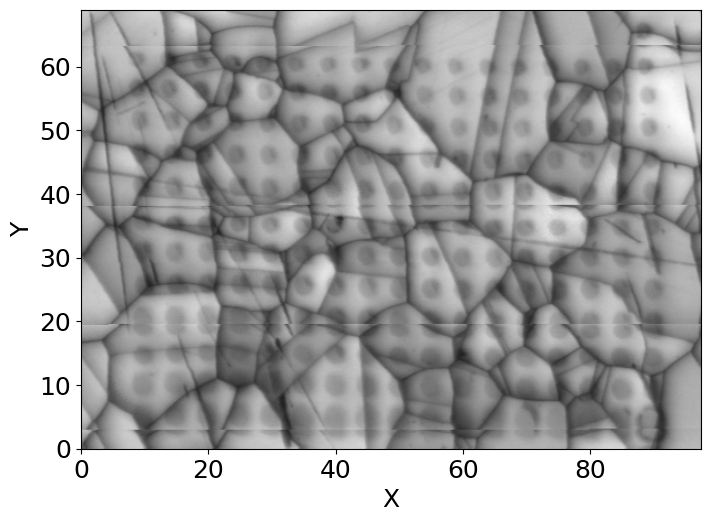

In [354]:
import matplotlib.colors as mcolors

# Read the CSV file and extract the x, y, and intensity values
data = pd.read_csv(SEM_FILE)
x = data['X']
y = data['Y'] 
intensity = data['Z']

# Create the SEM image using a custom colormap
cmap_sem = mcolors.LinearSegmentedColormap.from_list(
    "my_colormap", ["black", "grey", "white"]
)

fig, ax = plt.subplots(figsize=(8, 6))
sc_sem = ax.scatter(x, y, c=intensity, cmap=cmap_sem, s=1)  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')
plt.xlim(np.min(x), np.max(x))
plt.ylim(np.min(y), np.max(y))
plt.show()

In [355]:
# load selected oval pixels and compute footprint areas ---

selected_oval_pixels = {}
oval_area_df = None

if OVAL_FILE.exists():
    df_ovals = pd.read_csv(OVAL_FILE)

    # Basic validation (keeps failures explicit & early)
    required_cols = {"oval_id", "x", "y", "ind1", "ind2", "ind3"}
    missing_cols = required_cols - set(df_ovals.columns)
    if missing_cols:
        raise ValueError(f"{OVAL_FILE.name} missing required columns: {sorted(missing_cols)}")

    # Unit conversion: if x,y are in µm, then 1 µm = 1e-4 cm
    XY_TO_CM = 1e-4  # set to 1.0 if x,y are already in cm; adjust if different units are used

    # Fast vectorized area estimate per oval (bounding-box proxy)
    g = df_ovals.groupby("oval_id", sort=True)
    bounds = g.agg(
        x_min=("x", "min"),
        x_max=("x", "max"),
        y_min=("y", "min"),
        y_max=("y", "max"),
        n_points=("x", "size"),
    )
    bounds["x_range_cm"] = (bounds["x_max"] - bounds["x_min"]) * XY_TO_CM
    bounds["y_range_cm"] = (bounds["y_max"] - bounds["y_min"]) * XY_TO_CM
    bounds["area_cm2"] = bounds["x_range_cm"] * bounds["y_range_cm"]

    oval_area_df = bounds[["n_points", "x_range_cm", "y_range_cm", "area_cm2"]].reset_index()

    # Reconstruct original dict-like structure (compatible with your prior code pattern)
    for oval_id, grp in g:
        oval_id = int(oval_id)
        selected_oval_pixels[oval_id] = {
            "x": grp["x"].tolist(),
            "y": grp["y"].tolist(),
            "ind1": grp["ind1"].tolist(),
            "ind2": grp["ind2"].tolist(),
            "ind3": grp["ind3"].tolist(),
            "area (cm²)": float(oval_area_df.loc[oval_area_df["oval_id"] == oval_id, "area_cm2"].iloc[0]),
        }

    display(oval_area_df.head())
else:
    print(f"OVAL_FILE not found ({OVAL_FILE.name}). Skipping footprint-area computation.")

oval_id  n_points  x_range_cm  y_range_cm      area_cm2
0        1       197     0.00027    0.000294  7.950123e-08
1        2       155     0.00021    0.000294  6.183429e-08
2        3       141     0.00023    0.000242  5.577201e-08
3        4       132     0.00021    0.000260  5.455947e-08
4        5       181     0.00025    0.000294  7.361200e-08


Label colors used in SEM overlay (only labels with at least 1 oval):
 - prior_decay_activity -> yellow   (n=16)
 - meta_decay           -> orange   (n=11)
 - belly                -> green    (n=70)
 - meta                 -> blue     (n=10)
 - meta_major           -> red      (n=1)


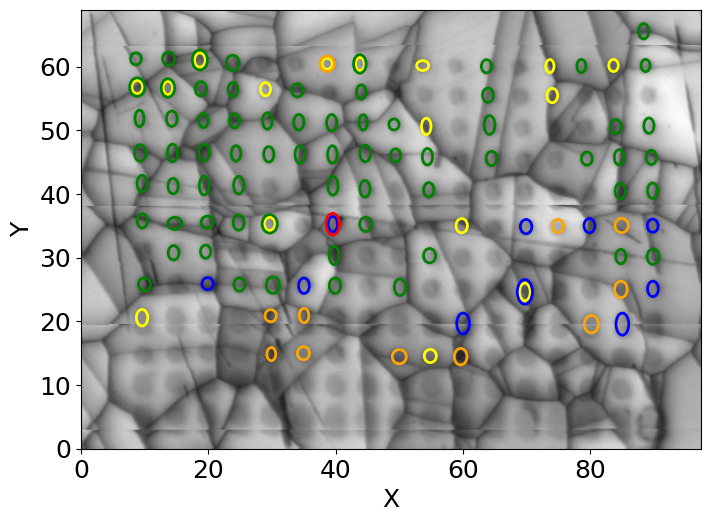

Ellipses drawn: 98 | colored: 98 | degenerate footprints: 0
Outer-highlight IDs used: [73, 113, 115, 186, 187, 190, 194, 195]


In [356]:
from matplotlib.patches import Ellipse

# ============================================================
# Assumptions (already defined in previous cells):
#   - x, y, intensity  (from SEM_FILE)
#   - selected_oval_pixels (from OVAL_FILE)  with oval_id = 1..205
#   - labels_df indexed by map_id (from LABELS_FILE)
#   - SEM_FILE, OVAL_FILE
# ============================================================

# --- knobs ---
PLOT_UNLABELED = False          # if True, draw *all* ovals (unlabeled in white)
MIN_SIZE_FRAC = 0.004          # min ellipse size as fraction of SEM span (helps degenerate footprints)
USE_LEGACY_HIGHLIGHTS = True   # True = translate old oval_id highlights (86-start) -> new 1..205
LEGACY_OFFSET = 85             # because new_id = old_id - 85 when old started at 86

# --- safety: only load SEM/ovals if they are not already in memory ---
if not all(k in globals() for k in ["x", "y", "intensity"]):
    data = pd.read_csv(SEM_FILE)
    x = data["X"]
    y = data["Y"]
    intensity = data["Z"]

if "selected_oval_pixels" not in globals() or not isinstance(selected_oval_pixels, dict) or len(selected_oval_pixels) == 0:
    df_ovals = pd.read_csv(OVAL_FILE)
    g = df_ovals.groupby("oval_id", sort=True)
    selected_oval_pixels = {
        int(oid): {
            "x": grp["x"].tolist(),
            "y": grp["y"].tolist(),
            "ind1": grp["ind1"].tolist(),
            "ind2": grp["ind2"].tolist(),
            "ind3": grp["ind3"].tolist(),
        }
        for oid, grp in g
    }


# Build the same sets used in the original plotting logic (using canonical ids_for_label)
prior_decay_activity = set(ids_for_label(labels_df, "prior_decay_activity"))
meta_decay           = set(ids_for_label(labels_df, "meta_decay"))
belly                = set(ids_for_label(labels_df, "belly"))
meta                 = set(ids_for_label(labels_df, "meta"))
meta_major           = set(ids_for_label(labels_df, "meta_major"))
extra_belly          = set(ids_for_label(labels_df, "extra_belly"))

def oval_color(oval_id: int):
    # Priority order mimics your original snippet
    if oval_id in prior_decay_activity:
        return "yellow"
    elif oval_id in meta_decay:
        return "orange"
    elif oval_id in belly:
        return "green"
    elif oval_id in meta:
        return "blue"
    elif oval_id in meta_major:
        return "red"
    elif oval_id in extra_belly:
        return "green"
    return None

# ============================================================
# Print label colors that will appear in the plot (no legend)
# ============================================================
label_color_map = {
    "prior_decay_activity": "yellow",
    "meta_decay": "orange",
    "belly": "green",
    "meta": "blue",
    "meta_major": "red",
    "extra_belly": "green",
}

label_sets = {
    "prior_decay_activity": prior_decay_activity,
    "meta_decay": meta_decay,
    "belly": belly,
    "meta": meta,
    "meta_major": meta_major,
    "extra_belly": extra_belly,
}

print("\nLabel colors used in SEM overlay (only labels with at least 1 oval):")
for name, ids in label_sets.items():
    if len(ids) > 0:
        print(f" - {name:20s} -> {label_color_map[name]:6s}   (n={len(ids)})")

# ============================================================
# Plot SEM + ovals (mimics original; optional unlabeled outlines)
# ============================================================

cmap_sem = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["black", "grey", "white"])

fig, ax = plt.subplots(figsize=(8, 6))
sc_sem = ax.scatter(x, y, c=intensity, cmap=cmap_sem, s=1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_aspect("equal")

# Minimum ellipse size (helps degenerate footprints)
x_span = float(np.max(x) - np.min(x))
y_span = float(np.max(y) - np.min(y))
min_w = MIN_SIZE_FRAC * x_span
min_h = MIN_SIZE_FRAC * y_span

# Outer highlights: keep original IDs, but optionally translate legacy -> new
highlight_old = {
    158: "blue",
    200: "green",
    271: "green",
    272: "green",
    275: "green",
    280: "green",
    279: "orange",
    198: "red",
}
if USE_LEGACY_HIGHLIGHTS:
    highlight_ids = {old_id - LEGACY_OFFSET: col for old_id, col in highlight_old.items()
                     if 1 <= (old_id - LEGACY_OFFSET) <= 205}
else:
    highlight_ids = {old_id: col for old_id, col in highlight_old.items() if 1 <= old_id <= 205}

outer_factor = 1.4  # matches your original snippet

degenerate = []
n_drawn = 0
n_colored = 0

for oval_id, coordinates in selected_oval_pixels.items():
    selected_x = np.asarray(coordinates["x"], dtype=float)
    selected_y = np.asarray(coordinates["y"], dtype=float)

    if selected_x.size == 0 or selected_y.size == 0:
        continue

    # centroid
    cent_x, cent_y = np.mean(selected_x), np.mean(selected_y)

    # width/height span
    width = float(np.max(selected_x) - np.min(selected_x))
    height = float(np.max(selected_y) - np.min(selected_y))

    if width <= 0 or height <= 0:
        degenerate.append(int(oval_id))
        width = max(width, min_w)
        height = max(height, min_h)

    color = oval_color(int(oval_id))

    # --- main ellipse ---
    # Original behavior: only draw if color is assigned
    # Debug fix: optionally draw unlabeled in white so *all* ovals appear
    if color or PLOT_UNLABELED:
        edge = color if color else "white"
        lw = 2 if color else 1
        ellipse = Ellipse((cent_x, cent_y), width=width, height=height,
                          edgecolor=edge, facecolor="none", lw=lw, zorder=5)
        ax.add_patch(ellipse)
        n_drawn += 1
        if color:
            n_colored += 1

    # --- outer ellipse highlights (translated if needed) ---
    if int(oval_id) in highlight_ids:
        outer_width = outer_factor * width
        outer_height = outer_factor * height
        outer_ellipse = Ellipse((cent_x, cent_y), width=outer_width, height=outer_height,
                                edgecolor=highlight_ids[int(oval_id)], facecolor="none", lw=2, zorder=6)
        ax.add_patch(outer_ellipse)

plt.xlim(np.min(x), np.max(x))
plt.ylim(np.min(y), np.max(y))
plt.show()

print("Ellipses drawn:", n_drawn, "| colored:", n_colored, "| degenerate footprints:", len(degenerate))
print("Outer-highlight IDs used:", sorted(highlight_ids.keys()))

{'meta_major': 1, 'meta': 10, 'belly': 70, 'meta_decay': 11, 'prior_decay_activity': 16}


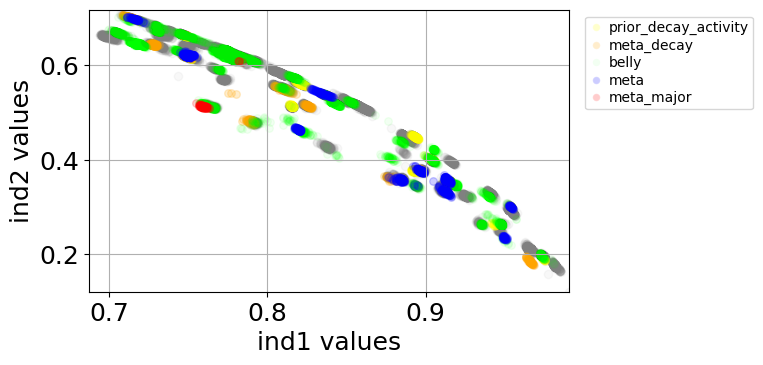

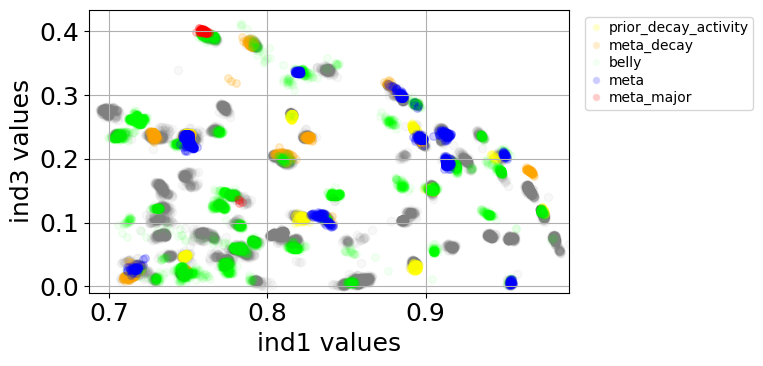

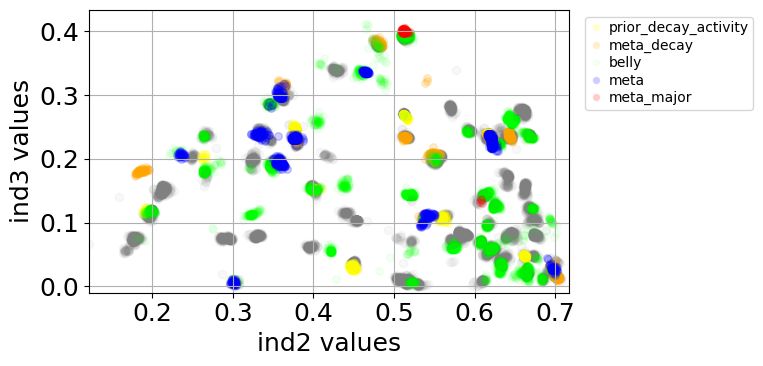

In [357]:
# =========================
# IPF-index scatter (ind1/ind2/ind3) with priority-colored classes
# =========================

# ------------------------------------------------------------------
# 0) Ensure selected_oval_pixels exists (dict: oval_id -> {'ind1':[], 'ind2':[], 'ind3':[]})
#    If you already have it in memory, this block will do nothing.
# ------------------------------------------------------------------
if "selected_oval_pixels" not in globals():
    # If you already loaded the CSV into a df, set df_oval = your_df
    df_oval = pd.read_csv(OVAL_FILE)
    selected_oval_pixels = {}
    for oid, g in df_oval.groupby("oval_id"):
        selected_oval_pixels[int(oid)] = {
            "ind1": g["ind1"].to_list(),
            "ind2": g["ind2"].to_list(),
            "ind3": g["ind3"].to_list(),
        }

# ------------------------------------------------------------------
# 1) Build category_to_ids from labels.csv (or reuse your loaded labels_df)
#    Expected columns in labels.csv: map_id, labels, prior_decay_activity, meta, meta_major, meta_decay, belly
# ------------------------------------------------------------------

labels_df = pd.read_csv(LABELS_FILE)
if "map_id" in labels_df.columns:
    labels_df = labels_df.set_index("map_id")

# -------------------------
# Build category_to_ids robustly (map_id can be column OR index)
# -------------------------
cats = ["meta_major", "meta", "belly", "meta_decay", "prior_decay_activity"]

tmp = labels_df.copy()

# If map_id is the index (your current framework), bring it back as a column
if "map_id" not in tmp.columns:
    tmp = tmp.reset_index()

# Ensure dtype
tmp["map_id"] = tmp["map_id"].astype(int)

category_to_ids = {}

# Case A: one-hot columns exist (preferred)
if set(cats).issubset(tmp.columns):
    for c in cats:
        category_to_ids[c] = set(tmp.loc[tmp[c].astype(int) == 1, "map_id"].tolist())

# Case B: parse from the "labels" string column
else:
    if "labels" not in tmp.columns:
        raise ValueError("labels_df must contain either one-hot columns or a 'labels' column.")
    tmp["labels"] = tmp["labels"].astype(str)

    for c in cats:
        # matches "c" as a token in a comma-separated list
        mask = tmp["labels"].str.contains(rf"(^|,\s*){c}(\s*,|$)", regex=True)
        category_to_ids[c] = set(tmp.loc[mask, "map_id"].tolist())

# Quick sanity check
print({k: len(v) for k, v in category_to_ids.items()})

# ------------------------------------------------------------------
# 2) Define colors (RGBA) exactly as in the original notebook
# ------------------------------------------------------------------
default_alpha = 0.05
highlight_alpha = 0.2

colors_list = [
    [0.5, 0.5, 0.5, default_alpha],   # Grey (default)
    [1, 1, 0, highlight_alpha],        # Yellow (prior_decay_activity)
    [1, 0.647, 0, highlight_alpha],    # Orange (meta_decay)
    [0, 1, 0, default_alpha],          # Green (belly)  <-- keep default_alpha to match original
    [0, 0, 1, highlight_alpha],        # Blue (meta)
    [1, 0, 0, highlight_alpha],        # Red (meta_major)
]

priority_mapping = {
    "meta_major": colors_list[5],
    "meta": colors_list[4],
    "belly": colors_list[3],
    "meta_decay": colors_list[2],
    "prior_decay_activity": colors_list[1],
}
priority_order = list(priority_mapping.keys())          # preserves the intended priority
plot_order = list(reversed(priority_order))             # plot higher priority last (on top)

# ------------------------------------------------------------------
# 3) Flatten ind1/ind2/ind3 AND build colors per-point (no point-key collisions)
# ------------------------------------------------------------------
all_ind1, all_ind2, all_ind3, colors = [], [], [], []

def _pick_category(oval_id: int):
    for cat in priority_order:
        if oval_id in category_to_ids.get(cat, set()):
            return cat
    return None

for oval_id, oval_data in selected_oval_pixels.items():
    oid = int(oval_id)
    cat = _pick_category(oid)
    col = priority_mapping[cat] if cat is not None else colors_list[0]

    ind1_list = oval_data["ind1"]
    ind2_list = oval_data["ind2"]
    ind3_list = oval_data["ind3"]

    all_ind1.extend(ind1_list)
    all_ind2.extend(ind2_list)
    all_ind3.extend(ind3_list)
    colors.extend([col] * len(ind1_list))

all_ind1 = np.asarray(all_ind1)
all_ind2 = np.asarray(all_ind2)
all_ind3 = np.asarray(all_ind3)
colors   = np.asarray(colors, dtype=float)

# ------------------------------------------------------------------
# 4) Global axis limits (for consistent limits across plots)
# ------------------------------------------------------------------
global_min_ind1, global_max_ind1 = float(all_ind1.min()), float(all_ind1.max())
global_min_ind2, global_max_ind2 = float(all_ind2.min()), float(all_ind2.max())
global_min_ind3, global_max_ind3 = float(all_ind3.min()), float(all_ind3.max())

# ------------------------------------------------------------------
# 5) Plot helper (same logic as original)
# ------------------------------------------------------------------
def plot_scatter(x_data, y_data, title, xlabel, ylabel, xlim=None, ylim=None):
    plt.figure(figsize=(8, 4))

    # Legend labels (same categories as original)
    color_labels = {
        tuple(colors_list[1]): "prior_decay_activity",
        tuple(colors_list[2]): "meta_decay",
        tuple(colors_list[3]): "belly",
        tuple(colors_list[4]): "meta",
        tuple(colors_list[5]): "meta_major",
    }

    # Plot grey first
    grey_mask = np.all(np.isclose(colors, np.array(colors_list[0]), atol=1e-12), axis=1)
    plt.scatter(x_data[grey_mask], y_data[grey_mask], color=colors_list[0])

    # Then plot each category in plot_order
    for cat in plot_order:
        col = np.array(priority_mapping[cat], dtype=float)
        mask = np.all(np.isclose(colors, col, atol=1e-12), axis=1)
        plt.scatter(x_data[mask], y_data[mask], s=30, color=priority_mapping[cat])

    # Legend (dummy handles)
    handles = []
    for col_tup, lab in color_labels.items():
        handles.append(
            plt.Line2D(
                [0], [0],
                marker="o",
                color="w",
                label=lab,                  # <-- use lab
                markersize=6,
                markerfacecolor=list(col_tup)  # <-- use col_tup
            )
        )
    
    plt.legend(
        handles=handles,
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
        fontsize=10,
        borderpad=0.3,
        labelspacing=0.25,
        handletextpad=0.4,
        handlelength=1.0,
        markerscale=0.9,
        frameon=True,
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid(True)

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# 6) Scatter plots (same offsets as original)
# ------------------------------------------------------------------
plot_scatter(
    all_ind1, all_ind2,
    "ind1 vs. ind2 for all grains",
    "ind1 values", "ind2 values",
    xlim=(global_min_ind1 + 0.015, global_max_ind1),
    ylim=(global_min_ind2, global_max_ind2 + 0.01)
)

plot_scatter(
    all_ind1, all_ind3,
    "ind1 vs. ind3 for all grains",
    "ind1 values", "ind3 values",
    xlim=(global_min_ind1 + 0.015, global_max_ind1),
    ylim=(global_min_ind3 - 0.01, global_max_ind3 - 0.02)
)

plot_scatter(
    all_ind2, all_ind3,
    "ind2 vs. ind3 for all grains",
    "ind2 values", "ind3 values",
    xlim=(global_min_ind2, global_max_ind2 + 0.01),
    ylim=(global_min_ind3 - 0.01, global_max_ind3 - 0.02)
)

In [358]:
# Prefer the vectorized DataFrame source you already loaded (df_ovals)
if "df_ovals" in globals() and isinstance(df_ovals, pd.DataFrame) and len(df_ovals) > 0:
    required_cols = {"oval_id", "ind1", "ind2", "ind3"}
    missing = required_cols - set(df_ovals.columns)
    if missing:
        raise KeyError(f"df_ovals missing required columns: {sorted(missing)}")

    # Keep only what we need for LDA (optionally keep x,y if present)
    keep_cols = ["oval_id", "ind1", "ind2", "ind3"]
    if {"x", "y"}.issubset(df_ovals.columns):
        keep_cols += ["x", "y"]

    pixels_df = df_ovals[keep_cols].copy()

else:
    # Fallback: reconstruct from selected_oval_pixels dict (slower, but compatible)
    if "selected_oval_pixels" not in globals() or not isinstance(selected_oval_pixels, dict) or len(selected_oval_pixels) == 0:
        raise NameError("Neither df_ovals nor selected_oval_pixels is available. Run the oval-loading cell first.")

    rows = []
    for oval_id, d in selected_oval_pixels.items():
        ind1 = np.asarray(d["ind1"])
        ind2 = np.asarray(d["ind2"])
        ind3 = np.asarray(d["ind3"])
        if not (len(ind1) == len(ind2) == len(ind3)):
            raise ValueError(f"Length mismatch in oval_id={oval_id}: {len(ind1)=}, {len(ind2)=}, {len(ind3)=}")

        tmp = pd.DataFrame({
            "oval_id": int(oval_id),
            "ind1": ind1,
            "ind2": ind2,
            "ind3": ind3,
        })

        # Optional x,y if present in dict
        if "x" in d and "y" in d:
            tmp["x"] = np.asarray(d["x"])
            tmp["y"] = np.asarray(d["y"])

        rows.append(tmp)

    pixels_df = pd.concat(rows, ignore_index=True)

# Ensure correct dtypes
pixels_df["oval_id"] = pixels_df["oval_id"].astype(int)
for c in ["ind1", "ind2", "ind3"]:
    pixels_df[c] = pd.to_numeric(pixels_df[c], errors="coerce")

# Optional: attach area per oval (if available)
if "oval_area_df" in globals() and oval_area_df is not None and len(oval_area_df) > 0:
    if {"oval_id", "area_cm2"}.issubset(oval_area_df.columns):
        area_map = dict(zip(oval_area_df["oval_id"].astype(int), oval_area_df["area_cm2"].astype(float)))
        pixels_df["area_cm2"] = pixels_df["oval_id"].map(area_map)

# Final sanity check
req = {"oval_id", "ind1", "ind2", "ind3"}
miss = req - set(pixels_df.columns)
if miss:
    raise KeyError(f"pixels_df missing columns: {sorted(miss)}")

pixels_df.head()

oval_id      ind1      ind2      ind3    x         y      area_cm2
0       86  0.735401  0.666956  0.119813  9.3  32.04294  3.619994e-08
1       86  0.734945  0.667031  0.122169  9.5  32.04294  3.619994e-08
2       86  0.733109  0.667769  0.128976  9.7  32.04294  3.619994e-08
3       86  0.735114  0.666263  0.125304  9.9  32.04294  3.619994e-08
4       86  0.737103  0.664300  0.124036  9.0  31.86973  3.619994e-08

In [359]:

DEFAULT_LABEL = "default"
LABEL_PRIORITY = ["meta_major", "meta", "meta_decay", "belly", "prior_decay_activity"]

def pick_primary_label_from_string(s: str) -> str:
    """If a string contains multiple tags like 'meta, belly', pick by priority."""
    if pd.isna(s) or str(s).strip() == "":
        return DEFAULT_LABEL
    parts = [p.strip() for p in re.split(r"[;,]", str(s)) if p.strip()]
    for lab in LABEL_PRIORITY:
        if lab in parts:
            return lab
    return parts[0] if parts else DEFAULT_LABEL

def pick_primary_label_from_row(row: pd.Series) -> str:
    """
    Prefer one-hot/binary columns if present (meta_major/meta/...),
    otherwise fall back to a 'labels' string column if present.
    """
    # 1) binary columns
    for lab in LABEL_PRIORITY:
        if lab in row.index:
            try:
                if int(row[lab]) == 1:
                    return lab
            except Exception:
                pass

    # 2) fallback to 'labels' string
    if "labels" in row.index:
        return pick_primary_label_from_string(row["labels"])

    return DEFAULT_LABEL

# --- Ensure labels_df exists ---
if "labels_df" not in globals() or labels_df is None:
    # If you have LABELS_FILE in your code, use it; otherwise default name
    if "LABELS_FILE" in globals() and LABELS_FILE.exists():
        labels_df = pd.read_csv(LABELS_FILE)
    else:
        labels_df = pd.read_csv("labels.csv")

# --- Normalize labels_df to always have map_id as index ---
labels_df = labels_df.copy()

if "map_id" in labels_df.columns:
    labels_df["map_id"] = labels_df["map_id"].astype(int)
    labels_df = labels_df.set_index("map_id").sort_index()
else:
    # already indexed by map_id (your current pipeline)
    if labels_df.index.name != "map_id":
        # still ok, but enforce int index
        pass
    labels_df.index = labels_df.index.astype(int)

# --- Compute one primary label per map_id ---
labels_primary = labels_df.apply(pick_primary_label_from_row, axis=1)  # Series indexed by map_id
oval_id_to_label = labels_primary.to_dict()

# --- Apply to pixels_df ---
if "pixels_df" not in globals():
    raise NameError("pixels_df not found. Run Cell 1 first.")

pixels_df = pixels_df.copy()
pixels_df["label"] = pixels_df["oval_id"].map(oval_id_to_label).fillna(DEFAULT_LABEL)

# Quick sanity (no plots)
pixels_df["label"].value_counts()

label
default                 12757
belly                    7035
meta_decay               1202
meta                     1056
prior_decay_activity      682
meta_major                 89
Name: count, dtype: int64

In [360]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# --- X, y (pixel-level) from the updated pipeline ---
required = {"ind1", "ind2", "ind3", "label"}
missing = required - set(pixels_df.columns)
if missing:
    raise KeyError(f"pixels_df missing required columns: {sorted(missing)}")

feature_names = ["ind1", "ind2", "ind3"]

# Keep only valid rows for LDA
df_lda = pixels_df[feature_names + ["label"]].copy()
df_lda = df_lda.replace([np.inf, -np.inf], np.nan).dropna(subset=feature_names + ["label"])

X = df_lda[feature_names].to_numpy(dtype=float)
y = df_lda["label"].to_numpy()

# Optional: if you want to exclude the default/unlabeled class from supervised LDA:
# mask = (y != "default")
# X, y = X[mask], y[mask]

# --- Fit pipeline: StandardScaler + LDA(1) ---
pipe = make_pipeline(StandardScaler(), LDA(n_components=1))
pipe.fit(X, y)

def lda1_loadings(pipeline_or_lda, feature_names, X=None, y=None,
                  make_positive_for=None, normalize="l1"):
    """
    Returns LDA1 coefficients in ORIGINAL feature units (undoing StandardScaler),
    optionally flips sign so chosen class has higher median LDA1,
    and normalizes (l1 or l2) for interpretability.
    """
    # Handle pipeline vs bare estimator
    if isinstance(pipeline_or_lda, Pipeline):
        scaler = pipeline_or_lda.named_steps.get("standardscaler", None)
        lda = pipeline_or_lda.named_steps["lineardiscriminantanalysis"]
        transform_fn = pipeline_or_lda.transform
    else:
        scaler = None
        lda = pipeline_or_lda
        transform_fn = lda.transform

    # Raw weights in the space LDA was fit on
    w = lda.scalings_[:, 0].astype(float)

    # Convert weights back to original feature units
    if scaler is not None:
        w = w / scaler.scale_

    # Optional sign convention: make chosen class have higher median score
    if make_positive_for is not None and (X is not None) and (y is not None):
        scores = transform_fn(X)[:, 0]
        in_class = (y == make_positive_for)
        if in_class.any() and (~in_class).any():
            if np.median(scores[in_class]) < np.median(scores[~in_class]):
                w = -w

    # Normalize for interpretability
    if normalize == "l1":
        denom = np.sum(np.abs(w))
        if denom > 0:
            w = w / denom
    elif normalize == "l2":
        denom = np.linalg.norm(w)
        if denom > 0:
            w = w / denom

    return pd.Series(w, index=feature_names)

# Choose which class you want to define as "positive" direction (same as original example)
POS_CLASS = "meta"   # change if you prefer "meta_major" etc.

w = lda1_loadings(pipe, feature_names, X=X, y=y, make_positive_for=POS_CLASS, normalize="l1")
print(w)  # absolute contributions sum to 1

eq = "LDA1 ∝ " + " ".join([f"{w[f]:+0.3f}·{f}" for f in feature_names])
print(eq)

ind1   -0.553470
ind2   -0.298888
ind3    0.147642
dtype: float64
LDA1 ∝ -0.553·ind1 -0.299·ind2 +0.148·ind3


In [361]:

# ---- safety checks ----
if "plot_df" not in globals():
    raise NameError("plot_df not found. Run the 'merge charge + rgba' cell first.")
if "desc_df" not in globals():
    raise NameError("desc_df not found. Run the descriptors-loading cell first (desc_df).")

PEAK_H_COL = _find_col(
    desc_df,
    candidates=[
        "peak height (µA/cm²)", "peak height (uA/cm²)",
        "peak height (µA/cm2)", "peak height (uA/cm2)",
        "peak height"
    ],
    contains="peak height"
)

DECAY_J_COL = _find_col(
    desc_df,
    candidates=[
        "decay max j (µA/cm²)", "decay max j (uA/cm²)",
        "decay max j (µA/cm2)", "decay max j (uA/cm2)",
        "decay max j"
    ],
    contains="decay max j"
)

# ---- map per-oval descriptor -> per-pixel column ----
plot_df["peak_h"] = plot_df["oval_id"].map(desc_df[PEAK_H_COL].to_dict())
plot_df["decay_max_j"] = plot_df["oval_id"].map(desc_df[DECAY_J_COL].to_dict())

print("Using:")
print("  PEAK_H_COL   =", PEAK_H_COL)
print("  DECAY_J_COL  =", DECAY_J_COL)

plot_df[["oval_id", "ind1", "ind2", "ind3", "peak_h", "decay_max_j"]].head()

Using:
  PEAK_H_COL   = peak height (µA)
  DECAY_J_COL  = decay max j (µA)


oval_id      ind1      ind2      ind3  peak_h  decay_max_j
0       86  0.735401  0.666956  0.119813     NaN      0.00213
1       86  0.734945  0.667031  0.122169     NaN      0.00213
2       86  0.733109  0.667769  0.128976     NaN      0.00213
3       86  0.735114  0.666263  0.125304     NaN      0.00213
4       86  0.737103  0.664300  0.124036     NaN      0.00213

Done. Unique RGBA now:
rgba
(0.5, 0.5, 0.5, 0.05)     12757
(0.0, 1.0, 0.0, 0.05)      7035
(1.0, 0.647, 0.0, 0.2)     1202
(0.0, 0.0, 1.0, 0.2)       1056
(1.0, 1.0, 0.0, 0.2)        682
(1.0, 0.0, 0.0, 0.2)         89
Name: count, dtype: int64


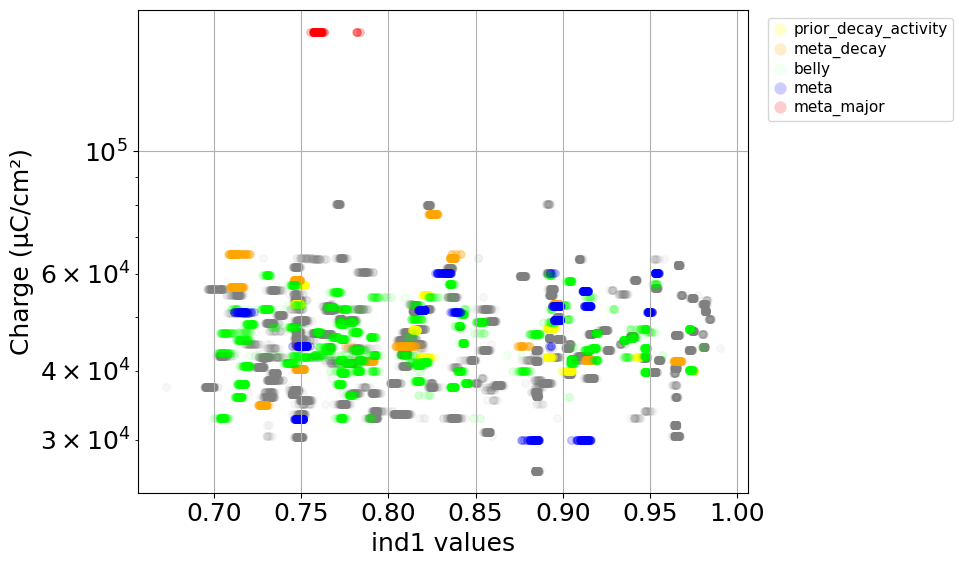

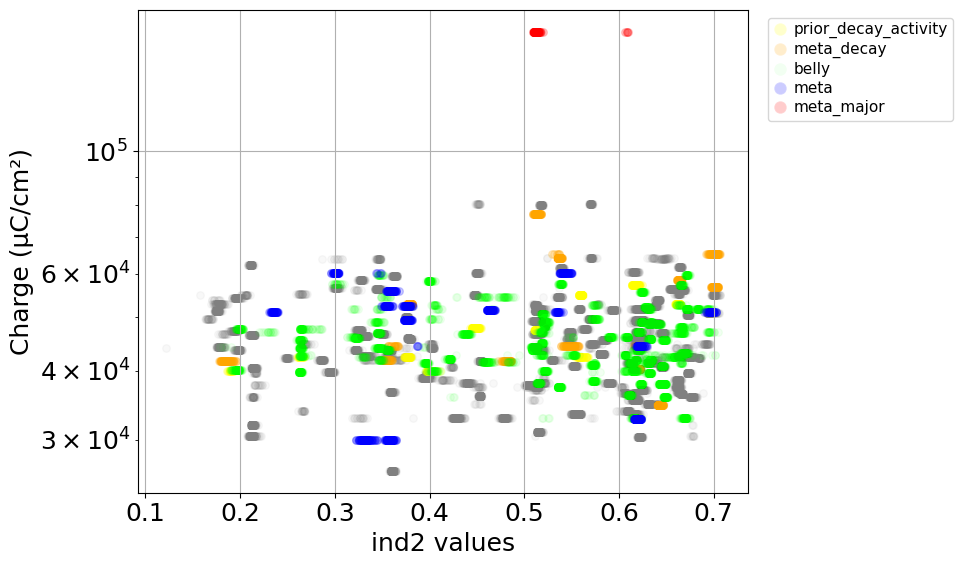

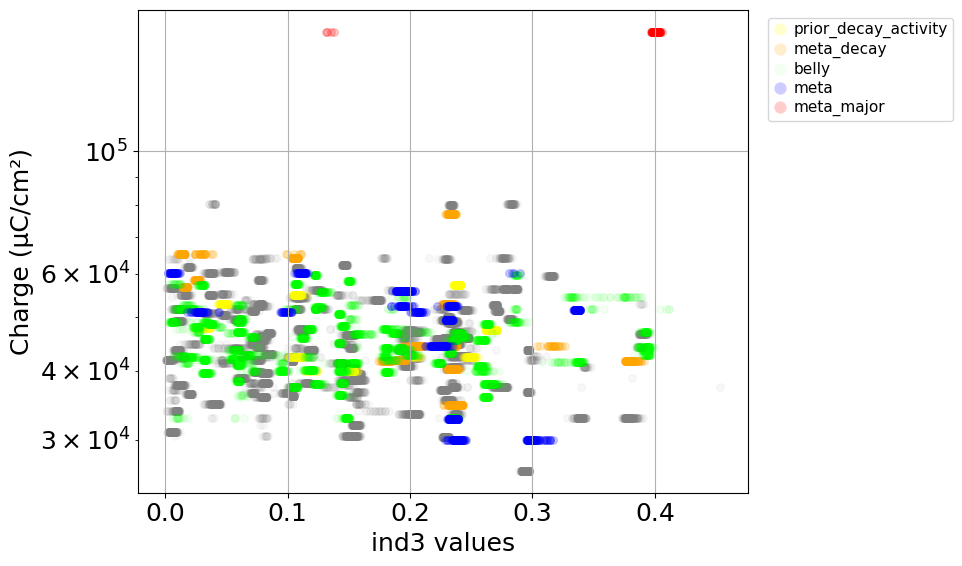

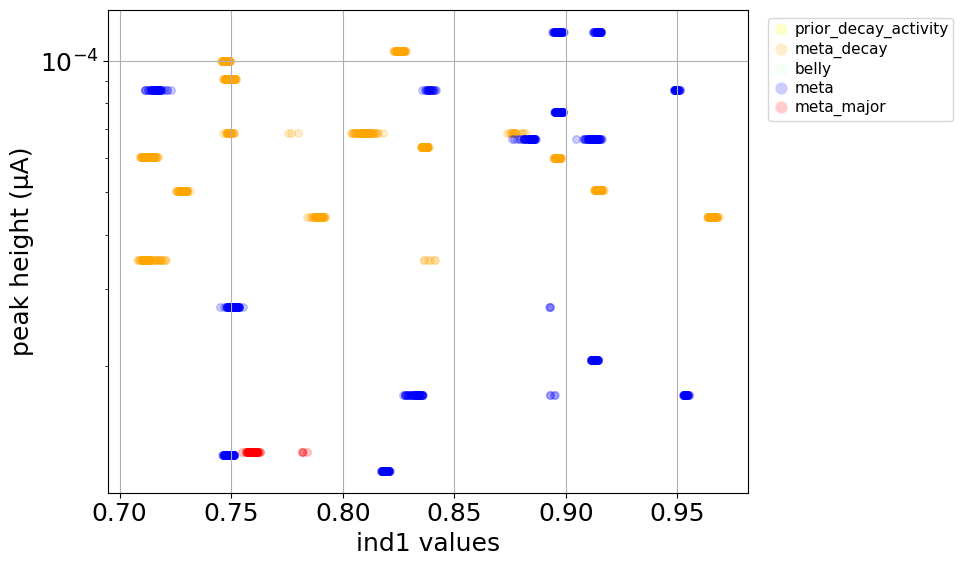

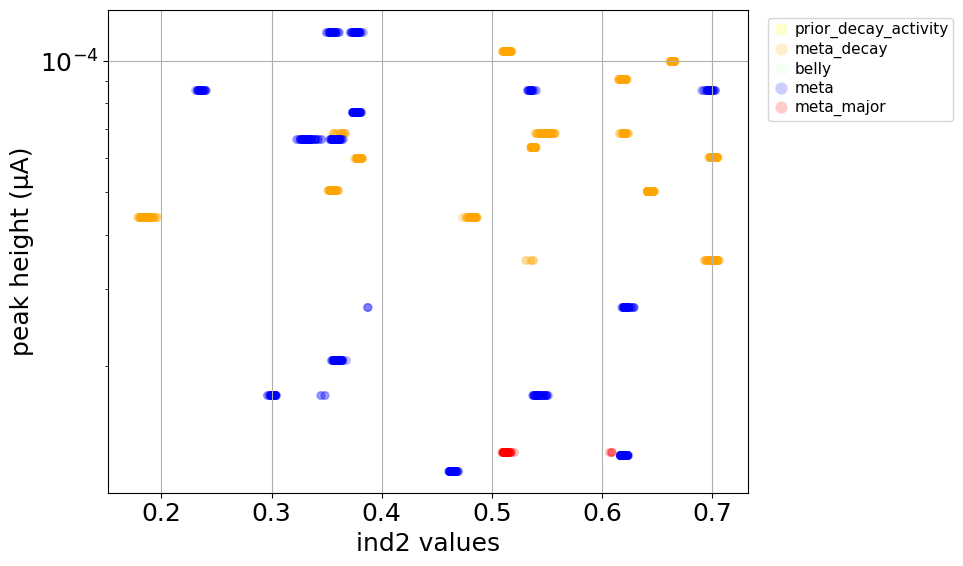

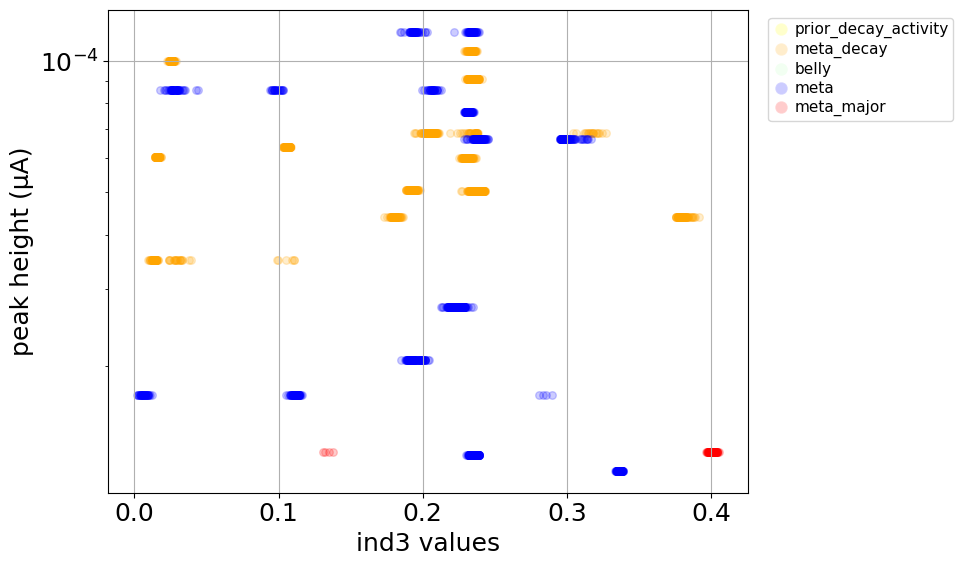

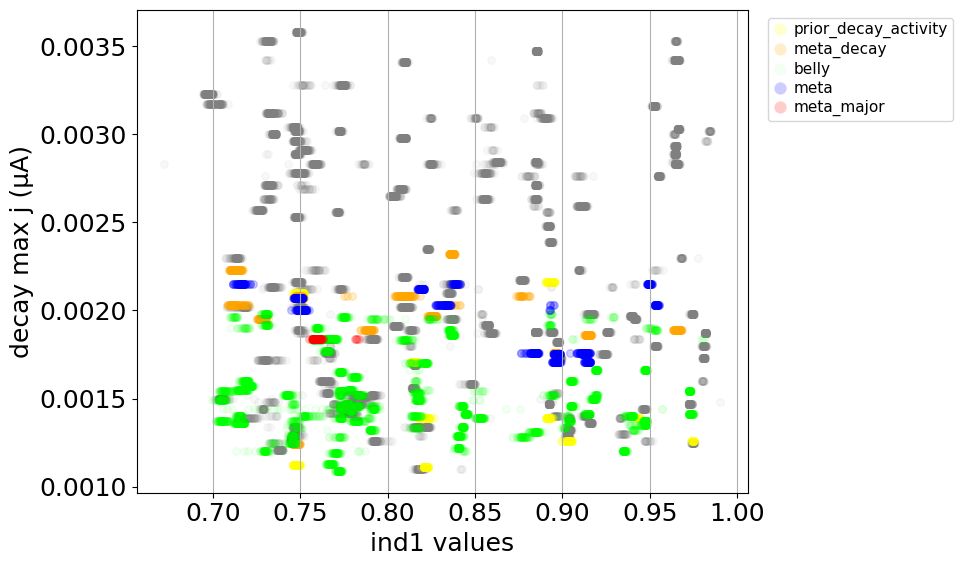

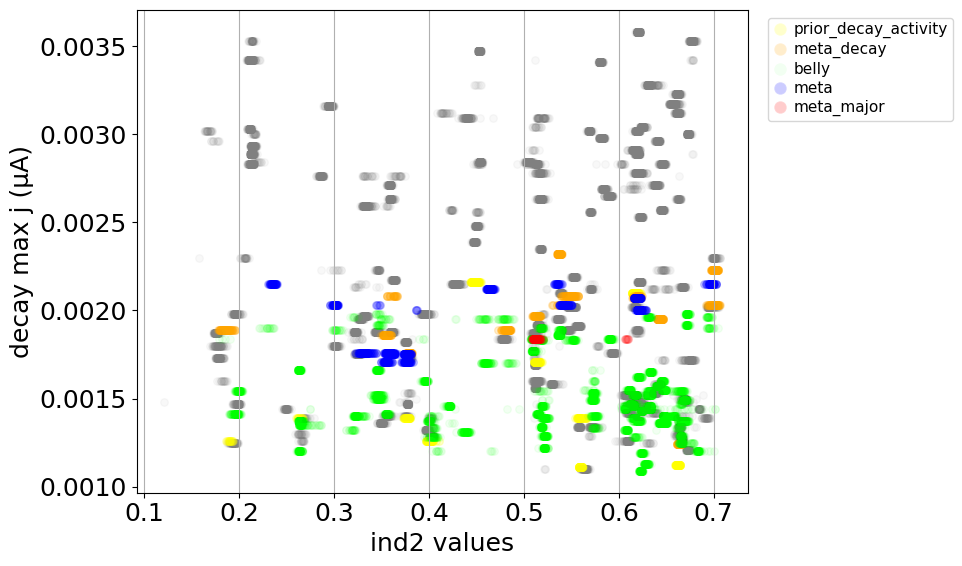

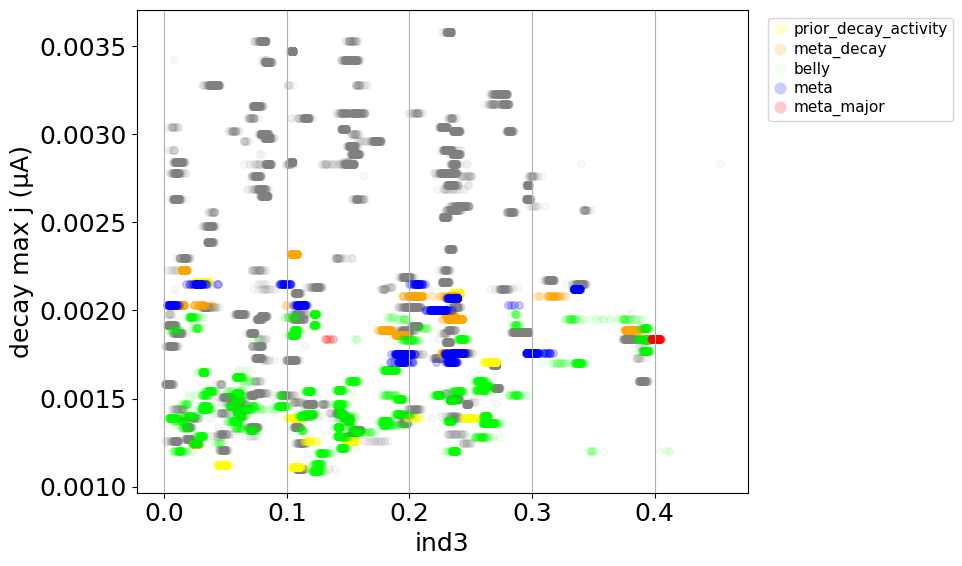

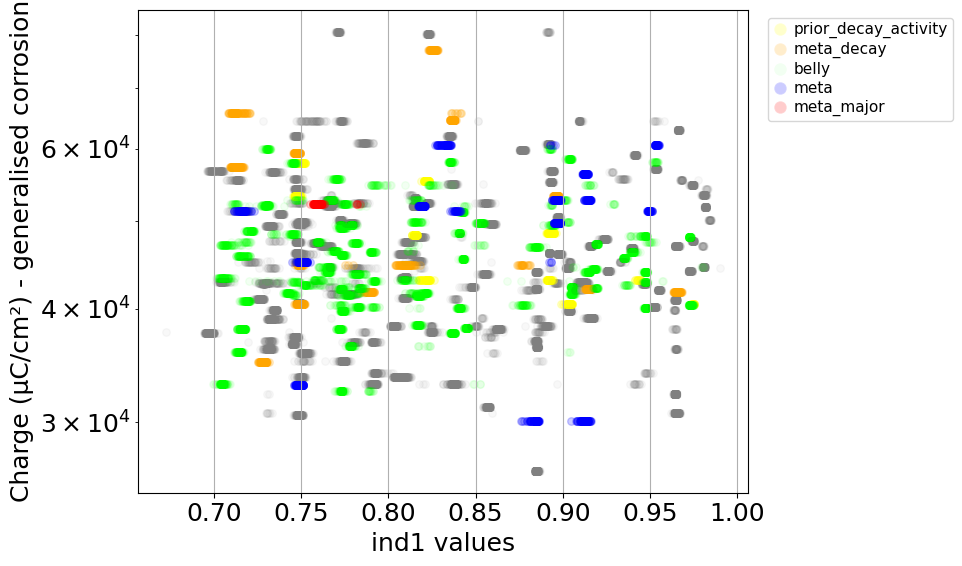

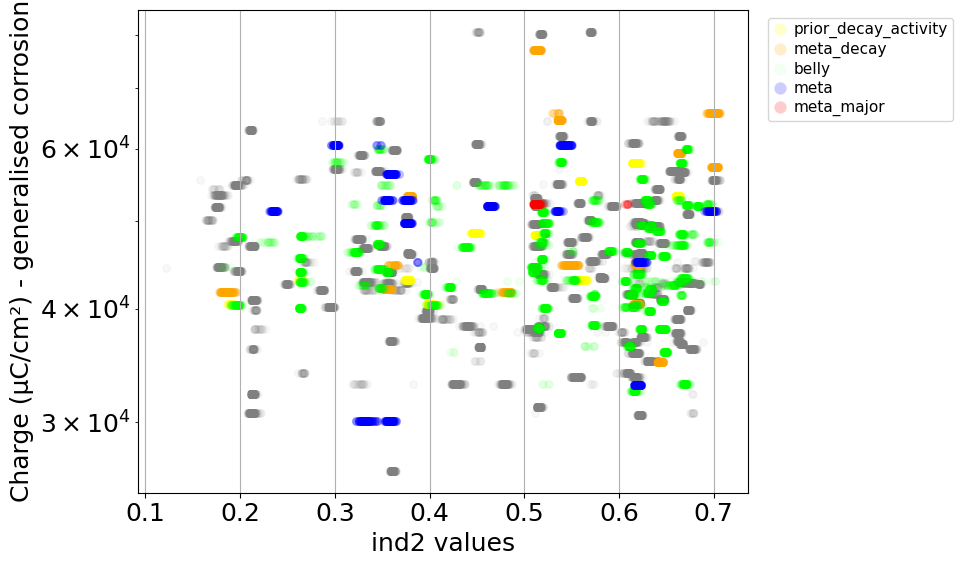

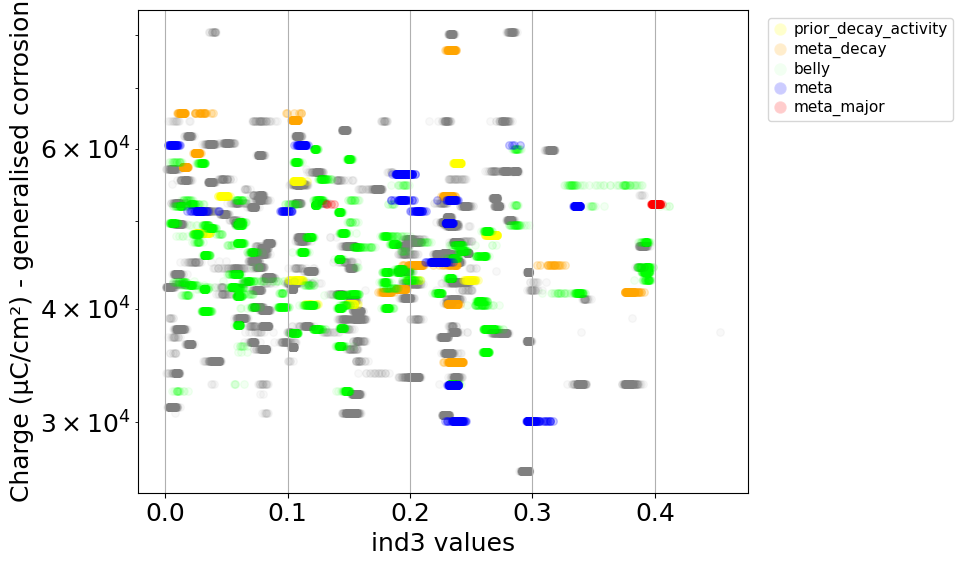

In [362]:

# -------------------------
# 0) Sanity checks
# -------------------------
req_plot_df = {"oval_id","ind1","ind2","ind3","rgba"}
miss = req_plot_df - set(plot_df.columns)
if miss:
    raise KeyError(f"plot_df missing columns: {sorted(miss)}")

# Ensure plot_df has needed y columns
for col in ["charge", "peak_h", "decay_max_j"]:
    if col not in plot_df.columns:
        raise KeyError(f"plot_df missing '{col}'. Build/mapped it earlier from desc_df.")

# Rebuild plot_df['rgba'] using CURRENT priority_mapping/colors_list and labels_df
cats_priority = ["meta_major", "meta", "belly", "meta_decay", "prior_decay_activity"]

cat_to_ids = {c: set(ids_for_label(labels_df, c)) for c in cats_priority}

def _cat_for_oid(oid: int):
    oid = int(oid)
    for c in cats_priority:
        if oid in cat_to_ids[c]:
            return c
    return None

def _rgba_for_oid(oid: int):
    c = _cat_for_oid(oid)
    return priority_mapping[c] if c is not None else colors_list[0]

plot_df["rgba"] = plot_df["oval_id"].astype(int).map(_rgba_for_oid)

print("Done. Unique RGBA now:")
print(plot_df["rgba"].apply(lambda v: tuple(np.asarray(v, float))).value_counts().head(10))

# -------------------------
# 1) Unified plot helper
# -------------------------
def plot_by_color(df, x_col, y_col,
                  xlabel=None, ylabel=None,
                  yscale=None, grid_axis="both",
                  figsize=(10, 6),
                  show_legend=True):
    """
    Generic plotter that reproduces your finalized style:
      - grey first, then plot_order overlays (high priority last)
      - tuned legend outside right
      - optional yscale
      - optional grid axis
      - NO title by default (you didn't want titles)
    """
    if xlabel is None:
        xlabel = x_col
    if ylabel is None:
        ylabel = y_col

    d = df[[x_col, y_col, "rgba"]].replace([np.inf, -np.inf], np.nan).dropna()

    # log scale safety
    if yscale == "log":
        d = d.loc[d[y_col] > 0]

    # Split by RGBA
    data_by_color = {tuple(c): ([], []) for c in colors_list}
    for x, y, rgba in zip(d[x_col].to_numpy(), d[y_col].to_numpy(), d["rgba"].to_list()):
        key = tuple(rgba)
        if key not in data_by_color:
            key = tuple(colors_list[0])
        data_by_color[key][0].append(x)
        data_by_color[key][1].append(y)

    plt.figure(figsize=figsize)

    # grey first
    gx, gy = data_by_color[tuple(colors_list[0])]
    plt.scatter(gx, gy, color=colors_list[0], s=30)

    # overlays (low -> high priority; high plotted last)
    for category in plot_order:
        rgba = priority_mapping[category]
        x_vals, y_vals = data_by_color[tuple(rgba)]
        plt.scatter(x_vals, y_vals, s=30, color=rgba)

    # legend
    if show_legend:
        color_labels = {
            tuple(colors_list[1]): "prior_decay_activity",
            tuple(colors_list[2]): "meta_decay",
            tuple(colors_list[3]): "belly",
            tuple(colors_list[4]): "meta",
            tuple(colors_list[5]): "meta_major",
        }
        handles = []
        for rgba_tup, lab in color_labels.items():
            rgba = list(rgba_tup)
            handles.append(
                plt.Line2D([0], [0], marker="o", color="w",
                           label=lab, markersize=10,
                           markerfacecolor=rgba[:3], alpha=rgba[3])
            )

        plt.legend(
            handles=handles,
            loc="upper left",
            bbox_to_anchor=(1.02, 1),
            fontsize=11,
            borderpad=0.3,
            labelspacing=0.25,
            handletextpad=0.4,
            handlelength=1.0,
            markerscale=0.9,
            frameon=True,
        )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # grid style
    if grid_axis == "x":
        plt.grid(True, axis="x")
    elif grid_axis == "y":
        plt.grid(True, axis="y")
    else:
        plt.grid(True)

    # y scale
    if yscale is not None:
        plt.yscale(yscale)

    plt.tight_layout()
    plt.show()


# -------------------------
# 2) IND plots (no titles)
# -------------------------
# Charge vs ind1/2/3 (log y)
plot_by_color(plot_df, "ind1", "charge", xlabel="ind1 values", ylabel=CHARGE_COL, yscale="log", grid_axis="both")
plot_by_color(plot_df, "ind2", "charge", xlabel="ind2 values", ylabel=CHARGE_COL, yscale="log", grid_axis="both")
plot_by_color(plot_df, "ind3", "charge", xlabel="ind3 values", ylabel=CHARGE_COL, yscale="log", grid_axis="both")

# peak height vs ind1/2/3 (log y)
plot_by_color(plot_df, "ind1", "peak_h", xlabel="ind1 values", ylabel=PEAK_H_COL, yscale="log", grid_axis="both")
plot_by_color(plot_df, "ind2", "peak_h", xlabel="ind2 values", ylabel=PEAK_H_COL, yscale="log", grid_axis="both")
plot_by_color(plot_df, "ind3", "peak_h", xlabel="ind3 values", ylabel=PEAK_H_COL, yscale="log", grid_axis="both")

# decay max j vs ind1/2/3 (linear y + vertical grid only)
plot_by_color(plot_df, "ind1", "decay_max_j", xlabel="ind1 values", ylabel=DECAY_J_COL, yscale=None, grid_axis="x")
plot_by_color(plot_df, "ind2", "decay_max_j", xlabel="ind2 values", ylabel=DECAY_J_COL, yscale=None, grid_axis="x")
plot_by_color(plot_df, "ind3", "decay_max_j", xlabel="ind3",       ylabel=DECAY_J_COL, yscale=None, grid_axis="x")


# =========================
# EXTRA: "generalised corrosion" charge vs ind1/ind2/ind3 (no title, no saving)
# =========================

# 1) Ensure plot_df has a per-pixel column for the generalised corrosion charge
if "charge_gen" not in plot_df.columns:
    if "desc_df" not in globals():
        raise NameError("desc_df not found. Load descriptors (desc_df) to map generalised corrosion charge.")

    CHARGE_GEN_COL = _find_col(
        desc_df,
        candidates=[
            "Charge (µC/cm²) - generalised corrosion",
            "Charge (uC/cm²) - generalised corrosion",
            "Charge (µC/cm2) - generalised corrosion",
            "Charge (uC/cm2) - generalised corrosion",
        ],
        contains="general"
    )

    # map per-oval -> per-pixel
    plot_df["charge_gen"] = plot_df["oval_id"].map(desc_df[CHARGE_GEN_COL].to_dict())
else:
    CHARGE_GEN_COL = "Charge (µC/cm²) - generalised corrosion"

# 2) Plots (log y, same visual style as the rest; no titles)
plot_by_color(plot_df, "ind1", "charge_gen", xlabel="ind1 values", ylabel=CHARGE_GEN_COL, yscale="log", grid_axis="both")
plot_by_color(plot_df, "ind2", "charge_gen", xlabel="ind2 values", ylabel=CHARGE_GEN_COL, yscale="log", grid_axis="both")
plot_by_color(plot_df, "ind3", "charge_gen", xlabel="ind3 values", ylabel=CHARGE_GEN_COL, yscale="log", grid_axis="both")

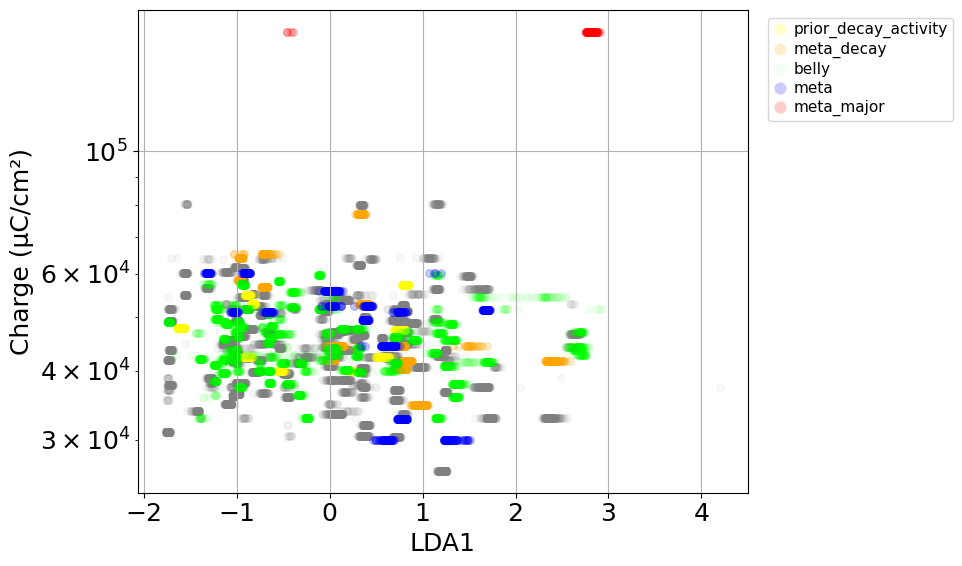

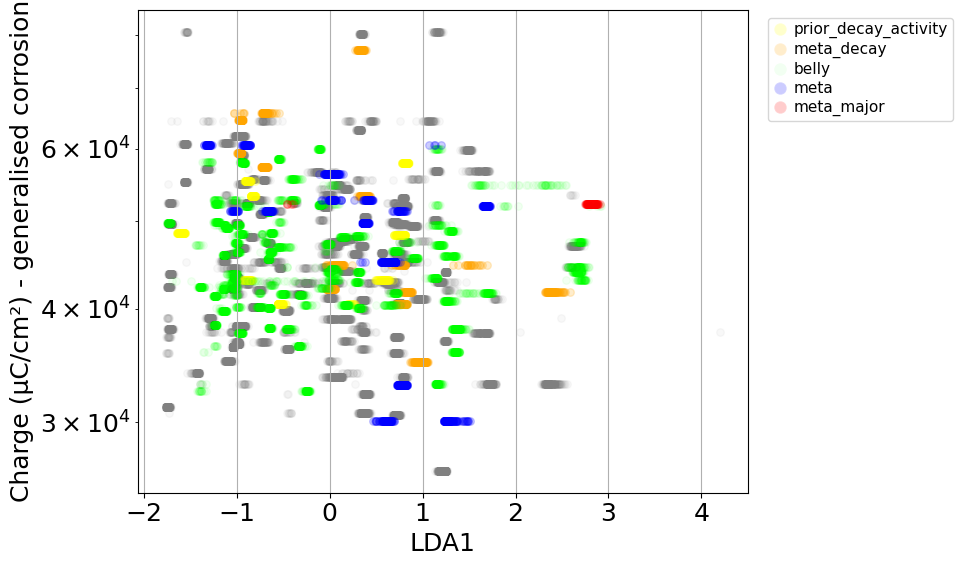

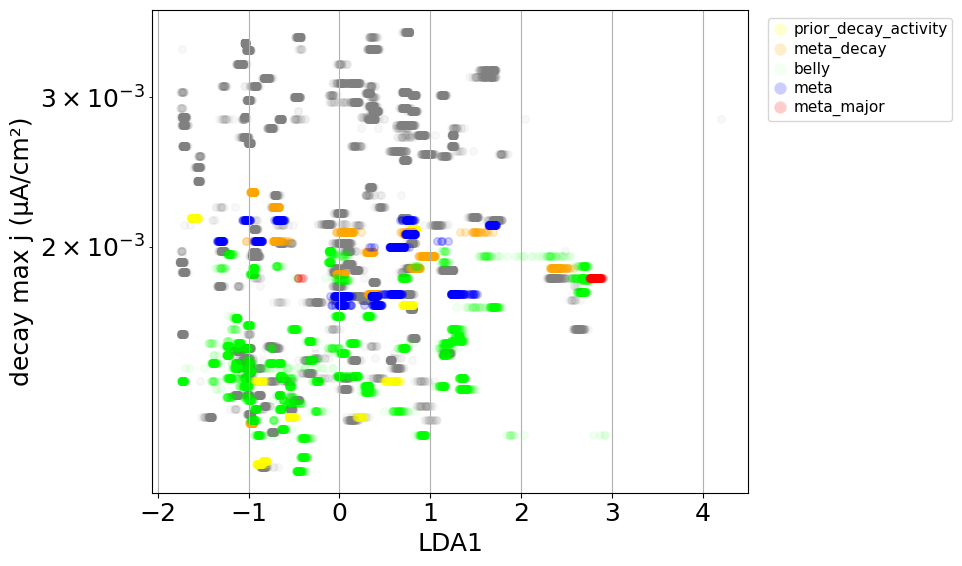

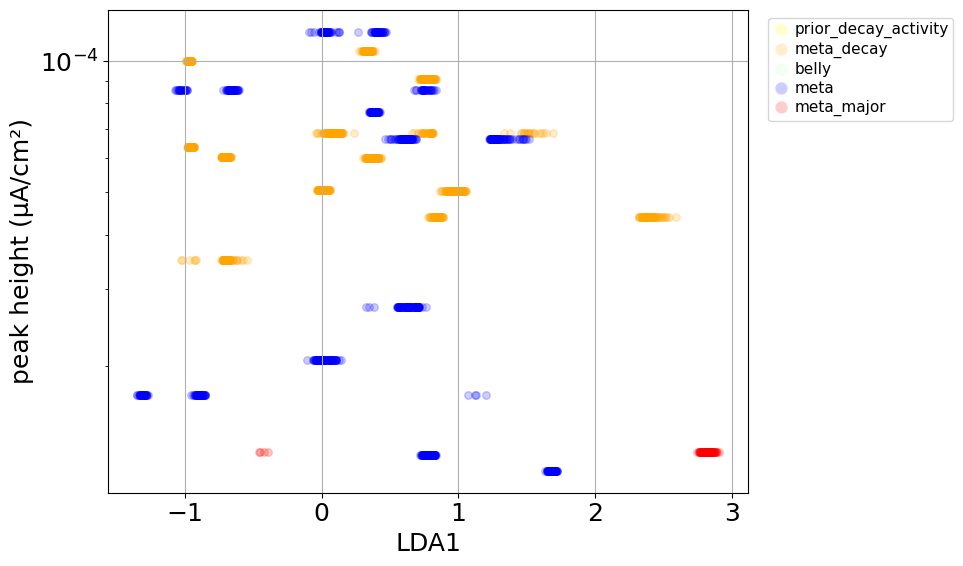

In [363]:
# -------------------------
# 3) Build df_red for LDA1 plots (safe merge) + LDA plots  (UPDATED)
#   Adds the extra plot: generalised-corrosion charge vs LDA1
#   (no titles, no saving)
# -------------------------


# --- compute LDA1 scores for the SAME rows used to fit the pipeline ---
lda1 = pipe.transform(X)[:, 0]

tmp = df_lda.copy()
tmp["lda1"] = lda1
tmp["oval_id"] = pixels_df.loc[df_lda.index, "oval_id"].to_numpy()

join_keys = ["oval_id", "ind1", "ind2", "ind3"]

# --- ensure plot_df has charge_gen (generalised corrosion) mapped per pixel ---
if "charge_gen" not in plot_df.columns:
    if "desc_df" not in globals():
        raise NameError("desc_df not found. Load descriptors (desc_df) to map generalised corrosion charge.")

    CHARGE_GEN_COL = _find_col(
        desc_df,
        candidates=[
            "Charge (µC/cm²) - generalised corrosion",
            "Charge (uC/cm²) - generalised corrosion",
            "Charge (µC/cm2) - generalised corrosion",
            "Charge (uC/cm2) - generalised corrosion",
        ],
        contains="general"
    )
    plot_df["charge_gen"] = plot_df["oval_id"].map(desc_df[CHARGE_GEN_COL].to_dict())
else:
    # keep a nice label if you already created it earlier
    CHARGE_GEN_COL = "Charge (µC/cm²) - generalised corrosion"

# --- build rhs and merge (include charge_gen now) ---
rhs_cols = ["charge", "charge_gen", "peak_h", "decay_max_j", "rgba"]
rhs = plot_df[join_keys + rhs_cols].copy()

df_red = tmp.merge(rhs, on=join_keys, how="inner")

# --- LDA plots (log y, no titles) — order: Charge first ---
plot_by_color(df_red, "lda1", "charge",      xlabel="LDA1", ylabel=CHARGE_COL,              yscale="log", grid_axis="both")

# NEW (requested): generalised corrosion charge vs LDA1
plot_by_color(df_red, "lda1", "charge_gen",  xlabel="LDA1", ylabel=CHARGE_GEN_COL,          yscale="log", grid_axis="both")

plot_by_color(df_red, "lda1", "decay_max_j", xlabel="LDA1", ylabel="decay max j (µA/cm²)",  yscale="log", grid_axis="both")
plot_by_color(df_red, "lda1", "peak_h",      xlabel="LDA1", ylabel="peak height (µA/cm²)",  yscale="log", grid_axis="both")

In [364]:
# Pick ONE example trace (robust)

# Define the universe of candidate ids:
# Prefer the published subset if available, otherwise fall back to all CA traces.
if "I_uA_desc" in globals():
    common_ids = list(I_uA_desc.columns)
else:
    common_ids = list(I_uA.columns)

def pick_example_id(common_ids, labels_df=None):
    # If labels exist and contain meta_major, prefer a "meta_major == 1" point
    if labels_df is not None and "meta_major" in labels_df.columns:
        # labels_df index is map_id (because you set_index("map_id") earlier)
        cand = labels_df.index[labels_df["meta_major"] == 1].tolist()
        cand = [m for m in cand if m in common_ids]
        if cand:
            return cand[0]
    return common_ids[0]

ex_id = pick_example_id(common_ids, labels_df)

# Use the same matrix you used to build common_ids
y_uA = (I_uA_desc[ex_id] if "I_uA_desc" in globals() else I_uA[ex_id]).to_numpy()

print("Example map_id:", ex_id)

# Optional: print params only if df_par exists AND looks aligned
if "df_par" in globals() and df_par is not None:
    print("Params (if available):")
    for k in ["PosX", "PosY", "PosZ_Contact"]:
        if k in df_par.columns and ex_id in df_par.index:
            print(f"  {k}: {df_par.loc[ex_id, k]}")
else:
    print("Params not loaded (ok).")

Example map_id: 113
Params (if available):
  PosX: 48.2846
  PosY: 67.7247
  PosZ_Contact: 34.452


DEBUG charge columns present: ['Charge (µC)', 'Belly charge (µC)', 'peak charge (µC)', 'peak2 charge (µC)', 'decay region charge (µC)', 'decay charge (µC)', 'Total Charge (µC)', 'Charge (µC) - generalised corrosion']
DEBUG used keys: {'Charge': 'Charge (µC)', 'decay': 'decay charge (µC)', 'decay_region': 'decay region charge (µC)'}


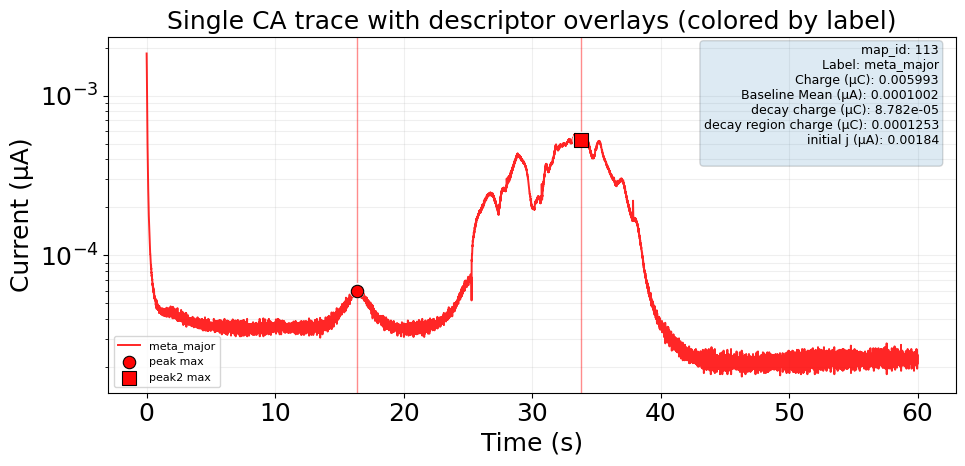

In [365]:
def y_at_time_nearest(t, y, t_target):
    """
    Nearest-sample lookup.

    Works in two modes:
      - 1D: y shape (n_time,), t_target is a scalar -> returns float
      - 2D: y shape (n_time, n_curves), t_target shape (n_curves,) -> returns (n_curves,) array
    """
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)

    # --- Mode A: single trace (1D) ---
    if y.ndim == 1:
        tt = float(t_target)
        i = int(np.nanargmin(np.abs(t - tt)))
        return float(y[i])

    # --- Mode B: many traces (2D) ---
    if y.ndim == 2:
        t_targets = np.asarray(t_target, dtype=float)
        n_time = t.size
        n_curves = y.shape[1]

        y_out = np.full(n_curves, np.nan, dtype=float)
        ok = np.isfinite(t_targets)
        if not np.any(ok):
            return y_out

        tt = t_targets[ok]
        idx = np.searchsorted(t, tt, side="left")
        idx = np.clip(idx, 1, n_time - 1)

        left = idx - 1
        right = idx
        choose_left = (tt - t[left]) <= (t[right] - tt)
        nearest_idx = np.where(choose_left, left, right)

        cols = np.nonzero(ok)[0]
        y_out[ok] = y[nearest_idx, cols]
        return y_out

    raise ValueError(f"y must be 1D or 2D, got shape={y.shape}")

def _get_charge_uC(row, key_uC, key_C):
    """
    Return (value_in_uC, unit_str, source_key_used).
    If only C is available, convert to µC.
    """
    if key_uC in row.index:
        v = row.get(key_uC, np.nan)
        return float(v) if np.isfinite(v) else np.nan, "µC", key_uC

    if key_C in row.index:
        v = row.get(key_C, np.nan)
        v = float(v) if np.isfinite(v) else np.nan
        return (v * 1e6) if np.isfinite(v) else np.nan, "µC", key_C  # convert C -> µC

    return np.nan, "µC", None

def plot_trace_with_descriptors(map_id: int):
    if map_id not in I_uA.columns:
        raise KeyError(f"map_id={map_id} not found in CA columns.")
    if map_id not in desc_df.index:
        raise KeyError(f"map_id={map_id} not found in descriptor table.")

    # Determine label + color (fallback-safe)
    try:
        lab = pick_primary_label(int(map_id))
    except Exception:
        lab = "unlabeled"
    col = label_color.get(lab, "gray")

    y = I_uA[map_id].to_numpy()
    row = desc_df.loc[map_id]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(t, y, lw=1.4, color=col, alpha=0.85, label=f"{lab}")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Current (µA)")

    # Safer than log if you might have <=0 values
    if np.nanmin(y) > 0:
        ax.set_yscale("log")
    else:
        ax.set_yscale("symlog", linthresh=1e-6)

    ax.grid(True, which="both", alpha=0.2)

    # Event markers/lines
    for name, tcol, mkr, s0 in [
        ("peak max",  "peak max position (s)",  "o", 80),
        ("belly max", "Belly max position (s)", "^", 80),
        ("peak2 max", "peak2 max position (s)", "s", 95),
    ]:
        tt = row.get(tcol, np.nan)
        if np.isfinite(tt):
            yy = y_at_time_nearest(t, y, tt)
            ax.axvline(tt, lw=1.0, alpha=0.45, color=col)

            ax.scatter([tt], [yy], s=s0+45, c="white", edgecolors="none", alpha=0.95, zorder=9)
            ax.scatter([tt], [yy], s=s0, c=col, marker=mkr,
                       edgecolors="k", linewidths=0.8, alpha=0.98, zorder=10, label=name)

    # ---- Charge fields: always display in µC; convert if only C exists ----
    Q_uC, _, Q_src = _get_charge_uC(row, "Charge (µC)", "Charge (C)")
    Qdec_uC, _, Qdec_src = _get_charge_uC(row, "decay charge (µC)", "decay charge (C)")
    QdecR_uC, _, QdecR_src = _get_charge_uC(row, "decay region charge (µC)", "decay region charge (C)")

    # Debug prints (you can delete after confirming)
    print("DEBUG charge columns present:",
          [c for c in row.index if "charge" in c.lower()])
    print("DEBUG used keys:", {"Charge": Q_src, "decay": Qdec_src, "decay_region": QdecR_src})

    txt = (
        f"map_id: {map_id}\n"
        f"Label: {lab}\n"
        f"Charge (µC): {Q_uC:.4g}\n"
        f"Baseline Mean (µA): {row.get('Baseline Mean (µA)', np.nan):.4g}\n"
        f"decay charge (µC): {Qdec_uC:.4g}\n"
        f"decay region charge (µC): {QdecR_uC:.4g}\n"
        f"initial j (µA): {row.get('initial j (µA)', np.nan):.4g}\n"
    )
    ax.text(
        0.98, 0.98, txt,
        transform=ax.transAxes,
        va="top", ha="right",
        fontsize=9,
        bbox=dict(boxstyle="round", alpha=0.15)
    )

    ax.set_title("Single CA trace with descriptor overlays (colored by label)")
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        ax.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

# Example
plot_trace_with_descriptors(113)

In [366]:
# ------------------------------------------------------------
# Add two derived features INTO desc_norm_df (for later plots/correlations)
#   - peak aspect ratio (µA/(cm²·s)) = peak height (µA/cm²) / peak width (s)
#   - Belly aspect ratio (µA/(cm²·s)) = Belly height (µA/cm²) / Belly width (s)
# Also define plotting-only marker-size vectors (area_values_*)
# ------------------------------------------------------------

# ---- 1) Add derived columns to desc_norm_df (in-place) ----
req = [
    "peak height (µA/cm²)", "peak width (s)",
    "Belly height (µA/cm²)", "Belly width (s)",
]
missing = [c for c in req if c not in desc_norm_df.columns]
if missing:
    raise KeyError(
        "Missing required columns in desc_norm_df to compute aspect ratios:\n"
        + "\n".join(f" - {c}" for c in missing)
    )

# Convert widths to numeric, protect against division by zero
peak_w  = pd.to_numeric(desc_norm_df["peak width (s)"], errors="coerce").replace(0, np.nan)
belly_w = pd.to_numeric(desc_norm_df["Belly width (s)"], errors="coerce").replace(0, np.nan)

desc_norm_df["peak aspect ratio (µA/(cm²·s))"] = (
    pd.to_numeric(desc_norm_df["peak height (µA/cm²)"], errors="coerce") / peak_w
)
desc_norm_df["Belly aspect ratio (µA/(cm²·s))"] = (
    pd.to_numeric(desc_norm_df["Belly height (µA/cm²)"], errors="coerce") / belly_w
)

# ---- 2) Plotting-only marker sizes (do NOT store these in desc_norm_df) ----
# (These match your original code style exactly; they are just helper vectors.)
descriptors = desc_norm_df  # alias for plotting cells (optional, matches old variable name)

# Label ID sets should already exist from your "Run once after labels_df is loaded" cell.
# If not, fall back to empty sets (keeps this cell robust).
prior_decay_activity = prior_decay_activity if "prior_decay_activity" in globals() else set()
belly               = belly               if "belly"               in globals() else set()
meta_decay          = meta_decay          if "meta_decay"          in globals() else set()
meta                = meta                if "meta"                in globals() else set()
meta_major          = meta_major          if "meta_major"          in globals() else set()

# Global marker sizes
area_values = descriptors["footprint area (µm²)"] / descriptors["footprint area (µm²)"].max() * 150

# Group-specific marker sizes (avoid errors if list empty)
def _area_values(ids):
    """
    ids can be list/set/array-like of map_id.
    Returns marker sizes normalized within the group.
    """
    if ids is None:
        return pd.Series(dtype=float)

    ids_list = list(ids)  # <-- key fix: set -> list
    if len(ids_list) == 0:
        return pd.Series(dtype=float)

    # keep only ids that exist in descriptors index (avoids KeyError)
    idx_ok = descriptors.index.intersection(pd.Index(ids_list))
    if len(idx_ok) == 0:
        return pd.Series(dtype=float)

    s = pd.to_numeric(descriptors.loc[idx_ok, "footprint area (µm²)"], errors="coerce")
    m = s.max()
    return (s / m * 150) if (pd.notna(m) and m > 0) else (s * 0)

area_values_prior = _area_values(prior_decay_activity)
area_values_belly = _area_values(belly)
area_values_decay = _area_values(meta_decay)
area_values_meta  = _area_values(meta)
area_values_major = _area_values(meta_major)

print("Added to desc_norm_df:",
      ["peak aspect ratio (µA/(cm²·s))", "Belly aspect ratio (µA/(cm²·s))"])
display(desc_norm_df[[
    "peak aspect ratio (µA/(cm²·s))",
    "Belly aspect ratio (µA/(cm²·s))",
    "footprint area (µm²)"
]].head(-10))

Added to desc_norm_df: ['peak aspect ratio (µA/(cm²·s))', 'Belly aspect ratio (µA/(cm²·s))']


peak aspect ratio (µA/(cm²·s))  Belly aspect ratio (µA/(cm²·s))  \
map_id                                                                    
1                                  NaN                              NaN   
2                                  NaN                              NaN   
3                                  NaN                              NaN   
4                                  NaN                              NaN   
5                                  NaN                              NaN   
...                                ...                              ...   
191                                NaN                        24.401514   
192                                NaN                              NaN   
193                                NaN                              NaN   
194                       156563.92113                              NaN   
195                                NaN                        37.464641   

        footprint area (µm²)  
map_id                        
1                   7.950123  
2                   6.183429  
3                   5.577201  
4                   5.455947  
5                   7.361200  
...                      ...  
191                 4.849740  
192                 4.607253  
193                 2.598075  
194                 2.771280  
195                 2.909844  

[195 rows x 3 columns]

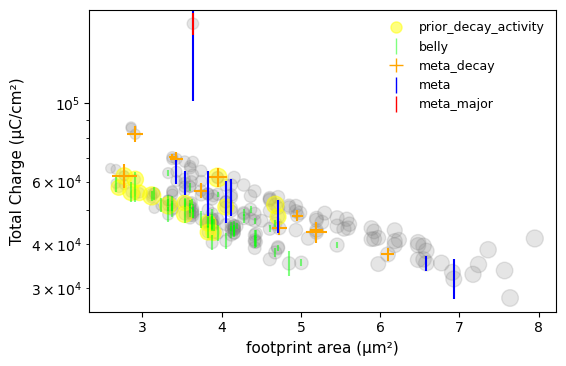

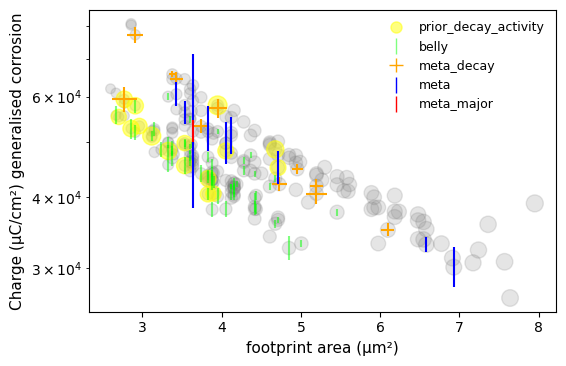

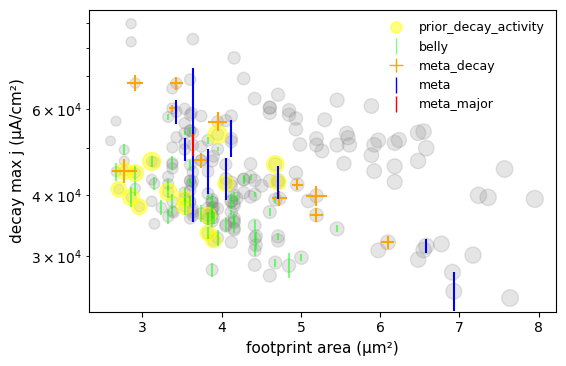

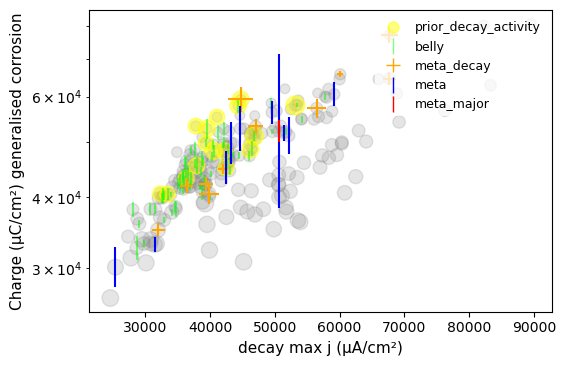

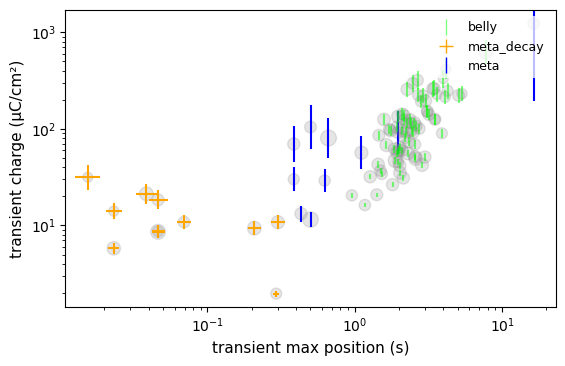

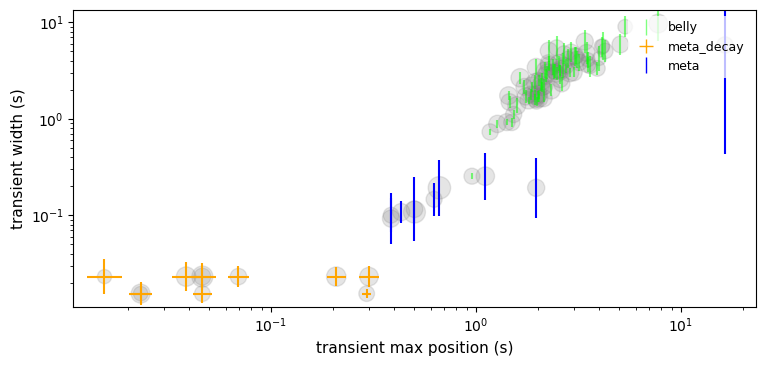

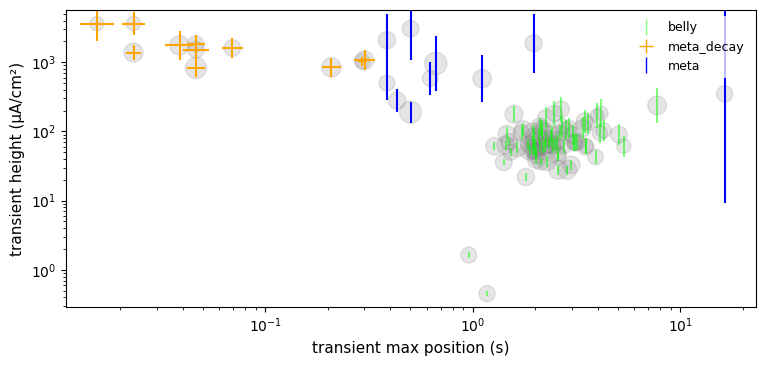

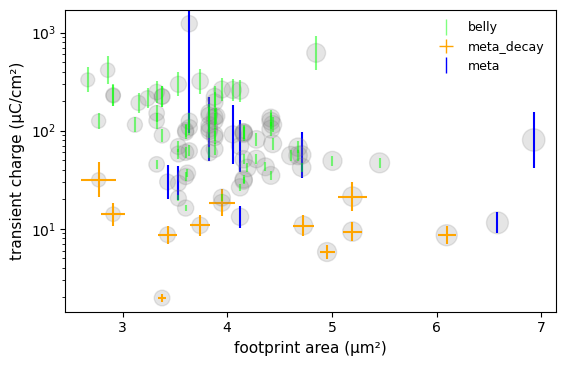

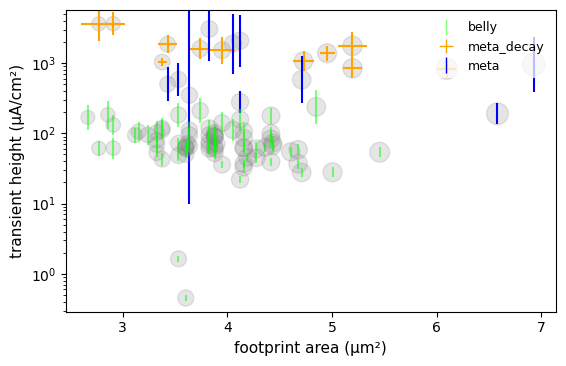

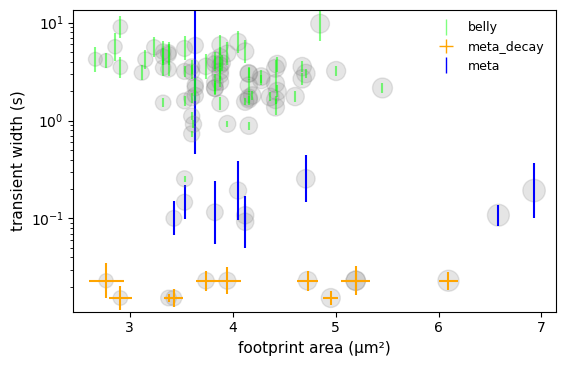

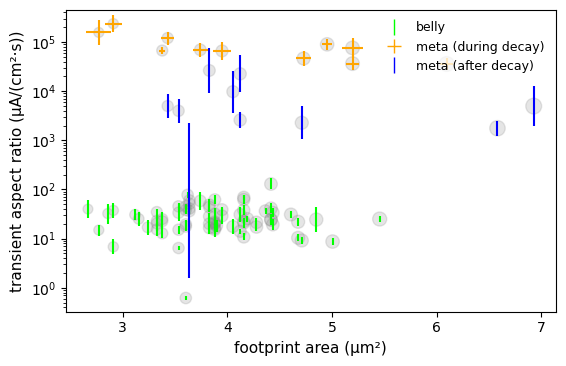

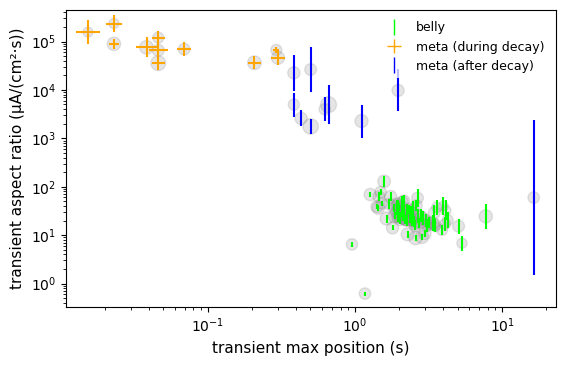

In [367]:
# ------------------------------------------------------------
# Descriptor correlation scatter plots (framework)
# - reproduces the original "many individual cells" plotting style
# - DOES NOT save figures
# - honours per-plot log scaling (x/y)
# - uses the same group styling logic (grey background + colored groups)
#
# Requirements already defined earlier:
#   descriptors = desc_norm_df  (area-normalised, includes the two aspect ratios)
#   area_values, area_values_prior, area_values_belly, area_values_decay, area_values_meta, area_values_major
#   prior_decay_activity, belly, meta_decay, meta, meta_major
#   duration_values_prior / _belly / _decay / _meta / _major  (if you use them for marker sizes)
# ------------------------------------------------------------

# -----------------------
# 0) Helpers
# -----------------------
def _safe_loc(series, ids):
    """Robust .loc that silently drops ids not present in the index."""
    if ids is None or len(ids) == 0:
        return series.iloc[0:0]
    ids = [int(i) for i in ids if int(i) in series.index]
    return series.loc[ids]

def _safe_sizes(sizes, ids, default_scale=1.0):
    """
    Returns sizes aligned to ids.
    - If sizes is a Series indexed by map_id, we loc-select.
    - If sizes is a scalar or None, we return a scalar.
    - If list/array, we align by position assuming same ordering as ids.
    """
    if sizes is None:
        return None
    if np.isscalar(sizes):
        return float(sizes) * default_scale
    if isinstance(sizes, pd.Series):
        return _safe_loc(sizes, ids).to_numpy() * default_scale
    arr = np.asarray(sizes, dtype=float)
    # best-effort: if same length as ids
    if len(arr) == len(ids):
        return arr * default_scale
    return arr * default_scale

def _scatter_groups(ax, x_col, y_col,
                   xlog=False, ylog=False,
                   xlabel=None, ylabel=None,
                   figsize=(6,4),
                   grey_s=None,
                   group_s=None,
                   group_alpha=None,
                   show=True):
    """
    One plot = grey background (all points) + selected groups overlaid.
    Marker styles match your original code:
      - prior_decay_activity: yellow circles
      - belly: lime vertical bar '|'
      - meta_decay: orange '+'
      - meta: blue vertical bar '|'
      - meta_major: red vertical bar '|'
    """
    # base x/y
    x_all = descriptors[x_col]
    y_all = descriptors[y_col]

    fig, ax = plt.subplots(figsize=figsize)

    # --- background (all points, grey) ---
    s_bg = grey_s if grey_s is not None else area_values
    ax.scatter(x_all, y_all, c="grey", s=s_bg, alpha=0.2)

    # --- overlay groups ---
    # marker sizes: use duration_values_* if you have them; otherwise fallback to group area_values_*
    # (this mirrors original intent: "size ~ event duration", but stays robust)
    s_prior = _safe_sizes(group_s.get("prior"), prior_decay_activity) if group_s else _safe_sizes(None, [])
    s_belly = _safe_sizes(group_s.get("belly"), belly) if group_s else _safe_sizes(None, [])
    s_decay = _safe_sizes(group_s.get("meta_decay"), meta_decay) if group_s else _safe_sizes(None, [])
    s_meta  = _safe_sizes(group_s.get("meta"), meta) if group_s else _safe_sizes(None, [])
    s_major = _safe_sizes(group_s.get("meta_major"), meta_major) if group_s else _safe_sizes(None, [])

    a_prior = (group_alpha.get("prior", 0.5) if group_alpha else 0.5)
    a_belly = (group_alpha.get("belly", 0.5) if group_alpha else 0.5)
    a_decay = (group_alpha.get("meta_decay", 1.0) if group_alpha else 1.0)
    a_meta  = (group_alpha.get("meta", 1.0) if group_alpha else 1.0)
    a_major = (group_alpha.get("meta_major", 1.0) if group_alpha else 1.0)

    # Prior decay activity
    if len(prior_decay_activity) > 0:
        ax.scatter(
            _safe_loc(x_all, prior_decay_activity),
            _safe_loc(y_all, prior_decay_activity),
            s=s_prior if s_prior is not None else area_values_prior,
            c="yellow",
            alpha=a_prior
        )

    # Belly
    if len(belly) > 0:
        ax.scatter(
            _safe_loc(x_all, belly),
            _safe_loc(y_all, belly),
            marker="|",
            s=s_belly if s_belly is not None else area_values_belly,
            c="lime",
            alpha=a_belly
        )

    # Meta-decay
    if len(meta_decay) > 0:
        ax.scatter(
            _safe_loc(x_all, meta_decay),
            _safe_loc(y_all, meta_decay),
            marker="+",
            s=s_decay if s_decay is not None else area_values_decay,
            c="orange",
            alpha=a_decay
        )

    # Meta
    if len(meta) > 0:
        ax.scatter(
            _safe_loc(x_all, meta),
            _safe_loc(y_all, meta),
            marker="|",
            s=s_meta if s_meta is not None else area_values_meta,
            c="blue",
            alpha=a_meta
        )

    # Meta-major
    if len(meta_major) > 0:
        ax.scatter(
            _safe_loc(x_all, meta_major),
            _safe_loc(y_all, meta_major),
            marker="|",
            s=s_major if s_major is not None else area_values_major,
            c="red",
            alpha=a_major
        )

    # scales
    if xlog:
        ax.set_xscale("log")
    if ylog:
        ax.set_yscale("log")

    ax.set_xlabel(xlabel if xlabel else x_col)
    ax.set_ylabel(ylabel if ylabel else y_col)

    plt.tight_layout()
    if show:
        plt.show()
    return fig, ax

# 1) Coloured marker sizes (MATCH original code proportions)
#    "duration_values_*" are just plotting sizes (points^2)
# -----------------------
req_cols = ["decay charge (µC/cm²)", "Belly charge (µC/cm²)", "peak charge (µC/cm²)"]
missing = [c for c in req_cols if c not in descriptors.columns]
if missing:
    raise KeyError("Missing columns needed to build coloured marker sizes:\n" + "\n".join(f" - {c}" for c in missing))

# --- identical scaling logic to your original notebook ---
# prior uses decay charge (all sites; later filtered by .loc[prior_decay_activity])
duration_values_prior = descriptors["decay charge (µC/cm²)"] / 20.0

# belly / meta_decay / meta / meta_major are defined only on their subsets (as in original)
duration_values_belly = _safe_loc(descriptors["Belly charge (µC/cm²)"], belly) / 2.0
duration_values_decay = _safe_loc(descriptors["peak charge (µC/cm²)"], meta_decay) * 10.0
duration_values_meta  = _safe_loc(descriptors["peak charge (µC/cm²)"], meta) * 10.0
duration_values_major = _safe_loc(descriptors["peak charge (µC/cm²)"], meta_major) / 5.0

# Now force the plotting code to use these (no globals-guessing)
group_s = {
    "prior": duration_values_prior,
    "belly": duration_values_belly,
    "meta_decay": duration_values_decay,
    "meta": duration_values_meta,
    "meta_major": duration_values_major,
}

# (optional) per-group alpha tweak
group_alpha = {
    "prior": 0.5,
    "belly": 0.5,
    "meta_decay": 1.0,
    "meta": 1.0,
    "meta_major": 1.0,
}

# -----------------------
# 2) Reproduce the original plots via a compact "spec list"
#    (comment out any entries to skip)
# -----------------------
PLOTS = [
    # footprint vs charges / currents (y log)
    dict(x="footprint area (µm²)", y="Total Charge (µC/cm²)", ylog=True,
         figsize=(6,4), ylabel="Total Charge (µC/cm²)"),
    dict(x="footprint area (µm²)", y="Charge (µC/cm²) - generalised corrosion", ylog=True,
         figsize=(6,4), ylabel="Charge (µC/cm²) generalised corrosion"),
    dict(x="footprint area (µm²)", y="decay max j (µA/cm²)", ylog=True,
         figsize=(6,4), ylabel="decay max j (µA/cm²)"),

    # decay max j vs generalized corrosion (y log)
    dict(x="decay max j (µA/cm²)", y="Charge (µC/cm²) - generalised corrosion", ylog=True,
         figsize=(6,4), xlabel="decay max j (µA/cm²)", ylabel="Charge (µC/cm²) generalised corrosion"),

    # transient max position vs charge (x log, y log)
    dict(x="peak max position (s)", y="peak charge (µC/cm²)", xlog=True, ylog=True,
         figsize=(6,4), xlabel="transient max position (s)", ylabel="transient charge (µC/cm²)",
         # This one overlays peak and belly in the SAME figure in your original code.
         overlay_second=dict(x="Belly max position (s)", y="Belly charge (µC/cm²)", include_groups=["belly","meta","meta_decay"]),plot_prior=False, plot_major=False 
        ),

    # transient max position vs width (x log, y log) — overlay peak and belly
    dict(x="peak max position (s)", y="peak width (s)", xlog=True, ylog=True,
         figsize=(8,4), xlabel="transient max position (s)", ylabel="transient width (s)",
         overlay_second=dict(x="Belly max position (s)", y="Belly width (s)", include_groups=["belly","meta","meta_decay"]),plot_prior=False, plot_major=False, 
         size_scale=2.0),

    # transient max position vs height (x log, y log) — overlay peak and belly
    dict(x="peak max position (s)", y="peak height (µA/cm²)", xlog=True, ylog=True,
         figsize=(8,4), xlabel="transient max position (s)", ylabel="transient height (µA/cm²)",
         overlay_second=dict(x="Belly max position (s)", y="Belly height (µA/cm²)", include_groups=["belly","meta","meta_decay"]),plot_prior=False, plot_major=False ,
         size_scale=2.0),

    # footprint vs transient charge — overlay peak and belly (y log)
    dict(x="footprint area (µm²)", y="peak charge (µC/cm²)", ylog=True,
         figsize=(6,4), xlabel="footprint area (µm²)", ylabel="transient charge (µC/cm²)",
         overlay_second=dict(x="footprint area (µm²)", y="Belly charge (µC/cm²)", include_groups=["belly","meta","meta_decay"]),plot_prior=False, plot_major=False, 
         size_scale=2.0),

    # footprint vs transient height — overlay peak and belly (y log)
    dict(x="footprint area (µm²)", y="peak height (µA/cm²)", ylog=True,
         figsize=(6,4), xlabel="footprint area (µm²)", ylabel="transient height (µA/cm²)",
         overlay_second=dict(x="footprint area (µm²)", y="Belly height (µA/cm²)", include_groups=["belly","meta","meta_decay"]),plot_prior=False, plot_major=False, 
         size_scale=2.0),

    # footprint vs transient width — overlay peak and belly (y log)
    dict(x="footprint area (µm²)", y="peak width (s)", ylog=True,
         figsize=(6,4), xlabel="footprint area (µm²)", ylabel="transient width (s)",
         overlay_second=dict(x="footprint area (µm²)", y="Belly width (s)", include_groups=["belly","meta","meta_decay"]),plot_prior=False, plot_major=False, 
         size_scale=2.0),
]

# --- global font tuning for these descriptor scatter plots ---
plt.rcParams.update({
    "axes.labelsize": 11,   # x/y axis titles
    "xtick.labelsize": 10,   # x tick labels
    "ytick.labelsize": 10,   # y tick labels
})

LEGEND_STYLE = {
    "prior":      dict(label="prior_decay_activity", color="yellow", marker="o"),
    "belly":      dict(label="belly",               color="lime",   marker="|"),
    "meta_decay": dict(label="meta_decay",          color="orange", marker="+"),
    "meta":       dict(label="meta",                color="blue",   marker="|"),
    "meta_major": dict(label="meta_major",          color="red",    marker="|"),
}

# -----------------------
# 3) Runner (supports your "overlay peak + belly in same plot" patterns)
# -----------------------
for spec in PLOTS:
    
    x_col = spec["x"]
    y_col = spec["y"]

    # size scaling (some plots used area_values*2 and durations*2 in the original)
    size_scale = float(spec.get("size_scale", 1.0))

    # Build per-group sizes dict for this plot (scaled)
    group_s_scaled = {}
    for k, v in group_s.items():
        group_s_scaled[k] = v  # scaling applied inside _safe_sizes

    # Background marker size
    grey_s = area_values * size_scale

    fig, ax = plt.subplots(figsize=spec.get("figsize", (6,4)))

    # --- base layer: all points grey ---
    ax.scatter(descriptors[x_col], descriptors[y_col], c="grey", s=grey_s, alpha=0.2)

    # --- group overlays for the FIRST (x,y) ---
    def _plot_group(ax, ids, color, marker=None, s=None, alpha=1.0):
        if len(ids) == 0:
            return
        xx = _safe_loc(descriptors[x_col], ids)
        yy = _safe_loc(descriptors[y_col], ids)
        ax.scatter(xx, yy, c=color, marker=marker, s=s, alpha=alpha)

    # Prior (optionally disabled per spec)
    if spec.get("plot_prior", True):
        _plot_group(
            ax, prior_decay_activity, "yellow", None,
            s=_safe_sizes(group_s.get("prior"), prior_decay_activity, default_scale=size_scale) if "duration_values_prior" in globals() else (area_values_prior*size_scale),
            alpha=0.5
        )
    # Belly
    _plot_group(
        ax, belly, "lime", "|",
        s=_safe_sizes(group_s.get("belly"), belly, default_scale=size_scale) if "duration_values_belly" in globals() else (area_values_belly*size_scale),
        alpha=0.5
    )
    # Meta-decay
    _plot_group(
        ax, meta_decay, "orange", "+",
        s=_safe_sizes(group_s.get("meta_decay"), meta_decay, default_scale=size_scale) if "duration_values_decay" in globals() else (area_values_decay*size_scale),
        alpha=1.0
    )
    # Meta
    _plot_group(
        ax, meta, "blue", "|",
        s=_safe_sizes(group_s.get("meta"), meta, default_scale=size_scale) if "duration_values_meta" in globals() else (area_values_meta*size_scale),
        alpha=1.0
    )
    # Meta-major (optionally disabled per spec)
    if spec.get("plot_major", True):
        _plot_group(
            ax, meta_major, "red", "|",
            s=_safe_sizes(group_s.get("meta_major"), meta_major, default_scale=size_scale) if "duration_values_major" in globals() else (area_values_major*size_scale),
            alpha=1.0
        )

    # --- optional overlay of a second (x2,y2) in the SAME figure (matches your original combined peak+belly plots) ---
    if "overlay_second" in spec:
        x2 = spec["overlay_second"]["x"]
        y2 = spec["overlay_second"]["y"]

        ax.scatter(descriptors[x2], descriptors[y2], c="grey", s=grey_s, alpha=0.2)

        # For overlay, we respect your original "commented" intent by only plotting the groups you actually used there:
        # typically: meta_decay, meta for peak; belly for belly
        # (you can adjust include_groups)
        inc = set(spec["overlay_second"].get("include_groups", []))

        if "belly" in inc:
            ax.scatter(
                _safe_loc(descriptors[x2], belly),
                _safe_loc(descriptors[y2], belly),
                c="lime", marker="|",
                s=_safe_sizes(group_s.get("belly"), belly, default_scale=size_scale) if "duration_values_belly" in globals() else (area_values_belly*size_scale),
                alpha=0.5
            )
        if "meta_decay" in inc:
            ax.scatter(
                _safe_loc(descriptors[x2], meta_decay),
                _safe_loc(descriptors[y2], meta_decay),
                c="orange", marker="+",
                s=_safe_sizes(group_s.get("meta_decay"), meta_decay, default_scale=size_scale) if "duration_values_decay" in globals() else (area_values_decay*size_scale),
                alpha=1.0
            )
        if "meta" in inc:
            ax.scatter(
                _safe_loc(descriptors[x2], meta),
                _safe_loc(descriptors[y2], meta),
                c="blue", marker="|",
                s=_safe_sizes(group_s.get("meta"), meta, default_scale=size_scale) if "duration_values_meta" in globals() else (area_values_meta*size_scale),
                alpha=1.0
            )
        if ("meta_major" in inc) and spec.get("plot_major", True):
            ax.scatter(
                _safe_loc(descriptors[x2], meta_major),
                _safe_loc(descriptors[y2], meta_major),
                c="red", marker="|",
                s=_safe_sizes(group_s.get("meta_major"), meta_major, default_scale=size_scale) if "duration_values_major" in globals() else (area_values_major*size_scale),
                alpha=1.0
            )
        if ("prior" in inc) and spec.get("plot_prior", True):
            ax.scatter(
                _safe_loc(descriptors[x2], prior_decay_activity),
                _safe_loc(descriptors[y2], prior_decay_activity),
                c="yellow",
                s=_safe_sizes(group_s.get("prior"), prior_decay_activity, default_scale=size_scale) if "duration_values_prior" in globals() else (area_values_prior*size_scale),
                alpha=0.5
            )

        # -----------------------
    # Legend (per-plot, only groups that are enabled + non-empty)
    # -----------------------
    handles = []

    if spec.get("plot_prior", True) and len(prior_decay_activity) > 0:
        handles.append(Line2D([0], [0], marker="o", linestyle="None",
                              color="yellow", markerfacecolor="yellow",
                              markersize=8, label="prior_decay_activity",
                              alpha=group_alpha.get("prior", 1.0)))

    if len(belly) > 0:
        handles.append(Line2D([0], [0], marker="|", linestyle="None",
                              color="lime", markerfacecolor="lime",
                              markersize=12, label="belly",
                              alpha=group_alpha.get("belly", 1.0)))

    if len(meta_decay) > 0:
        handles.append(Line2D([0], [0], marker="+", linestyle="None",
                              color="orange", markerfacecolor="orange",
                              markersize=10, label="meta_decay",
                              alpha=group_alpha.get("meta_decay", 1.0)))

    if len(meta) > 0:
        handles.append(Line2D([0], [0], marker="|", linestyle="None",
                              color="blue", markerfacecolor="blue",
                              markersize=12, label="meta",
                              alpha=group_alpha.get("meta", 1.0)))

    if spec.get("plot_major", True) and len(meta_major) > 0:
        handles.append(Line2D([0], [0], marker="|", linestyle="None",
                              color="red", markerfacecolor="red",
                              markersize=12, label="meta_major",
                              alpha=group_alpha.get("meta_major", 1.0)))

    if handles:
        leg = ax.legend(handles=handles,
                        loc="upper right",
                        frameon=True,
                        fontsize=9)
        leg.get_frame().set_alpha(0.75)   # 0=totalmente transparente, 1=opaco
        leg.get_frame().set_edgecolor("none")
        
    # scales
    if spec.get("xlog", False):
        ax.set_xscale("log")
    if spec.get("ylog", False):
        ax.set_yscale("log")

    ax.set_xlabel(spec.get("xlabel", x_col))
    ax.set_ylabel(spec.get("ylabel", y_col))

    fig.tight_layout()
    plt.show()

# -----------------------
# 4) Extra plot (original): footprint area vs transient aspect ratio
# -----------------------
plt.figure(figsize=(6, 4))

# belly points (grey circles behind + colored overlay)
plt.scatter(
    _safe_loc(descriptors["footprint area (µm²)"], belly),
    _safe_loc(descriptors["Belly aspect ratio (µA/(cm²·s))"], belly),
    marker="o", s=_safe_loc(area_values, belly), c="grey", alpha=0.2
)
plt.scatter(
    _safe_loc(descriptors["footprint area (µm²)"], belly),
    _safe_loc(descriptors["Belly aspect ratio (µA/(cm²·s))"], belly),
    marker="|", s=_safe_loc(duration_values_belly, belly), c="lime", label="belly"
)

# meta_decay points (grey circles behind + colored overlay)
plt.scatter(
    _safe_loc(descriptors["footprint area (µm²)"], meta_decay),
    _safe_loc(descriptors["peak aspect ratio (µA/(cm²·s))"], meta_decay),
    marker="o", s=_safe_loc(area_values, meta_decay), c="grey", alpha=0.2
)
plt.scatter(
    _safe_loc(descriptors["footprint area (µm²)"], meta_decay),
    _safe_loc(descriptors["peak aspect ratio (µA/(cm²·s))"], meta_decay),
    marker="+", s=_safe_loc(duration_values_decay, meta_decay), c="orange", label="meta (during decay)"
)

# meta points (grey circles behind + colored overlay)
plt.scatter(
    _safe_loc(descriptors["footprint area (µm²)"], meta),
    _safe_loc(descriptors["peak aspect ratio (µA/(cm²·s))"], meta),
    marker="o", s=_safe_loc(area_values, meta), c="grey", alpha=0.2
)
plt.scatter(
    _safe_loc(descriptors["footprint area (µm²)"], meta),
    _safe_loc(descriptors["peak aspect ratio (µA/(cm²·s))"], meta),
    marker="|", s=_safe_loc(duration_values_meta, meta), c="blue", label="meta (after decay)"
)

plt.yscale("log")
plt.xlabel("footprint area (µm²)")
plt.ylabel("transient aspect ratio (µA/(cm²·s))")

# --- legend (top-right, over the plot) ---
ax = plt.gca()
handles = []
if len(belly) > 0:
    handles.append(Line2D([0],[0], marker="|", linestyle="None",
                          color="lime", markersize=12, label="belly"))
if len(meta_decay) > 0:
    handles.append(Line2D([0],[0], marker="+", linestyle="None",
                          color="orange", markersize=10, label="meta (during decay)"))
if len(meta) > 0:
    handles.append(Line2D([0],[0], marker="|", linestyle="None",
                          color="blue", markersize=12, label="meta (after decay)"))

if handles:
    leg = ax.legend(handles=handles, loc="upper right", frameon=True, fontsize=9)
    leg.get_frame().set_alpha(0.75)
    leg.get_frame().set_edgecolor("none")
    
plt.tight_layout()
plt.show()

# -----------------------
# 5) Extra plot (original): transient max position vs transient aspect ratio
# -----------------------
plt.figure(figsize=(6, 4))

# belly (uses Belly max position + Belly aspect ratio)
plt.scatter(
    _safe_loc(descriptors["Belly max position (s)"], belly),
    _safe_loc(descriptors["Belly aspect ratio (µA/(cm²·s))"], belly),
    marker="o", s=_safe_loc(area_values, belly), c="grey", alpha=0.2
)
plt.scatter(
    _safe_loc(descriptors["Belly max position (s)"], belly),
    _safe_loc(descriptors["Belly aspect ratio (µA/(cm²·s))"], belly),
    marker="|", s=_safe_loc(duration_values_belly, belly), c="lime", label="belly"
)

# meta_decay (uses peak max position + peak aspect ratio)
plt.scatter(
    _safe_loc(descriptors["peak max position (s)"], meta_decay),
    _safe_loc(descriptors["peak aspect ratio (µA/(cm²·s))"], meta_decay),
    marker="o", s=_safe_loc(area_values, meta_decay), c="grey", alpha=0.2
)
plt.scatter(
    _safe_loc(descriptors["peak max position (s)"], meta_decay),
    _safe_loc(descriptors["peak aspect ratio (µA/(cm²·s))"], meta_decay),
    marker="+", s=_safe_loc(duration_values_decay, meta_decay), c="orange", label="meta (during decay)"
)

# meta (uses peak max position + peak aspect ratio)
plt.scatter(
    _safe_loc(descriptors["peak max position (s)"], meta),
    _safe_loc(descriptors["peak aspect ratio (µA/(cm²·s))"], meta),
    marker="o", s=_safe_loc(area_values, meta), c="grey", alpha=0.2
)
plt.scatter(
    _safe_loc(descriptors["peak max position (s)"], meta),
    _safe_loc(descriptors["peak aspect ratio (µA/(cm²·s))"], meta),
    marker="|", s=_safe_loc(duration_values_meta, meta), c="blue", label="meta (after decay)"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("transient max position (s)")
plt.ylabel("transient aspect ratio (µA/(cm²·s))")
plt.tight_layout()

# --- legend (top-right, over the plot) ---
ax = plt.gca()
handles = []
if len(belly) > 0:
    handles.append(Line2D([0],[0], marker="|", linestyle="None",
                          color="lime", markersize=12, label="belly"))
if len(meta_decay) > 0:
    handles.append(Line2D([0],[0], marker="+", linestyle="None",
                          color="orange", markersize=10, label="meta (during decay)"))
if len(meta) > 0:
    handles.append(Line2D([0],[0], marker="|", linestyle="None",
                          color="blue", markersize=12, label="meta (after decay)"))

if handles:
    leg = ax.legend(handles=handles, loc="upper right", frameon=True, fontsize=9)
    leg.get_frame().set_alpha(0.75)
    leg.get_frame().set_edgecolor("none")
    
plt.show()

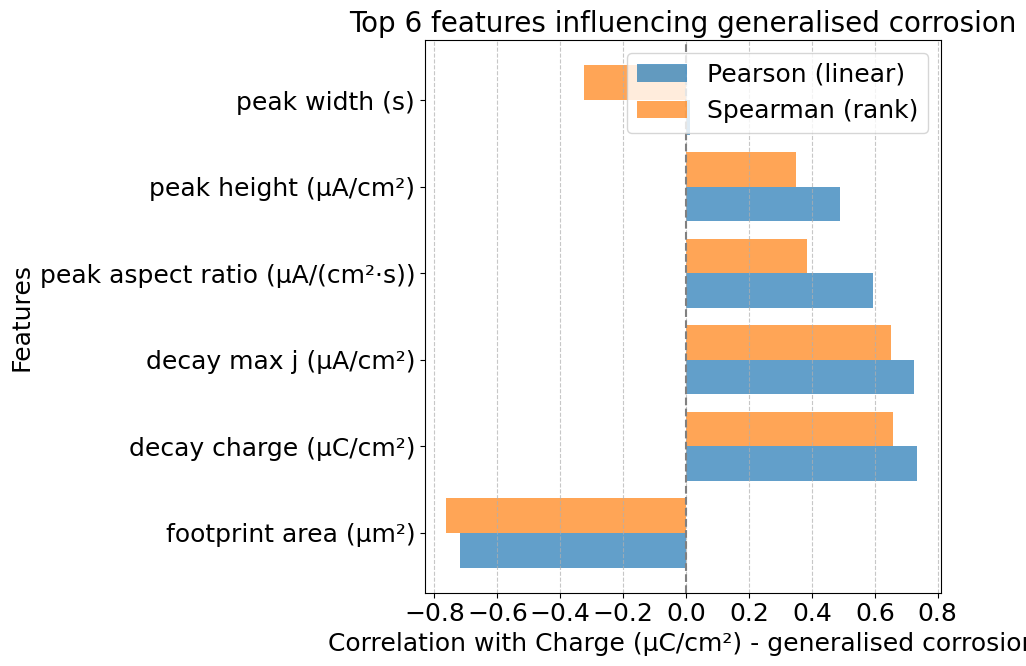

In [368]:
# ------------------------------------------------------------
# Correlation bar-plot (Pearson + Spearman) for:
#   'Charge (µC/cm²) - generalised corrosion'
# Adapted to the CURRENT pipeline variable: desc_norm_df
# (i.e., descriptors already area-normalized)
# ------------------------------------------------------------

df = desc_norm_df.copy()

target_var = "Charge (µC/cm²) - generalised corrosion"
if target_var not in df.columns:
    raise KeyError(
        f"Target column '{target_var}' not found in desc_norm_df.\n"
        "Make sure you:\n"
        "  (1) created it in desc_df (raw µC) BEFORE normalization, and\n"
        "  (2) included it in cols_to_norm so it becomes µC/cm² in desc_norm_df."
    )

# Same exclusion intent as original (but only keep those that exist)
excluded_feature = [
    "Baseline Mean (µA/cm²)",
    "Charge (µC/cm²)",
    "Total Charge (µC/cm²)",
    "Z (µm)",
    "decay region charge (µC/cm²)",
    "peak2 width (s)",
    "peak2 max position (s)",
    "peak2 charge (µC/cm²)",
    "peak2 height (µA/cm²)",
    "peak2 max (µA/cm²)",
    "initial j (µA/cm²)",
    "peak max (µA/cm²)",
]
excluded_feature = [c for c in excluded_feature if c in df.columns]

# Palette (seaborn if available; otherwise matplotlib default)
try:
    import seaborn as sns
    palette = []
    palette.extend(sns.color_palette("tab10", 10))
    palette.extend(sns.color_palette("Set1", 9))
    palette.extend(sns.color_palette("Dark2", 8))
    palette.extend(sns.color_palette("Set2", 8))
except Exception:
    palette = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Compute correlations vs target
features = [c for c in df.columns if c != target_var and c not in excluded_feature]

corr_data = []
for feat in features:
    valid = df[[feat, target_var]].dropna()
    if len(valid) < 3:
        continue
    # skip constants
    if valid[feat].nunique(dropna=True) < 2 or valid[target_var].nunique(dropna=True) < 2:
        continue

    pear = valid[feat].corr(valid[target_var], method="pearson")
    spear = valid[feat].corr(valid[target_var], method="spearman")

    if pd.isna(pear) and pd.isna(spear):
        continue

    corr_data.append({
        "feature": feat,
        "pearson_correlation": pear,
        "spearman_correlation": spear,
        "abs_pearson_correlation": abs(pear) if pd.notna(pear) else np.nan,
        "abs_spearman_correlation": abs(spear) if pd.notna(spear) else np.nan,
        "max_abs_correlation": np.nanmax([abs(pear), abs(spear)]),
        "count": len(valid),
    })

corr_df = pd.DataFrame(corr_data)
if corr_df.empty:
    raise ValueError(f"No valid correlations found for {target_var}")

# Sort + filter (same threshold as original)
corr_df = corr_df.sort_values("max_abs_correlation", ascending=False)
corr_df = corr_df[
    (corr_df["abs_pearson_correlation"] > 0.1) |
    (corr_df["abs_spearman_correlation"] > 0.1)
]
if corr_df.empty:
    raise ValueError(f"No correlations with absolute value > 0.1 found for {target_var}")

top_df = corr_df.head(min(6, len(corr_df)))

# --- plotting (match original look) ---
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18
})

fig, ax = plt.subplots(figsize=(10, 7))
bar_width = 0.4
y_pos = np.arange(len(top_df))

ax.barh(
    y=y_pos - bar_width/2,
    width=top_df["pearson_correlation"],
    height=bar_width,
    color=palette[0],
    alpha=0.7,
    label="Pearson (linear)"
)

ax.barh(
    y=y_pos + bar_width/2,
    width=top_df["spearman_correlation"],
    height=bar_width,
    color=palette[1],
    alpha=0.7,
    label="Spearman (rank)"
)

ax.axvline(x=0, color="gray", linestyle="--")
ax.set_xticks(np.arange(-1.0, 1.01, 0.2))
ax.grid(axis="x", linestyle="--", alpha=0.7)
ax.set_xlim(-0.83, 0.81)
ax.set_xlabel(f"Correlation with {target_var}", fontsize=18)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_df["feature"])
ax.set_ylabel("Features", fontsize=18)
ax.set_title("Top 6 features influencing generalised corrosion", fontsize=20)
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

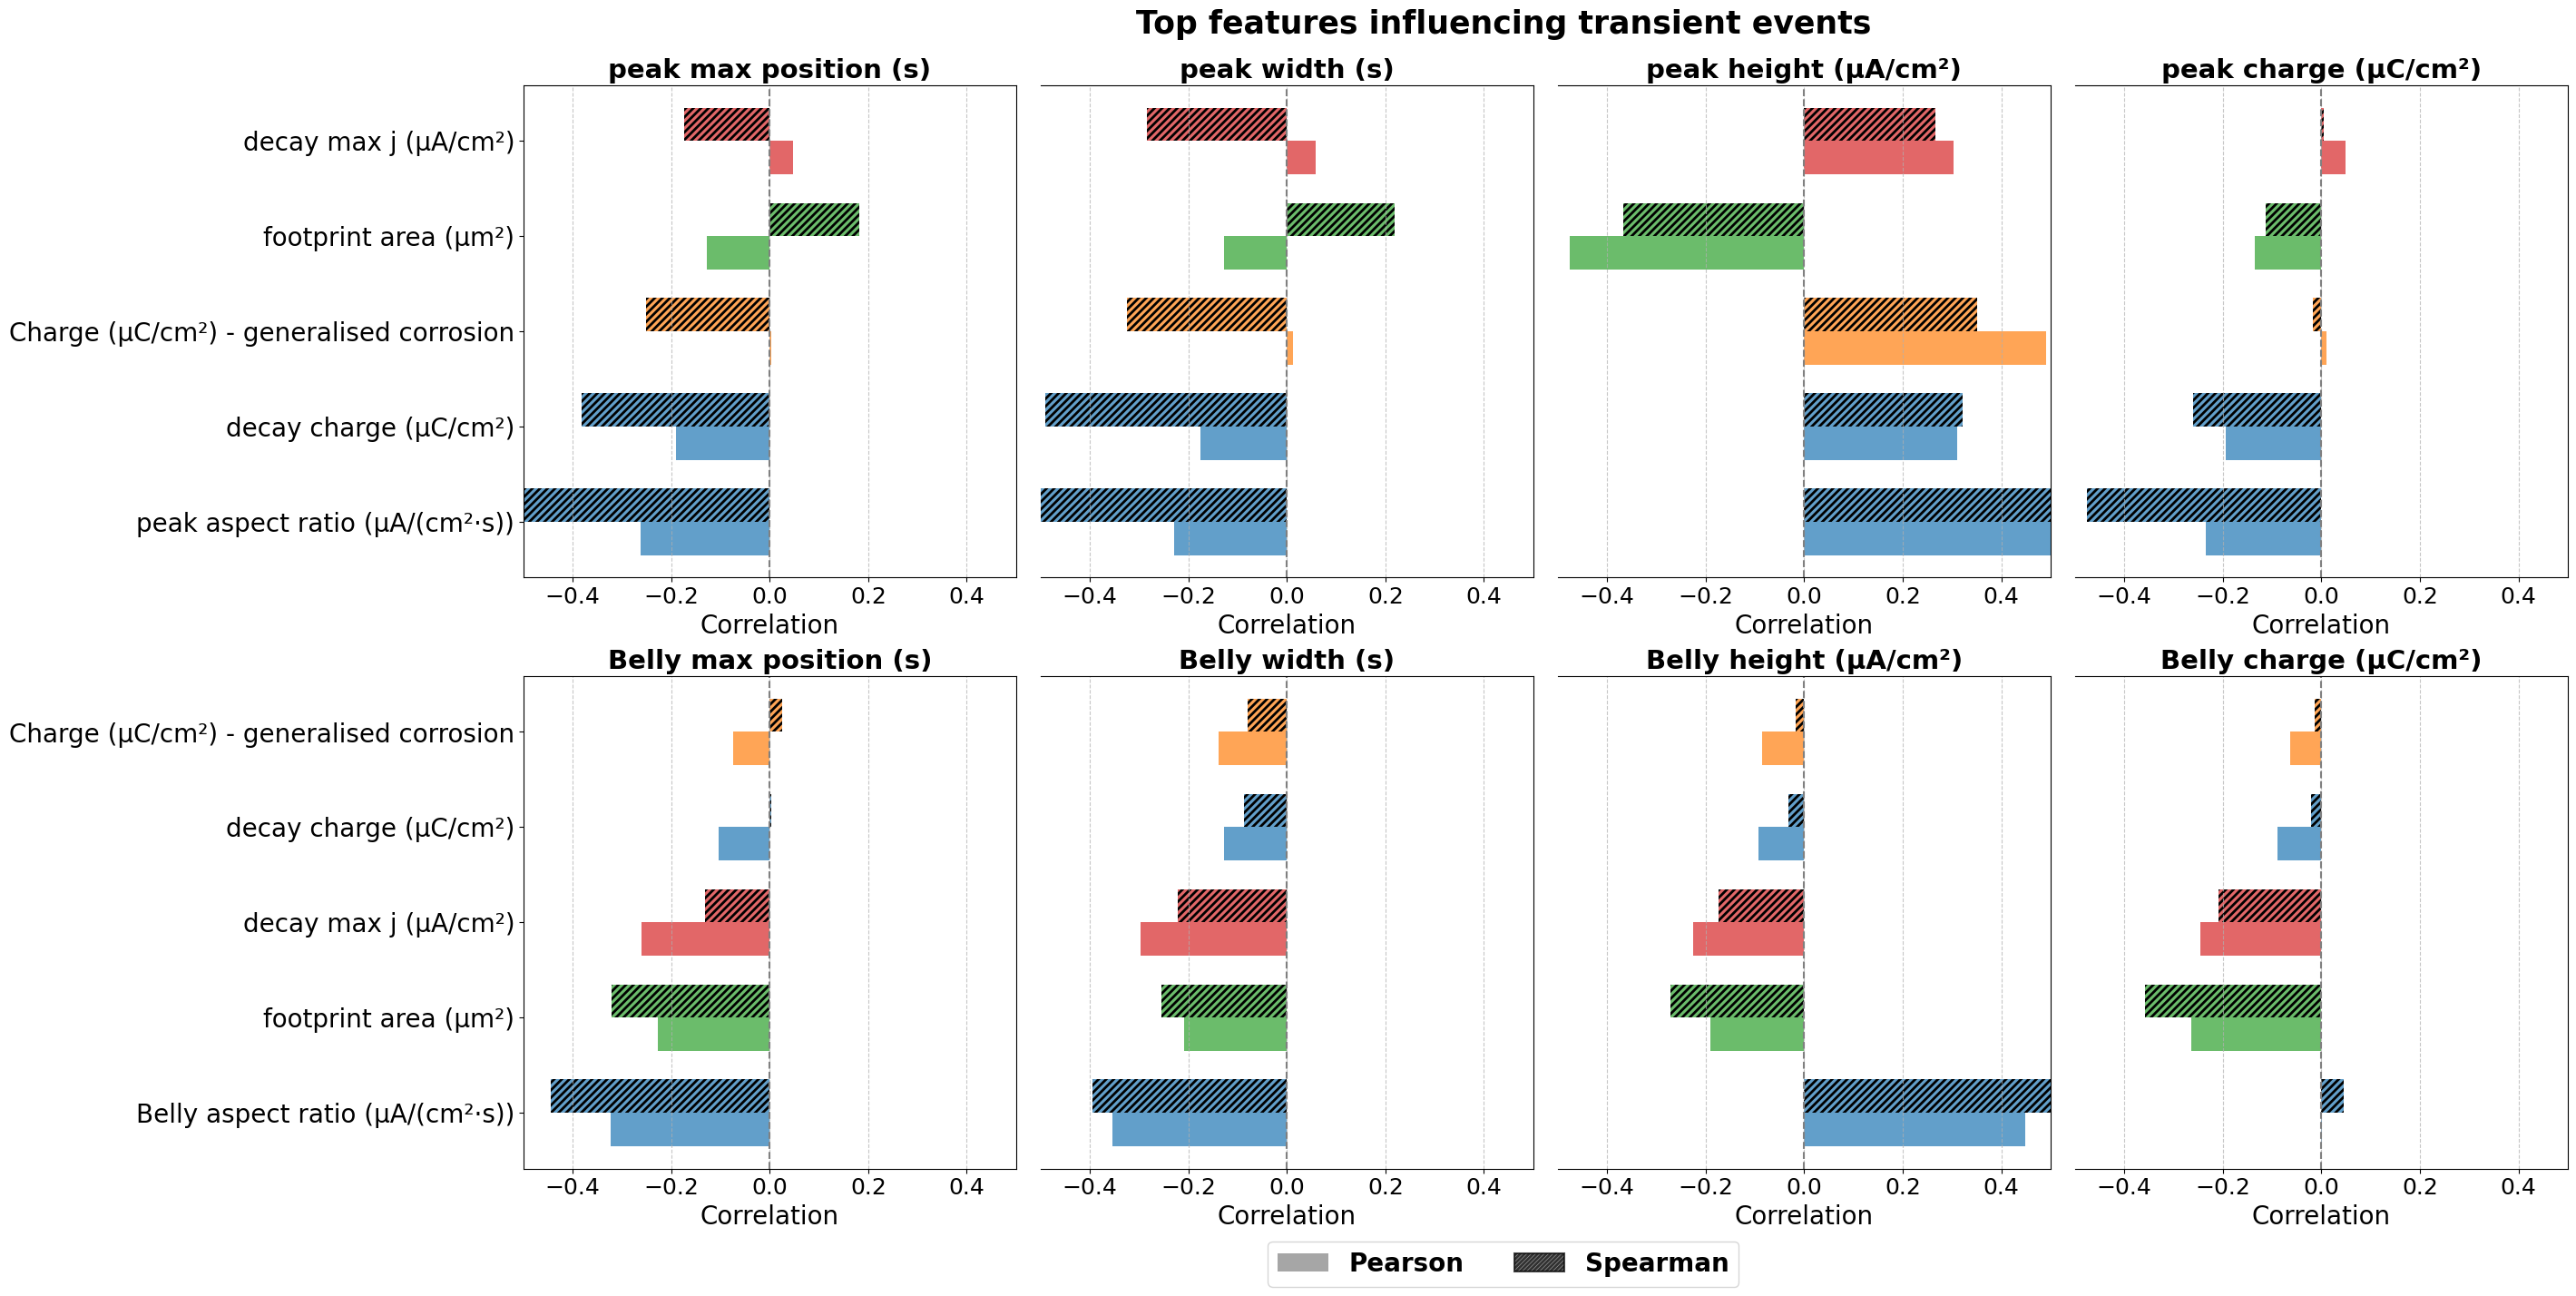

In [369]:

# ------------------------------------------------------------
# Combined 2×4 correlation figure (Pearson + Spearman)
# Top features influencing transient events (peak + belly)
# Adapted to CURRENT pipeline: desc_norm_df (area-normalized descriptors)
# (NO saving to disk in this version)
# ------------------------------------------------------------

df = desc_norm_df.copy()

# ---- Targets (same as original) ----
peak_target_variables = [
    "peak max position (s)",
    "peak width (s)",
    "peak height (µA/cm²)",
    "peak charge (µC/cm²)",
]
belly_target_variables = [
    "Belly max position (s)",
    "Belly width (s)",
    "Belly height (µA/cm²)",
    "Belly charge (µC/cm²)",
]
all_target_variables = peak_target_variables + belly_target_variables

# Keep only targets that exist (fails early if anything critical is missing)
missing_targets = [t for t in all_target_variables if t not in df.columns]
if missing_targets:
    raise KeyError(
        "Missing target column(s) in desc_norm_df:\n"
        + "\n".join(f" - {t}" for t in missing_targets)
        + "\n\nMake sure you created desc_norm_df (area-normalized) and included all needed columns."
    )

# ---- Exclusions (same intent as original; keep only those that exist) ----
excluded_feature = [
    "Baseline Mean (µA/cm²)",
    "Charge (µC/cm²)",
    "Total Charge (µC/cm²)",
    "Z (µm)",
    "decay region charge (µC/cm²)",
    "peak2 width (s)",
    "peak2 max position (s)",
    "peak2 charge (µC/cm²)",
    "peak2 height (µA/cm²)",
    "peak2 max (µA/cm²)",
    "initial j (µA/cm²)",
    "peak max (µA/cm²)",
    # exclude all target variables from being predictors
    "peak charge (µC/cm²)",
    "peak height (µA/cm²)",
    "peak width (s)",
    "peak max position (s)",
    "Belly charge (µC/cm²)",
    "Belly height (µA/cm²)",
    "Belly width (s)",
    "Belly max position (s)",
    # decay max position excluded (dual effect) — keep for parity
    "decay max position (s)",
]
excluded_feature = [c for c in excluded_feature if c in df.columns]

# ---- Palette (use seaborn if available, otherwise fallback) ----
palette = []
try:
    import seaborn as sns
    palette.extend(sns.color_palette("tab10", 10))
    palette.extend(sns.color_palette("Set1", 9))
    palette.extend(sns.color_palette("Dark2", 8))
    palette.extend(sns.color_palette("Set2", 8))
except Exception:
    palette = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Consistent feature colors (same mapping concept as original)
feature_color_mapping = {
    "decay charge (µC/cm²)": palette[0],
    "Charge (µC/cm²) - generalised corrosion": palette[1],
    "footprint area (µm²)": palette[2],
    "decay max j (µA/cm²)": palette[3],
    "decay max position (s)": palette[4],  # note: excluded above, kept for parity
}

def analyze_target_influence(target_var: str):
    """Return corr_df sorted by max(|pearson|, |spearman|)."""
    # predictors = everything except excluded (which includes all targets)
    features = [c for c in df.columns if c not in excluded_feature and c != target_var]

    corr_rows = []
    for feat in features:
        valid = df[[feat, target_var]].dropna()
        if len(valid) < 3:
            continue
        # skip constants
        if valid[feat].nunique(dropna=True) < 2 or valid[target_var].nunique(dropna=True) < 2:
            continue

        pear = valid[feat].corr(valid[target_var], method="pearson")
        spear = valid[feat].corr(valid[target_var], method="spearman")

        corr_rows.append({
            "feature": feat,
            "pearson_correlation": pear,
            "spearman_correlation": spear,
            "abs_pearson_correlation": abs(pear),
            "abs_spearman_correlation": abs(spear),
            "max_abs_correlation": max(abs(pear), abs(spear)),
            "count": len(valid),
        })

    corr_df = pd.DataFrame(corr_rows)
    if corr_df.empty:
        return None

    corr_df = corr_df.sort_values("max_abs_correlation", ascending=False)
    return corr_df

# ---- Run analysis for all targets ----
results = {tv: analyze_target_influence(tv) for tv in all_target_variables}

# ---- Determine the "common features" (top 5 of the first peak and first belly targets) ----
peak_first_target = peak_target_variables[0]
belly_first_target = belly_target_variables[0]

if results[peak_first_target] is None:
    raise ValueError(f"No valid correlations for peak target: {peak_first_target}")
if results[belly_first_target] is None:
    raise ValueError(f"No valid correlations for belly target: {belly_first_target}")

peak_common_features = results[peak_first_target].head(5)["feature"].tolist()
belly_common_features = results[belly_first_target].head(5)["feature"].tolist()

# ---- Figure layout (same as original) ----
global_min_corr, global_max_corr = -0.5, 0.5

fig = plt.figure(figsize=(24, 14))
gs = fig.add_gridspec(2, 4, height_ratios=[1, 1])
peak_axes = [fig.add_subplot(gs[0, i]) for i in range(4)]
belly_axes = [fig.add_subplot(gs[1, i]) for i in range(4)]

def plot_correlation_bars(axes, target_variables, common_features):
    for i, target_var in enumerate(target_variables):
        corr_df = results.get(target_var)
        if corr_df is None or corr_df.empty:
            continue

        # gather rows for the chosen common_features (preserving order)
        feature_values = {}
        for feat in common_features:
            row = corr_df.loc[corr_df["feature"] == feat]
            if not row.empty:
                r = row.iloc[0]
                feature_values[feat] = {
                    "pearson": r["pearson_correlation"],
                    "spearman": r["spearman_correlation"],
                    "count": r["count"],
                }

        ax = axes[i]
        bar_width = 0.35
        y_pos = np.arange(len(common_features))

        for j, feat in enumerate(common_features):
            if feat not in feature_values:
                continue

            feat_color = feature_color_mapping.get(feat, palette[j % len(palette)])

            # Pearson (solid)
            ax.barh(
                y=y_pos[j] - bar_width/2,
                width=feature_values[feat]["pearson"],
                height=bar_width,
                color=feat_color,
                alpha=0.7,
                label="Pearson" if (i == 0 and j == 0) else "",
            )

            # Spearman (hatched)
            ax.barh(
                y=y_pos[j] + bar_width/2,
                width=feature_values[feat]["spearman"],
                height=bar_width,
                color=feat_color,
                alpha=0.7,
                hatch="////",
                label="Spearman" if (i == 0 and j == 0) else "",
            )

        ax.axvline(x=0, color="gray", linestyle="--")
        ax.grid(axis="x", linestyle="--", alpha=0.7)
        ax.set_xlabel("Correlation", fontsize=20)
        ax.set_title(f"{target_var}", fontsize=21, fontweight="bold")
        ax.set_xlim([global_min_corr, global_max_corr])
        ax.tick_params(axis="x", labelsize=18)

        # If you want x ticks every 0.2 (optional):
        # ax.set_xticks(np.arange(global_min_corr, global_max_corr + 1e-9, 0.2))

        # y labels: only first subplot in each row shows labels + spine
        ax.set_yticks(y_pos)
        if i == 0:
            ax.set_yticklabels(common_features, fontsize=20)
        else:
            ax.set_yticklabels([])
            ax.spines["left"].set_visible(False)
            ax.tick_params(axis="y", length=0)

# Plot peak row + belly row
plot_correlation_bars(peak_axes, peak_target_variables, peak_common_features)
plot_correlation_bars(belly_axes, belly_target_variables, belly_common_features)

plt.rcParams["hatch.linewidth"] = 2.0

# Legend (same styling intent)
handles = [
    plt.Rectangle((0, 0), 1, 1, facecolor="gray", alpha=0.7, label="Pearson"),
    plt.Rectangle((0, 0), 1, 1, facecolor="gray", alpha=0.7, hatch="///////",
                  edgecolor="black", linewidth=1.5, label="Spearman"),
]
leg = fig.legend(handles=handles, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 0.02), fontsize=20)
for t in leg.get_texts():
    t.set_fontweight("bold")

plt.suptitle("Top features influencing transient events", fontsize=25, y=0.98, fontweight="bold")

plt.tight_layout()
plt.subplots_adjust(top=0.92, wspace=0.05, hspace=0.2, left=0.05)

plt.show()

In [370]:


display(descriptors[[
    "footprint area (µm²)",
    "peak aspect ratio (µA/(cm²·s))",
    "Belly aspect ratio (µA/(cm²·s))"
]].head(-10))

footprint area (µm²)  peak aspect ratio (µA/(cm²·s))  \
map_id                                                         
1                   7.950123                             NaN   
2                   6.183429                             NaN   
3                   5.577201                             NaN   
4                   5.455947                             NaN   
5                   7.361200                             NaN   
...                      ...                             ...   
191                 4.849740                             NaN   
192                 4.607253                             NaN   
193                 2.598075                             NaN   
194                 2.771280                    156563.92113   
195                 2.909844                             NaN   

        Belly aspect ratio (µA/(cm²·s))  
map_id                                   
1                                   NaN  
2                                   NaN  
3                                   NaN  
4                                   NaN  
5                                   NaN  
...                                 ...  
191                           24.401514  
192                                 NaN  
193                                 NaN  
194                                 NaN  
195                           37.464641  

[195 rows x 3 columns]

In [371]:
# ---------------------------------------------
# Create a NEW dataframe with CA traces normalized by footprint area
# Output units: µA/cm²  (to match desc_norm_df current-density units)
# (keeps df_ca untouched)
# ---------------------------------------------
# Requirements:
#   - df_ca already loaded (columns: time_s + MAP_Point_1..MAP_Point_205 in A)
#   - area_cm2 exists (from your desc_norm_df construction cell) indexed by map_id (1..205)

if "area_cm2" not in globals() or area_cm2 is None:
    raise NameError("area_cm2 not found. Run the area-normalized descriptor cell first (it defines area_cm2).")

def _map_id_from_col(col: str):
    """Extract trailing integer map_id from a CA column name (e.g., 'MAP_Point_205' -> 205)."""
    m = re.search(r"(\d+)\s*$", str(col))
    return int(m.group(1)) if m else None

# New dataframe: current density j in µA/cm²
df_ca_j_uA_cm2 = df_ca.copy()

skipped = []
missing_area = []
normalized_cols = 0

for col in df_ca.columns[1:]:  # skip time_s
    mid = _map_id_from_col(col)
    if mid is None:
        skipped.append(col)
        df_ca_j_uA_cm2[col] = np.nan
        continue
    if mid not in area_cm2.index:
        missing_area.append((col, mid))
        df_ca_j_uA_cm2[col] = np.nan
        continue

    # I(A) -> µA : *1e6 ; then divide by area_cm2 (cm²)
    df_ca_j_uA_cm2[col] = (df_ca[col] * 1e6) / area_cm2.loc[mid]
    normalized_cols += 1

print("df_ca shape:", df_ca.shape)
print("df_ca_j_uA_cm2 shape:", df_ca_j_uA_cm2.shape)
print("Normalized CA columns:", normalized_cols, "(expected ~205)")

# ---- robust example display (find a real CA column name) ----
time_col = "time_s" if "time_s" in df_ca_j_uA_cm2.columns else df_ca_j_uA_cm2.columns[0]

# candidate CA columns = everything except time column
ca_cols = [c for c in df_ca_j_uA_cm2.columns if c != time_col]

print("Time column:", time_col)
print("First 10 CA columns:", ca_cols[:10])

# pick one to display (prefer something containing '1' if you want map 1, otherwise just first)
example_col = None
for c in ca_cols:
    if str(c).endswith("_1") or str(c).endswith(" 1") or str(c).endswith("1"):
        example_col = c
        break
if example_col is None:
    example_col = ca_cols[0]

print("Example CA column used:", example_col)

pd.options.display.float_format = "{:.3e}".format
display(df_ca_j_uA_cm2[[time_col, example_col]].head(10))
pd.reset_option("display.float_format")

df_ca shape: (7782, 206)
df_ca_j_uA_cm2 shape: (7782, 206)
Normalized CA columns: 205 (expected ~205)
Time column: time_s
First 10 CA columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Example CA column used: 1


time_s         1
0 0.000e+00 3.924e+04
1 7.690e-03 3.497e+04
2 1.541e-02 3.031e+04
3 2.313e-02 2.591e+04
4 3.082e-02 2.214e+04
5 3.854e-02 1.887e+04
6 4.626e-02 1.610e+04
7 5.396e-02 1.409e+04
8 6.168e-02 1.248e+04
9 6.940e-02 1.092e+04

Primary label counts (exclusive): {'belly': np.int64(70), 'meta': np.int64(9), 'meta_decay': np.int64(11), 'meta_major': np.int64(1), 'prior_decay_activity': np.int64(7), 'unlabeled': np.int64(107)}


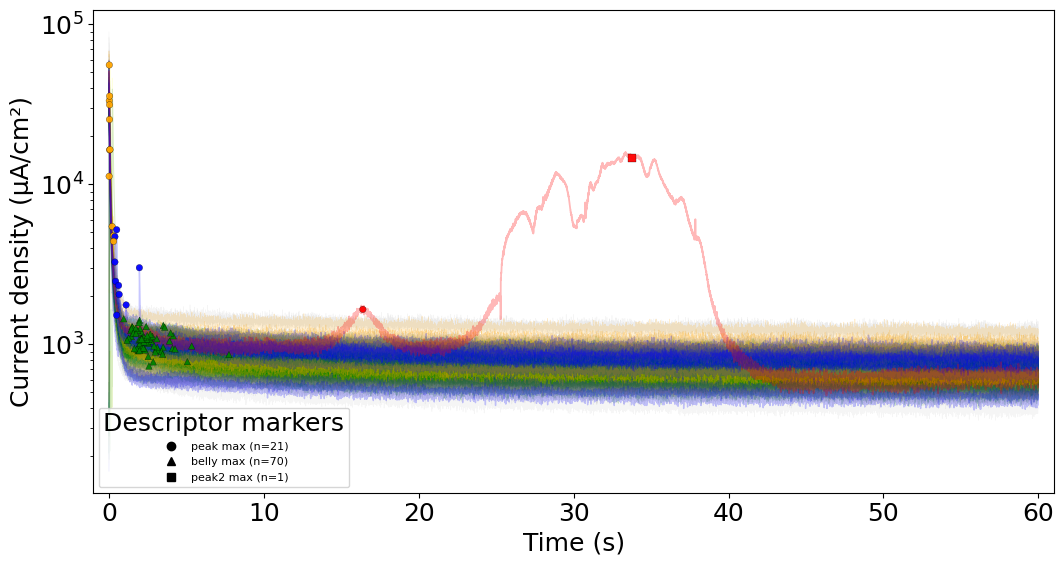

In [372]:
# ------------------------------------------------------------
# Plot all curves from df_ca_j_uA_cm2 + overlay descriptor markers (peak / belly / peak2)
# Uses:
#   - df_ca_j_uA_cm2  (time_s + MAP_Point_* columns)  [µA/cm²]
#   - desc_df         (indexed by map_id)             [descriptor times in s]
#   - labels_df       (optional; indexed by map_id)
# ------------------------------------------------------------

# -------------------------
# A) Build plotting arrays from df_ca_j_uA_cm2
# -------------------------
t_plot = df_ca_j_uA_cm2["time_s"].to_numpy()

ca_cols = [c for c in df_ca_j_uA_cm2.columns if c != "time_s"]
# Extract map_id from "MAP_Point_205" -> 205 (keeps the same order as ca_cols)
map_ids_desc = [int(str(c).split("_")[-1]) for c in ca_cols]

Y_plot = df_ca_j_uA_cm2[ca_cols].to_numpy()  # shape: (n_time, n_curves) in µA/cm²
# For log-scale plotting: remove non-positive values
Y_plot_log = np.where(Y_plot > 0, Y_plot, np.nan)

# -------------------------
# 0) Descriptor marker positions (t) from desc_df + marker y from nearest sample in CA curve
# -------------------------
desc_sub = desc_df.reindex(map_ids_desc)  # preserves curve order; NaNs if missing

peak_t  = pd.to_numeric(desc_sub.get("peak max position (s)"),  errors="coerce").to_numpy(dtype=float)
belly_t = pd.to_numeric(desc_sub.get("Belly max position (s)"), errors="coerce").to_numpy(dtype=float)

peak_y  = y_at_time_nearest(t_plot, Y_plot_log, peak_t)
belly_y = y_at_time_nearest(t_plot, Y_plot_log, belly_t)

# -------------------------
# 1) Colors + label priority (curve coloring)
# -------------------------
label_color = {
    "meta_major": "red",
    "meta": "blue",
    "belly": "green",
    "meta_decay": "orange",
    "prior_decay_activity": "yellow",
    "unlabeled": "gray",
}

priority = ["meta_major", "meta", "belly", "meta_decay", "prior_decay_activity"]

plot_order = ["unlabeled", "prior_decay_activity", "belly", "meta_decay", "meta", "meta_major"]
zorder_map = {lab: i for i, lab in enumerate(plot_order, start=1)}

alpha_map = {
    "unlabeled": 0.08,
    "prior_decay_activity": 0.12,
    "belly": 0.15,
    "meta_decay": 0.18,
    "meta": 0.22,
    "meta_major": 0.28,
}
lw_map = {
    "unlabeled": 0.45,
    "prior_decay_activity": 0.55,
    "meta_decay": 0.60,
    "belly": 0.75,
    "meta": 1.00,
    "meta_major": 1.30,
}

# -------------------------
# 2) Label assignment per curve (exclusive "primary label" for coloring)
# -------------------------
if ("labels_df" not in globals()) or (labels_df is None):
    primary_labels = np.array(["unlabeled"] * len(map_ids_desc), dtype=object)
else:
    onehot_cols = [c for c in ["prior_decay_activity","meta","meta_major","meta_decay","belly"] if c in labels_df.columns]

    def active_labels_for_mapid(map_id: int):
        if map_id not in labels_df.index:
            return set()

        row = labels_df.loc[map_id]
        active = set()

        # 1) one-hot flags
        for c in onehot_cols:
            if float(row.get(c, 0) or 0) > 0.5:
                active.add(c)

        # 2) fallback: parse 'labels' string (semicolon-separated)
        if (not active) and ("labels" in labels_df.columns):
            v = row.get("labels", np.nan)
            if pd.notna(v):
                parts = [p.strip() for p in str(v).split(";")]
                for p in parts:
                    if p in label_color:
                        active.add(p)
        return active

    def pick_primary_label(map_id: int) -> str:
        active = active_labels_for_mapid(map_id)
        if not active:
            return "unlabeled"
        for lab in priority:
            if lab in active:
                return lab
        return "unlabeled"

    primary_labels = np.array([pick_primary_label(int(mid)) for mid in map_ids_desc], dtype=object)

curve_colors = np.array([label_color.get(lab, "gray") for lab in primary_labels], dtype=object)

uniq, cnt = np.unique(primary_labels, return_counts=True)
print("Primary label counts (exclusive):", dict(zip(uniq, cnt)))

# -------------------------
# 3) Plot all curves + descriptor markers
# -------------------------
idx_by_label = {lab: np.where(primary_labels == lab)[0] for lab in plot_order}

fig, ax = plt.subplots(figsize=(11, 6))

for lab in plot_order:  # back -> front
    idxs = idx_by_label.get(lab, [])
    if len(idxs) == 0:
        continue
    for j in idxs:
        ax.plot(
            t_plot, Y_plot_log[:, j],
            color=label_color[lab],
            lw=lw_map[lab],
            alpha=alpha_map[lab],
            zorder=zorder_map[lab],
        )

# Markers: peak / belly (+ optional peak2)
m1 = np.isfinite(peak_t)  & np.isfinite(peak_y)
m2 = np.isfinite(belly_t) & np.isfinite(belly_y)

ax.scatter(peak_t[m1],  peak_y[m1],  c=curve_colors[m1], s=22, marker="o",
           edgecolors="k", linewidths=0.2, alpha=0.95, zorder=30)
ax.scatter(belly_t[m2], belly_y[m2], c=curve_colors[m2], s=22, marker="^",
           edgecolors="k", linewidths=0.2, alpha=0.95, zorder=30)

peak2_plotted = False
m3 = None
if "peak2 max position (s)" in desc_sub.columns:
    peak2_t = pd.to_numeric(desc_sub["peak2 max position (s)"], errors="coerce").to_numpy(dtype=float)
    peak2_y = y_at_time_nearest(t_plot, Y_plot_log, peak2_t)
    m3 = np.isfinite(peak2_t) & np.isfinite(peak2_y)
    if np.any(m3):
        ax.scatter(peak2_t[m3], peak2_y[m3], c=curve_colors[m3], s=30, marker="s",
                   edgecolors="k", linewidths=0.2, alpha=0.95, zorder=30)
        peak2_plotted = True

# Marker legend (counts actually plotted)
shape_handles = [
    Line2D([0],[0], marker="o", color="k", linestyle="None", markersize=6,
           label=f"peak max (n={int(m1.sum())})"),
    Line2D([0],[0], marker="^", color="k", linestyle="None", markersize=6,
           label=f"belly max (n={int(m2.sum())})"),
]
if peak2_plotted:
    shape_handles.append(
        Line2D([0],[0], marker="s", color="k", linestyle="None", markersize=6,
               label=f"peak2 max (n={int(m3.sum())})")
    )

ax.legend(handles=shape_handles, title="Descriptor markers", loc="lower left", fontsize=8)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Current density (µA/cm²)")
ax.set_yscale("log")  # keep as in your original style
ax.set_xlim(-1, 61)
plt.tight_layout()
plt.show()

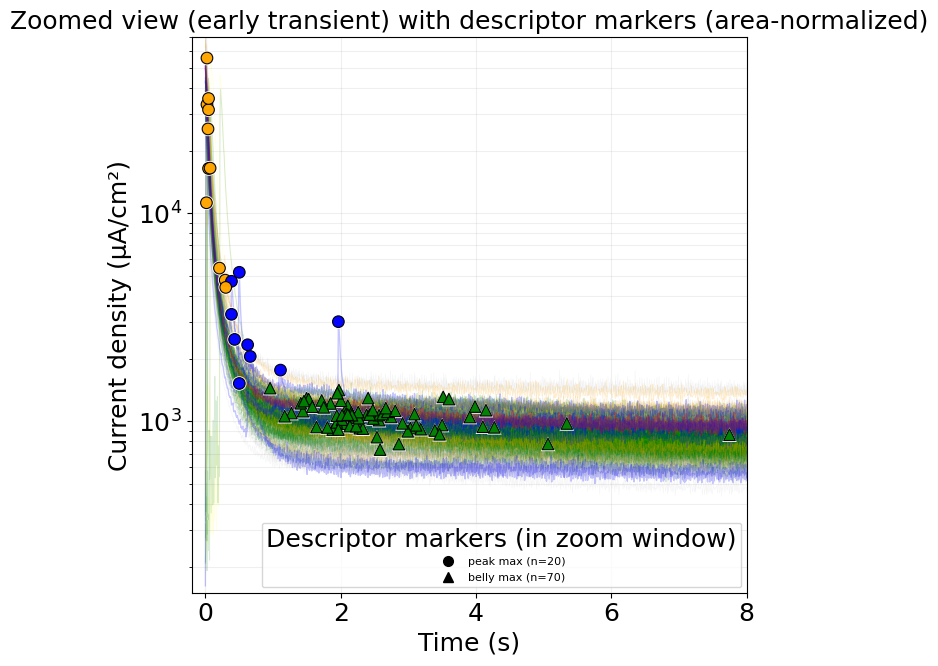

In [373]:
# --- ZOOMED-IN view for descriptor visibility (normalized CA curves: µA/cm²) ---

# Uses objects created in the previous "normalized CA + markers" cell:
#   t_plot, Y_plot_log, plot_order, idx_by_label, label_color, lw_map, alpha_map, zorder_map
#   peak_t, belly_t, peak_y, belly_y, curve_colors

# X zoom (seconds) – tune as needed
x_min, x_max = -0.2, 8.0

# Y zoom (µA/cm²) – tune as needed for your dataset
y_min, y_max = 150, 70000

fig, ax = plt.subplots(figsize=(7, 7))

# Plot curves in same zorder (back -> front)
for lab in plot_order:
    idxs = idx_by_label.get(lab, [])
    if len(idxs) == 0:
        continue
    for i in idxs:
        ax.plot(
            t_plot, Y_plot_log[:, i],
            color=label_color[lab],
            lw=lw_map[lab],
            alpha=alpha_map[lab],
            zorder=zorder_map[lab],
        )

# --- Markers (only those whose descriptor time falls in the zoom window) ---
m1 = np.isfinite(peak_t)  & (peak_t  >= x_min) & (peak_t  <= x_max) & np.isfinite(peak_y)
m2 = np.isfinite(belly_t) & (belly_t >= x_min) & (belly_t <= x_max) & np.isfinite(belly_y)

# sizes
s_peak, s_belly = 70, 70

# 1) White "halo" behind markers
ax.scatter(peak_t[m1],  peak_y[m1],  c="white", s=s_peak+40, marker="o",
           edgecolors="none", alpha=0.95, zorder=28)
ax.scatter(belly_t[m2], belly_y[m2], c="white", s=s_belly+40, marker="^",
           edgecolors="none", alpha=0.95, zorder=28)

# 2) Colored markers on top (with dark edge)
ax.scatter(peak_t[m1],  peak_y[m1],  c=curve_colors[m1], s=s_peak, marker="o",
           edgecolors="k", linewidths=0.8, alpha=0.98, zorder=30)
ax.scatter(belly_t[m2], belly_y[m2], c=curve_colors[m2], s=s_belly, marker="^",
           edgecolors="k", linewidths=0.8, alpha=0.98, zorder=30)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_yscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Current density (µA/cm²)")
ax.set_title("Zoomed view (early transient) with descriptor markers (area-normalized)")
ax.grid(True, which="both", alpha=0.2)

# Marker legend (optional)
shape_handles = [
    Line2D([0],[0], marker="o", color="k", linestyle="None", markersize=7, label=f"peak max (n={int(m1.sum())})"),
    Line2D([0],[0], marker="^", color="k", linestyle="None", markersize=7, label=f"belly max (n={int(m2.sum())})"),
]
ax.legend(handles=shape_handles, title="Descriptor markers (in zoom window)", loc="lower right", fontsize=8)

plt.tight_layout()
plt.show()

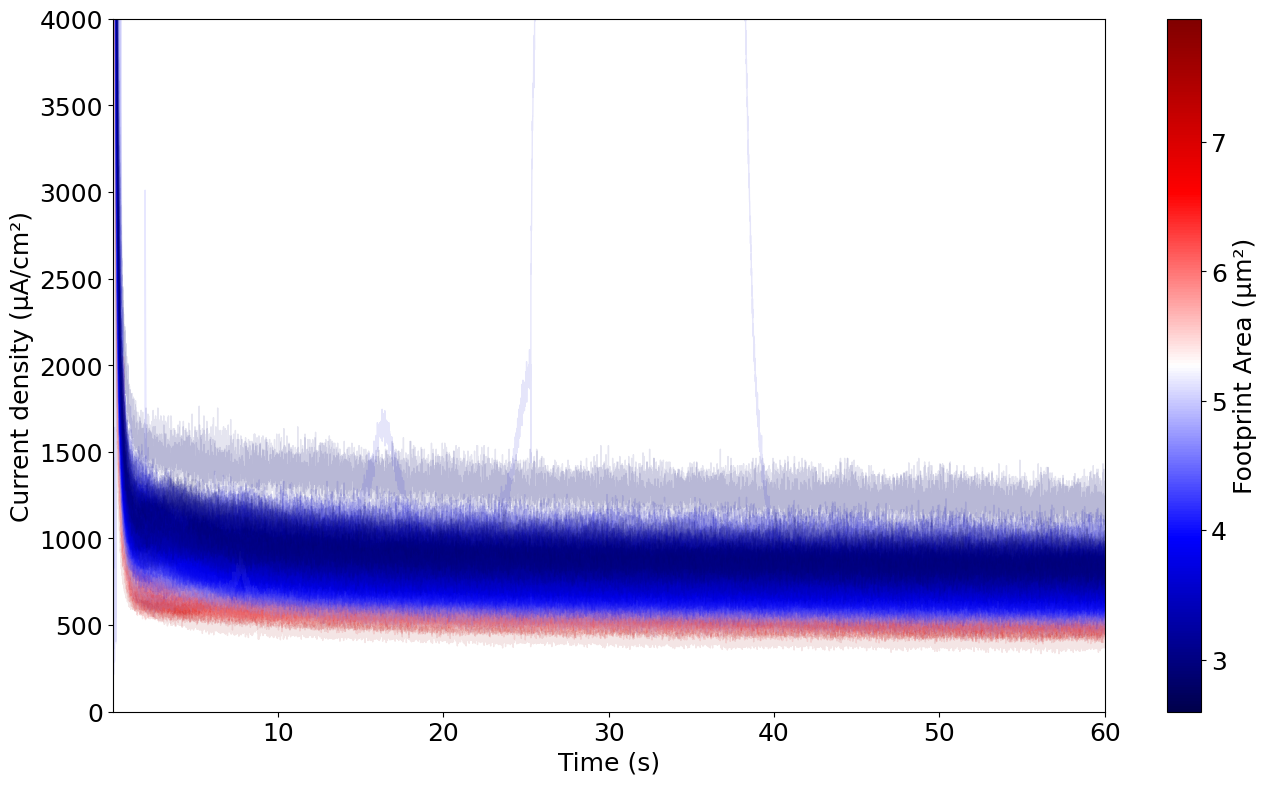

In [374]:
# -------------------------------------------------
# Plot all CA current-density traces (µA/cm²),
# colored by footprint area (µm²)
# Uses:
#   - df_ca_j_uA_cm2  (time_s + MAP_Point_* columns)
#   - desc_norm_df["footprint area (µm²)"]  indexed by map_id (1..205)
# -------------------------------------------------

# Increase all font sizes (same as original)
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18
})

# Time vector (same role as "t" in original)
t = df_ca_j_uA_cm2["time_s"].to_numpy()

# Footprint areas keyed by map_id
areas_um2 = desc_norm_df["footprint area (µm²)"].astype(float)

# Normalize footprint area for colormap
norm = mcolors.Normalize(vmin=areas_um2.min(), vmax=areas_um2.max())

# Choose a colormap (same as original)
colormap = plt.cm.seismic

fig, ax = plt.subplots(figsize=(16, 9))

# Plot each trace, colored by its footprint area
for col in df_ca_j_uA_cm2.columns:
    if col == "time_s":
        continue

    # Extract map_id from column name (e.g., MAP_Point_205 -> 205)
    try:
        map_id = int(str(col).split("_")[-1])
    except Exception:
        continue

    if map_id not in areas_um2.index:
        continue

    color = colormap(norm(areas_um2.loc[map_id]))
    ax.plot(t, df_ca_j_uA_cm2[col].to_numpy(), linewidth=1, alpha=0.1, color=color)

ax.set_xlim(0.01, 60)
ax.set_ylim(0, 4000)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Current density (µA/cm²)")

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label="Footprint Area (µm²)")
cbar.ax.tick_params(labelsize=18)
cbar.set_label("Footprint Area (µm²)", fontsize=18)

plt.show()

# Part 2 — Signal-processing framework (regenerate descriptors from raw SECCM CA)

This section reproduces the processing pipeline used to extract electrochemical descriptors from raw SECCM CA traces.
It can be run independently, but it is placed after Part 1 so readers can first reproduce the paper figures.

**Run order:** top-to-bottom within Part 2.

In [375]:
def mask_time(t_s, t_min_s=None, t_max_s=None):
    """Boolean mask for time window. t_s in seconds."""
    t_s = np.asarray(t_s, float)
    m = np.ones_like(t_s, dtype=bool)
    if t_min_s is not None:
        m &= (t_s >= t_min_s)
    if t_max_s is not None:
        m &= (t_s <= t_max_s)
    return m

def integrate_charge_C(t_s, i_uA, t_min_s=None, t_max_s=None, baseline_uA=0.0, check_monotonic=True):
    """
    Integrate current to charge.
    Inputs: t_s [s], i_uA [µA]. Output: Q [C].
    """
    t_s = np.asarray(t_s, float)
    i_uA = np.asarray(i_uA, float)

    if check_monotonic:
        dt = np.diff(t_s)
        if np.any(dt <= 0):
            raise ValueError("t_s must be strictly increasing for integration.")

    m = mask_time(t_s, t_min_s, t_max_s)
    if m.sum() < 2:
        return np.nan

    i_A = (i_uA[m] - baseline_uA) * 1e-6  # µA -> A
    return float(np.trapezoid(i_A, t_s[m]))

def compute_baseline_mean_uA(t, y_uA, baseline_start_idx, tail_frac=0.25):
    """
    Baseline mean over the last tail_frac of the signal,
    but not earlier than baseline_start_idx (INDEX, not seconds).
    """
    y_uA = np.asarray(y_uA, float)
    n = len(y_uA)
    tail_start = int(np.floor(n * (1 - tail_frac)))
    i0 = max(int(baseline_start_idx), tail_start)
    if i0 >= n - 1:
        return np.nan
    return float(np.nanmean(y_uA[i0:]))

def initial_j_uA(t_s, i_uA, t_window_s=0.05):
    """
    Robust initial current estimate: median over first t_window_s seconds
    relative to the first timestamp. (t_s in seconds, i_uA in µA)
    """
    t_s = np.asarray(t_s, float)
    i_uA = np.asarray(i_uA, float)
    if len(t_s) == 0:
        return np.nan

    m = (t_s <= (t_s[0] + t_window_s))
    if m.sum() < 1:
        # fallback: first non-nan if possible
        idx = np.where(~np.isnan(i_uA))[0]
        return float(i_uA[idx[0]]) if len(idx) else np.nan
    return float(np.nanmedian(i_uA[m]))

In [376]:

def _crossing_time_linear(t1, y1, t2, y2, y_target):
    """Linear interpolation time when line (t1,y1)-(t2,y2) crosses y_target."""
    if y2 == y1:
        return float(t1)
    frac = (y_target - y1) / (y2 - y1)
    return float(t1 + frac * (t2 - t1))

def peak_window_fwhm(t, y_uA, peak_idx, baseline_mean_uA):
    """
    Return (t_left, t_right, width_s) where crossings are at:
    y = baseline + 0.5*(peak - baseline)
    If crossing not found on one side, returns NaNs.
    """
    t = np.asarray(t, float)
    y = np.asarray(y_uA, float)
    p = int(peak_idx)

    if not np.isfinite(p) or p < 1 or p > len(t)-2:
        return np.nan, np.nan, np.nan

    y_peak = y[p]
    half = baseline_mean_uA + 0.5 * (y_peak - baseline_mean_uA)

    # search left
    t_left = np.nan
    for i in range(p, 0, -1):
        if (y[i] >= half) and (y[i-1] < half):
            t_left = _crossing_time_linear(t[i-1], y[i-1], t[i], y[i], half)
            break

    # search right
    t_right = np.nan
    for i in range(p, len(t)-1):
        if (y[i] >= half) and (y[i+1] < half):
            t_right = _crossing_time_linear(t[i], y[i], t[i+1], y[i+1], half)
            break

    if np.isfinite(t_left) and np.isfinite(t_right):
        return t_left, t_right, float(t_right - t_left)
    return t_left, t_right, np.nan

def compute_peak_metrics(t, y_uA, peak_idx, baseline_mean_uA, prefix="peak"):
    """
    Generic peak metrics for a given peak index.
    Returns dict with keys matching your published descriptor names.
    """
    if peak_idx is None or not np.isfinite(peak_idx):
        return {
            f"{prefix} max (µA)": np.nan,
            f"{prefix} max position (s)": np.nan,
            f"{prefix} height (µA)": np.nan,
            f"{prefix} width (s)": np.nan,
            f"{prefix} charge (C)": np.nan,
        }

    t = np.asarray(t, float)
    y = np.asarray(y_uA, float)
    p = int(peak_idx)

    y_peak = float(y[p])
    t_peak = float(t[p])
    height = float(y_peak - baseline_mean_uA)

    tL, tR, width = peak_window_fwhm(t, y, p, baseline_mean_uA)

    # charge over peak window (baseline-subtracted). If no window, fallback NaN.
    if np.isfinite(tL) and np.isfinite(tR) and (tR > tL):
        qC = integrate_charge_C(t, y, t_min_s=tL, t_max_s=tR, baseline_uA=baseline_mean_uA)
    else:
        qC = np.nan

    return {
        f"{prefix} max (µA)": y_peak,
        f"{prefix} max position (s)": t_peak,
        f"{prefix} height (µA)": height,
        f"{prefix} width (s)": width,
        f"{prefix} charge (C)": qC,
    }

In [377]:
# Smoothing + robust baseline-start detection

def smooth(y, window=51, poly=3):
    y = np.asarray(y, dtype=float).ravel()  # <-- critical
    window = int(window)
    poly = int(poly)

    # ensure odd window and <= len(y)
    if window % 2 == 0:
        window += 1
    if window >= len(y):
        window = max(5, len(y) - 1 if (len(y) - 1) % 2 == 1 else len(y) - 2)
        window = max(window, poly + 2 + (poly + 2) % 2)  # keep valid

    y_sm = savgol_filter(y, window_length=window, polyorder=poly, mode="interp")
    return np.asarray(y_sm, dtype=float).ravel()          # <-- critical

def find_baseline_start_idx(t, y_smooth, tail_frac=0.25, k=3.0, scale_floor=1e-9):
    """
    Baseline start where |dy/dt| drops below k * robust_scale of tail derivative.
    t in seconds (strictly increasing), y_smooth in same units as signal.
    Returns (idx, thresh).
    """
    t = np.asarray(t, float)
    y_smooth = np.asarray(y_smooth, float)

    if len(t) != len(y_smooth):
        raise ValueError(f"t and y_smooth must have same length. Got {len(t)} vs {len(y_smooth)}")

    dt = np.diff(t)
    if np.any(dt <= 0):
        raise ValueError("t must be strictly increasing for baseline detection.")

    dydt = np.gradient(y_smooth, t)

    n = len(dydt)
    tail_start = int((1 - tail_frac) * n)
    tail = dydt[tail_start:]

    med = np.nanmedian(tail)
    mad = np.nanmedian(np.abs(tail - med))
    scale = max(1.4826 * (mad if np.isfinite(mad) else 0.0), scale_floor)

    thresh = k * scale
    mask = np.abs(dydt) < thresh

    if not np.any(mask):
        return n - 1, float(thresh)

    idx = int(np.argmax(mask))  # first True
    return idx, float(thresh)

In [378]:
# Peak detection (robust + windowed)

def detect_main_peak(t, y_smooth, baseline_start_idx=None,
                     min_time_s=0.0, max_time_s=None,
                     prominence=None, distance_pts=20, pick="most_prominent"):
    """
    Detect the main peak (local max) in a defined time window.
    Returns (peak_idx, info_dict). If none found -> (None, info_dict).

    pick:
      - "most_prominent" (default): peak with max prominence
      - "highest": peak with highest y
      - "first": earliest peak in window
    """
    t = np.asarray(t, float)
    y = np.asarray(y_smooth, float)
    n = len(t)
    if n < 5:
        return None, {"reason": "too_short"}

    # window start/end
    i0 = int(np.searchsorted(t, float(min_time_s), side="left"))
    i1 = n
    if max_time_s is not None:
        i1 = min(i1, int(np.searchsorted(t, float(max_time_s), side="right")))
    if baseline_start_idx is not None and np.isfinite(baseline_start_idx):
        i1 = min(i1, int(np.clip(int(baseline_start_idx), 2, n)))

    if i1 - i0 < 5:
        return None, {"reason": "window_too_small", "i0": i0, "i1": i1}

    yy = y[i0:i1]

    # robust default prominence (if not provided)
    if prominence is None:
        p05, p95 = np.nanpercentile(yy, [5, 95])
        prominence = 0.10 * (p95 - p05)  # more robust than max-min

    # prefer scipy
    try:
        peaks, props = find_peaks(yy, prominence=prominence, distance=distance_pts)
        if len(peaks) == 0:
            return None, {"reason": "no_peaks_scipy", "i0": i0, "i1": i1, "prominence": float(prominence)}

        if pick == "highest":
            best_local = int(peaks[np.nanargmax(yy[peaks])])
        elif pick == "first":
            best_local = int(peaks[np.nanargmin(peaks)])
        else:  # most_prominent
            best_local = int(peaks[np.nanargmax(props["prominences"])])

        return i0 + best_local, {"method": "scipy", "i0": i0, "i1": i1, "prominence": float(prominence), "n_peaks": int(len(peaks))}
    except Exception:
        pass

    # fallback: simple local maxima
    cand = np.where((yy[1:-1] > yy[:-2]) & (yy[1:-1] > yy[2:]))[0] + 1
    if cand.size == 0:
        return None, {"reason": "no_peaks_fallback", "i0": i0, "i1": i1, "prominence": float(prominence)}

    if pick == "highest":
        best_local = int(cand[np.nanargmax(yy[cand])])
    else:  # first / most_prominent collapse to first in fallback
        best_local = int(cand[0])

    return i0 + best_local, {"method": "fallback", "i0": i0, "i1": i1, "prominence": float(prominence), "n_peaks": int(cand.size)}

In [379]:
# ex_id must match your columns type (int vs str)
ex_id = int(ex_id)

# robust column pick (handles int vs str columns)
col = ex_id if ex_id in I_uA_desc.columns else str(ex_id)

# force 1D float vector (and coerce non-numeric to NaN)
y = pd.to_numeric(I_uA_desc[col], errors="coerce").to_numpy(dtype=float).ravel()
t1 = np.asarray(t, dtype=float).ravel()

feat, y_sm, b0 = compute_framework_features(t1, y, map_id=ex_id)
pd.Series(feat)

peak max (µA)                       NaN
peak max position (s)               NaN
peak height (µA)                    NaN
peak width (s)                      NaN
peak charge (C)                     NaN
Belly height (µA)                   NaN
Belly width (s)                     NaN
Belly charge (C)                    NaN
Belly max position (s)              NaN
map_id                     1.130000e+02
Charge (C)                 6.096134e-09
Baseline Mean (µA)         2.201316e-05
initial j (µA)             1.210000e-03
decay max j (µA)           1.840000e-03
decay max position (s)     0.000000e+00
decay charge (C)           1.104746e-10
decay region charge (C)    1.053831e-10
baseline start idx         3.100000e+01
baseline thr (dI/dt)       1.192293e-05
dtype: float64

In [380]:
# Example “framework features”

def compute_framework_features(t, y_uA, map_id=None):
    # init container FIRST
    feat = {}

    y_smooth = smooth(y_uA, window=51, poly=3)

    # baseline
    baseline_start_idx, baseline_thr = find_baseline_start_idx(t, y_smooth, tail_frac=0.25, k=3.0)
    baseline_mean = compute_baseline_mean_uA(t, y_uA, baseline_start_idx, tail_frac=0.25)

    # main peak (recommended: restrict to early time to avoid "belly" being picked as main)
    # If you want: MAIN_PEAK_MAX_T_S = 0.5 as a config constant.
    mask_main = (t <= 0.5)
    if mask_main.sum() >= 10:
        pk_local, _ = detect_main_peak(t[mask_main], y_smooth[mask_main])
        pk_idx = (np.where(mask_main)[0][int(pk_local)]) if pk_local is not None else None
    else:
        pk_idx, _ = detect_main_peak(t, y_smooth)

    feat.update(compute_peak_metrics(t, y_uA, pk_idx, baseline_mean, prefix="peak"))

    # belly (broad hump)
    belly_idx, _info_b = detect_belly(
        t, y_smooth,
        baseline_start_idx=baseline_start_idx,
        baseline_mean_uA=baseline_mean,
        main_peak_idx=pk_idx,
        min_time_s=0.5,
        exclude_around_main_s=0.5,
        prominence=None,
        distance_pts=25,
        min_width_s=0.6
    )
    feat.update(compute_belly_metrics(t, y_uA, belly_idx, baseline_mean))

    # decay metrics
    decay_max_uA, decay_max_t_s, decay_charge_C, decay_region_charge_C = compute_decay_metrics(
        t, y_uA, baseline_start_idx, baseline_mean
    )

    # total charge (raw, no baseline subtraction)
    charge_C = integrate_charge_C(t, y_uA)

    # initial j
    init_uA = initial_j_uA(t, y_uA)

    # add “global” metrics
    feat.update({
        "map_id": int(map_id) if map_id is not None else np.nan,
        "Charge (C)": charge_C,
        "Baseline Mean (µA)": baseline_mean,
        "initial j (µA)": init_uA,
        "decay max j (µA)": decay_max_uA,
        "decay max position (s)": decay_max_t_s,
        "decay charge (C)": decay_charge_C,
        "decay region charge (C)": decay_region_charge_C,
        "baseline start idx": float(baseline_start_idx),
        "baseline thr (dI/dt)": float(baseline_thr),
    })

    # --- IMPORTANT: make the function actually return what later cells expect ---
    return feat, y_smooth, baseline_start_idx

In [381]:
def compute_decay_metrics(t, y_uA, baseline_start_idx, baseline_mean_uA):
    """
    Decay region: from start of trace to baseline_start_idx (exclusive).
    Returns (decay_max_uA, decay_max_t_s, decay_charge_C, decay_region_charge_C).
    """
    t = np.asarray(t, float)
    y_uA = np.asarray(y_uA, float)

    n = len(t)
    if n < 3:
        return np.nan, np.nan, np.nan, np.nan

    if baseline_start_idx is None or not np.isfinite(baseline_start_idx):
        i_end = n
    else:
        i_end = int(np.clip(int(baseline_start_idx), 2, n))

    y_decay = y_uA[:i_end]
    t_decay = t[:i_end]

    idx_local = int(np.nanargmax(y_decay))
    decay_max_uA = float(y_decay[idx_local])
    decay_max_t_s = float(t_decay[idx_local])

    t0, t1 = float(t_decay[0]), float(t_decay[-1])

    decay_charge_C = integrate_charge_C(t, y_uA, t_min_s=t0, t_max_s=t1, baseline_uA=0.0)
    decay_region_charge_C = integrate_charge_C(t, y_uA, t_min_s=t0, t_max_s=t1, baseline_uA=baseline_mean_uA)

    return decay_max_uA, decay_max_t_s, decay_charge_C, decay_region_charge_C

In [382]:
# Detect_belly + compute_belly_metrics (UPDATED, robust)

def detect_belly(
    t, y_smooth,
    baseline_start_idx=None,
    baseline_mean_uA=0.0,
    main_peak_idx=None,
    min_time_s=0.5,
    exclude_around_main_s=0.5,
    prominence=None,
    distance_pts=25,
    min_width_s=0.6,
):
    """
    Framework belly detector:
    - searches peaks in smoothed signal between t>=min_time_s and before baseline_start_idx
    - excludes peaks too close to the main peak (optional)
    - selects the candidate with the LARGEST FWHM width (broad hump = "belly")
    Returns (belly_idx, info_dict)
    """
    t = np.asarray(t, float)
    y = np.asarray(y_smooth, float)
    n = len(t)

    # Basic sanity
    if n < 10:
        return None, {"reason": "too_short", "n": int(n)}
    dt = np.diff(t)
    if np.any(dt <= 0):
        return None, {"reason": "non_monotonic_t"}

    # window end
    i1 = n
    if baseline_start_idx is not None and np.isfinite(baseline_start_idx):
        i1 = int(np.clip(int(baseline_start_idx), 2, n))

    # window start by time
    i0 = int(np.searchsorted(t, float(min_time_s), side="left"))
    if i1 - i0 < 10:
        return None, {"reason": "window_too_small", "i0": int(i0), "i1": int(i1)}

    # main peak time for exclusion
    t_main = None
    if main_peak_idx is not None and np.isfinite(main_peak_idx):
        p0 = int(np.clip(int(main_peak_idx), 0, n - 1))
        t_main = float(t[p0])

    yy = y[i0:i1]

    # robust default prominence (if None)
    if prominence is None:
        p05, p95 = np.nanpercentile(yy, [5, 95])
        prominence = 0.05 * (p95 - p05)  # mild default; belly can be low-amplitude
    prominence = float(prominence) if np.isfinite(prominence) else 0.0

    # find peaks (prefer scipy)
    try:
        peaks_local, props = find_peaks(yy, prominence=prominence, distance=distance_pts)
        peaks = (peaks_local + i0).astype(int).tolist()
        method = "scipy"
        used_prom = prominence
        n_raw = int(len(peaks))
    except Exception:
        # fallback: simple local maxima
        peaks_local = np.where((yy[1:-1] > yy[:-2]) & (yy[1:-1] > yy[2:]))[0] + 1
        peaks = (peaks_local + i0).astype(int).tolist()
        method = "fallback"
        used_prom = prominence
        n_raw = int(len(peaks))

    if len(peaks) == 0:
        return None, {"reason": "no_peaks", "i0": int(i0), "i1": int(i1), "method": method, "prominence": used_prom}

    # candidate filtering: exclude near main + require positive height over baseline
    cand = []
    for p in peaks:
        if t_main is not None and abs(float(t[p]) - t_main) < float(exclude_around_main_s):
            continue
        if not np.isfinite(y[p]):
            continue
        if float(y[p] - baseline_mean_uA) <= 0.0:
            continue
        cand.append(int(p))

    if len(cand) == 0:
        return None, {"reason": "no_candidates_after_filters", "method": method, "n_peaks": n_raw}

    # choose the WIDEST peak (FWHM) as belly
    widths = []
    heights = []
    windows = []
    for p in cand:
        tL, tR, w = peak_window_fwhm(t, y, p, baseline_mean_uA)  # uses SMOOTHED y here
        widths.append(w)
        heights.append(float(y[p] - baseline_mean_uA))
        windows.append((tL, tR))

    widths = np.asarray(widths, float)
    heights = np.asarray(heights, float)

    ok = np.isfinite(widths) & (widths >= float(min_width_s))
    if ok.sum() == 0:
        return None, {
            "reason": "no_broad_peak",
            "method": method,
            "min_width_s": float(min_width_s),
            "n_cand": int(len(cand)),
            "prominence": used_prom,
        }

    # Among broad candidates: prefer widest; tie-breaker = higher height
    idx_ok = np.where(ok)[0]
    best_local = idx_ok[np.lexsort((heights[idx_ok], widths[idx_ok]))][-1]
    belly_idx = int(cand[int(best_local)])

    tL_best, tR_best = windows[int(best_local)]
    return belly_idx, {
        "method": method,
        "i0": int(i0),
        "i1": int(i1),
        "n_peaks": int(n_raw),
        "n_cand": int(len(cand)),
        "prominence": float(used_prom),
        "width_s": float(widths[int(best_local)]),
        "height_uA": float(heights[int(best_local)]),
        "t_left": float(tL_best) if np.isfinite(tL_best) else np.nan,
        "t_right": float(tR_best) if np.isfinite(tR_best) else np.nan,
    }


def compute_belly_metrics(t, y_uA, belly_idx, baseline_mean_uA):
    """
    Returns dict with EXACT published belly column names:
      - Belly height (µA)
      - Belly width (s)
      - Belly charge (C)   [baseline-subtracted, integrated over FWHM window]
      - Belly max position (s)
    """
    if belly_idx is None or not np.isfinite(belly_idx):
        return {
            "Belly height (µA)": np.nan,
            "Belly width (s)": np.nan,
            "Belly charge (C)": np.nan,
            "Belly max position (s)": np.nan,
        }

    t = np.asarray(t, float)
    y = np.asarray(y_uA, float)
    p = int(np.clip(int(belly_idx), 0, len(t) - 1))

    y_b = float(y[p])
    t_b = float(t[p])
    height = float(y_b - baseline_mean_uA)

    # FWHM window computed on RAW signal (keeps compatibility with published descriptors)
    tL, tR, width = peak_window_fwhm(t, y, p, baseline_mean_uA)

    if np.isfinite(tL) and np.isfinite(tR) and (tR > tL):
        qC = integrate_charge_C(t, y, t_min_s=tL, t_max_s=tR, baseline_uA=baseline_mean_uA)
    else:
        qC = np.nan

    return {
        "Belly height (µA)": height,
        "Belly width (s)": float(width) if np.isfinite(width) else np.nan,
        "Belly charge (C)": qC,
        "Belly max position (s)": t_b,
    }

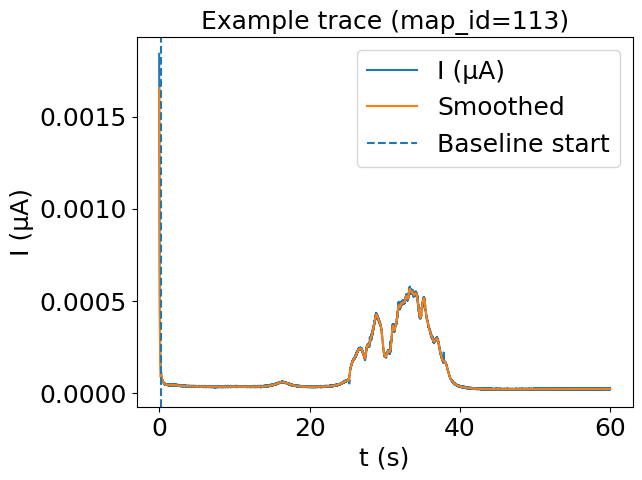

In [383]:
if PLOT_EXAMPLE:
    plt.figure()
    plt.plot(t, y, label="I (µA)")
    plt.plot(t, y_sm, label="Smoothed")
    plt.axvline(t[int(b0)], linestyle="--", label="Baseline start")
    # pk not available here unless you compute it separately; remove or recompute:
    plt.xlabel("t (s)")
    plt.ylabel("I (µA)")
    plt.legend()
    plt.title(f"Example trace (map_id={ex_id})")
    plt.show()

In [384]:
# run the framework on a small subset (index = map_id, no redundant map_id column)

subset_ids = list(I_uA_desc.columns)[:10]  # instead of I_uA.columns

rows = {}
for mid in subset_ids:
    y_mid = I_uA[mid].to_numpy()
    feat_mid, *_ = compute_framework_features(t, y_mid, map_id=mid)

    # remove redundant map_id if the function includes it
    if isinstance(feat_mid, dict):
        feat_mid = {k: v for k, v in feat_mid.items() if k != "map_id"}
    else:
        # if it's a Series
        feat_mid = feat_mid.drop(labels=["map_id"], errors="ignore")

    rows[int(mid)] = feat_mid

df_demo = pd.DataFrame.from_dict(rows, orient="index").sort_index()
df_demo.index.name = "map_id"
df_demo

peak max (µA)  peak max position (s)  peak height (µA)  \
map_id                                                           
1                 NaN                    NaN               NaN   
2                 NaN                    NaN               NaN   
3                 NaN                    NaN               NaN   
4                 NaN                    NaN               NaN   
5                 NaN                    NaN               NaN   
6                 NaN                    NaN               NaN   
7                 NaN                    NaN               NaN   
8                 NaN                    NaN               NaN   
9                 NaN                    NaN               NaN   
10                NaN                    NaN               NaN   

        peak width (s)  peak charge (C)  Belly height (µA)  Belly width (s)  \
map_id                                                                        
1                  NaN              NaN                NaN              NaN   
2                  NaN              NaN                NaN              NaN   
3                  NaN              NaN                NaN              NaN   
4                  NaN              NaN                NaN              NaN   
5                  NaN              NaN                NaN              NaN   
6                  NaN              NaN                NaN              NaN   
7                  NaN              NaN                NaN              NaN   
8                  NaN              NaN                NaN              NaN   
9                  NaN              NaN                NaN              NaN   
10                 NaN              NaN                NaN              NaN   

        Belly charge (C)  Belly max position (s)    Charge (C)  \
map_id                                                           
1                    NaN                     NaN  3.265598e-09   
2                    NaN                     NaN  2.682223e-09   
3                    NaN                     NaN  2.599577e-09   
4                    NaN                     NaN  2.567751e-09   
5                    NaN                     NaN  2.811162e-09   
6                    NaN                     NaN  2.599694e-09   
7                    NaN                     NaN  2.591633e-09   
8                    NaN                     NaN  2.571738e-09   
9                    NaN                     NaN  2.524443e-09   
10                   NaN                     NaN  2.566328e-09   

        Baseline Mean (µA)  initial j (µA)  decay max j (µA)  \
map_id                                                         
1                 0.000040         0.00206           0.00312   
2                 0.000037         0.00220           0.00316   
3                 0.000036         0.00200           0.00298   
4                 0.000036         0.00217           0.00341   
5                 0.000038         0.00198           0.00291   
6                 0.000037         0.00203           0.00304   
7                 0.000037         0.00214           0.00358   
8                 0.000036         0.00202           0.00302   
9                 0.000036         0.00216           0.00342   
10                0.000036         0.00224           0.00353   

        decay max position (s)  decay charge (C)  decay region charge (C)  \
map_id                                                                      
1                          0.0      2.687975e-10             2.260330e-10   
2                          0.0      2.795893e-10             2.399433e-10   
3                          0.0      2.732222e-10             2.318743e-10   
4                          0.0      1.981919e-10             1.901019e-10   
5                          0.0      2.667463e-10             2.235440e-10   
6                          0.0      1.874781e-10             1.792479e-10   
7                          0.0      2.827696e-10             2.408319e-10   
8          

# Part 3 — COMSOL (oxygen-flux model + plots)

This section loads the COMSOL FEM results (droplet diameter vs total oxygen flux) and reproduces the oxygen-flux plots and any derived quantities used in the paper.

**Run order:** top-to-bottom within Part 3.

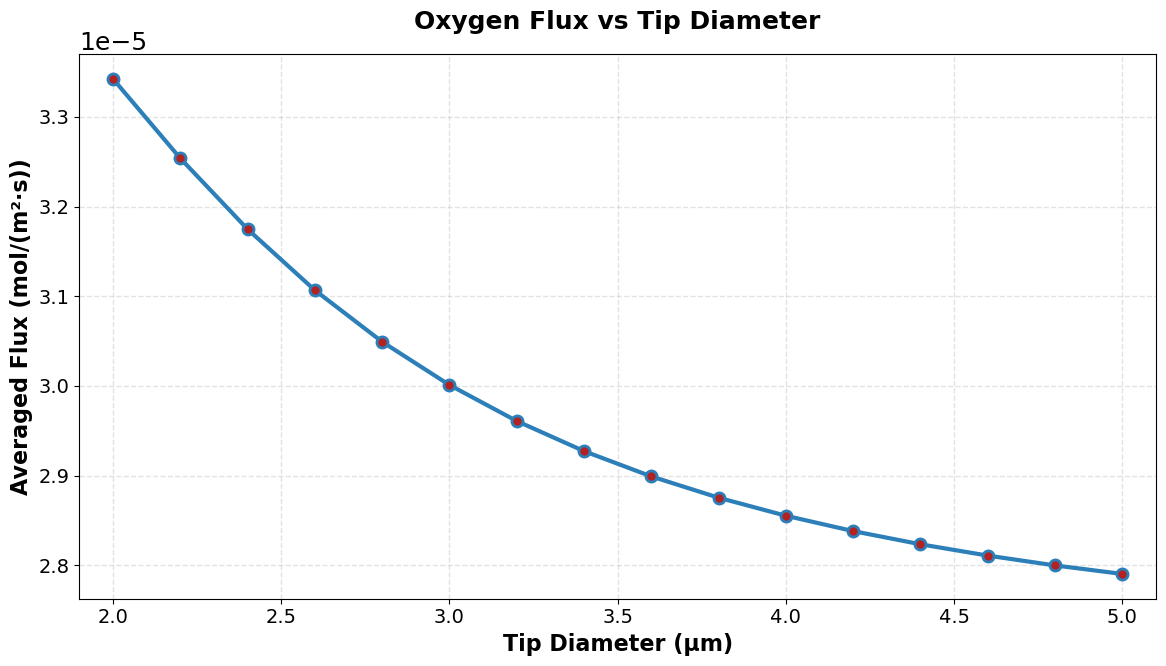

In [385]:


# --- Load COMSOL oxygen flux table (Table 3 - Line Average 1) ---
if not COMSOL_FILE.exists():
    raise FileNotFoundError(f"COMSOL_FILE not found: {COMSOL_FILE}")

comsol = pd.read_csv(
    COMSOL_FILE,
    comment="%",
    sep=r"\s+",
    header=None,
    names=["dr_um", "O2_flux_molm2s"],
    engine="python"
)

dr_um = comsol["dr_um"].to_numpy()
flux = comsol["O2_flux_molm2s"].to_numpy()

# Your figure uses "Tip Diameter (μm)" which corresponds to 2*dr
tip_d_um = 2 * dr_um

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(
    tip_d_um, flux,
    linewidth=3,
    color="#2c7fb8",
    marker="o",
    markersize=8,
    markerfacecolor="#b22222",
    markeredgecolor="#2c7fb8",
    markeredgewidth=2
)

ax.set_title("Oxygen Flux vs Tip Diameter", fontsize=18, fontweight="bold", pad=18)
ax.set_xlabel("Tip Diameter (μm)", fontsize=16, fontweight="bold")
ax.set_ylabel("Averaged Flux (mol/(m²·s))", fontsize=16, fontweight="bold")

ax.grid(True, linestyle="--", linewidth=1, alpha=0.35)
ax.tick_params(axis="both", labelsize=14)

# Force the "1e-5" scientific-notation offset like your screenshot
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax.set_xlim(1.9, 5.1)
plt.tight_layout()
plt.show()

In [386]:
from scipy.interpolate import interp1d

descriptors = globals().get("descriptors", None)
if descriptors is None:
    descriptors = globals().get("desc_df", None)
if descriptors is None:
    raise NameError("Expected a descriptor table named `desc_df` or `descriptors` to exist.")

# Interpolator: radius (µm) -> oxygen flux (mol m^-2 s^-1)
f_flux = interp1d(
    comsol["dr_um"].to_numpy(),
    comsol["O2_flux_molm2s"].to_numpy(),
    kind="linear",
    bounds_error=False
)

# --- Map footprint area -> radius -> O2 flux (DO NOT modify descriptors) ---
A_um2 = descriptors["footprint area (µm²)"].to_numpy()  # must match your column name
r_um = np.sqrt(A_um2 / np.pi)                           # radius in µm

# Clip to COMSOL range to avoid extrapolation artifacts
r_min, r_max = comsol["dr_um"].min(), comsol["dr_um"].max()
r_um_clip = np.clip(r_um, r_min, r_max)

O2_flux = f_flux(r_um_clip)

# Create a separate df with mapped COMSOL feature
df_comsolmap = pd.DataFrame({
    "footprint area (µm²)": A_um2,
    "droplet radius (µm)": r_um,
    "droplet radius clipped (µm)": r_um_clip,
    "O2 flux (mol m^-2 s^-1)": O2_flux
}, index=descriptors.index)  # keeps row alignment

df_comsolmap.head()

footprint area (µm²)  droplet radius (µm)  \
map_id                                              
1                   7.950123             1.590787   
2                   6.183429             1.402942   
3                   5.577201             1.332396   
4                   5.455947             1.317832   
5                   7.361200             1.530733   

        droplet radius clipped (µm)  O2 flux (mol m^-2 s^-1)  
map_id                                                        
1                          1.590787                 0.000030  
2                          1.402942                 0.000030  
3                          1.332396                 0.000031  
4                          1.317832                 0.000031  
5                          1.530733                 0.000030

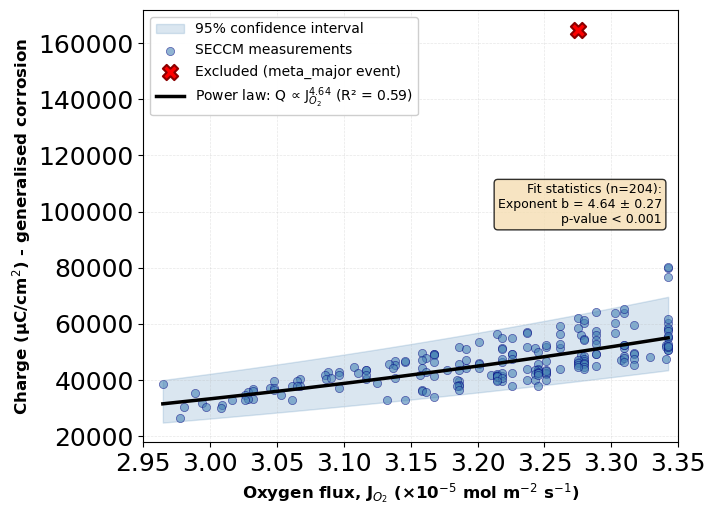


QUANTITATIVE OXYGEN-CHARGE CORRELATION
Power law: Q = A × (J_O2/J_ref)^b
  where J_ref = 1×10⁻⁵ mol m⁻² s⁻¹

Fitted parameters:
  Coefficient A = 2.033e+02 µC cm⁻²
  Exponent b = 4.642 ± 0.274

Statistical metrics:
  R² = 0.587 (explains 58.7% of variance)
  p-value = 1.22e-40 (highly significant)
  Sample size: n = 204 measurements
  Outlier excluded: 113 (meta_major event)

Physical interpretation:
  Oxygen flux range: 2.965e-05 to 3.342e-05 mol m⁻² s⁻¹
  Flux variation: 12.7%
  Charge range: 26335 to 80351 µC cm⁻²
  Charge variation: 205.1%
  Amplification factor: ~1.75×



In [387]:
from scipy.stats import linregress
from scipy import stats

# Prepare data (same as before)
J = df_comsolmap["O2 flux (mol m^-2 s^-1)"]

# Your column is (per manuscript wording) "Charge – generalised corrosion"
# If in your CSV it is exactly "Charge (µC/cm²)", keep that.
Q = descriptors["Charge (µC/cm²)"]  # <-- keep as-is if this matches your descriptors file

mask = np.isfinite(J) & np.isfinite(Q)

# Outlier: prefer map_id/site 113 if present; otherwise fall back to the 113th row (index[112]) like original snippet
outlier_label = 113 if 113 in descriptors.index else descriptors.index[112]
mask_fit = mask & (descriptors.index != outlier_label)

Jm = np.asarray(J[mask_fit])
Qm = np.asarray(Q[mask_fit])

# Normalize flux
Jstar = Jm / 1e-5
lx, lq = np.log(Jstar), np.log(Qm)
b, logA, r, p, se = linregress(lx, lq)
A = np.exp(logA)
r2 = r**2

# Calculate 95% confidence interval for predictions
n = len(Jm)
dof = n - 2
t_val = stats.t.ppf(0.975, dof)  # 95% CI

# Residual standard error
residuals = lq - (logA + b * lx)
s_res = np.sqrt(np.sum(residuals**2) / dof)

# Prediction grid
Jfit = np.linspace(Jm.min(), Jm.max(), 200)
Jfit_star = Jfit / 1e-5
lx_fit = np.log(Jfit_star)

# Calculate prediction interval in log space
lx_mean = np.mean(lx)
se_pred = s_res * np.sqrt(1 + 1/n + (lx_fit - lx_mean)**2 / np.sum((lx - lx_mean)**2))
lq_pred = logA + b * lx_fit
lq_upper = lq_pred + t_val * se_pred
lq_lower = lq_pred - t_val * se_pred

# Transform back to linear space
Qfit = np.exp(lq_pred)
Q_upper = np.exp(lq_upper)
Q_lower = np.exp(lq_lower)

# Create improved plot
fig, ax = plt.subplots(figsize=(7.5, 5.5))

# Plot confidence band first (so it's behind points)
ax.fill_between(Jfit, Q_lower, Q_upper, alpha=0.2, color='steelblue',
                label='95% confidence interval')

# Scatter plot - all points except outlier
ax.scatter(J[mask_fit], Q[mask_fit], s=35, alpha=0.6, color='steelblue',
           edgecolors='navy', linewidth=0.5, label='SECCM measurements')

# Outlier
ax.scatter(J.loc[outlier_label], Q.loc[outlier_label], s=120, marker='X',
           color='red', edgecolors='darkred', linewidth=1.5,
           label='Excluded (meta_major event)', zorder=5)

# Fit line
ax.plot(Jfit, Qfit, 'k-', linewidth=2.5,
        label=f'Power law: Q ∝ J$_{{O_2}}^{{{b:.2f}}}$ (R² = {r2:.2f})')

# Formatting
ax.set_xlabel('Oxygen flux, J$_{O_2}$ (×10$^{-5}$ mol m$^{-2}$ s$^{-1}$)',
              fontsize=12, fontweight='bold')
ax.set_ylabel('Charge (µC/cm$^{2}$) - generalised corrosion',
              fontsize=12, fontweight='bold')

# Better x-axis tick labels (kept identical)
ax.set_xlim(2.95e-5, 3.35e-5)
xticks = np.arange(2.95e-5, 3.35e-5, 0.05e-5)
ax.set_xticks(xticks)
ax.set_xticklabels([f'{x*1e5:.2f}' for x in xticks])

ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax.legend(loc='upper left', framealpha=0.95, fontsize=10)

# Add text box with fit statistics
textstr = f'Fit statistics (n={n}):\n'
textstr += f'Exponent b = {b:.2f} ± {se:.2f}\n'
textstr += f'p-value < 0.001'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.97, 0.50, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

# Print detailed stats (kept identical)
print(f"\n{'='*60}")
print(f"QUANTITATIVE OXYGEN-CHARGE CORRELATION")
print(f"{'='*60}")
print(f"Power law: Q = A × (J_O2/J_ref)^b")
print(f"  where J_ref = 1×10⁻⁵ mol m⁻² s⁻¹")
print(f"\nFitted parameters:")
print(f"  Coefficient A = {A:.3e} µC cm⁻²")
print(f"  Exponent b = {b:.3f} ± {se:.3f}")
print(f"\nStatistical metrics:")
print(f"  R² = {r2:.3f} (explains {r2*100:.1f}% of variance)")
print(f"  p-value = {p:.2e} (highly significant)")
print(f"  Sample size: n = {n} measurements")
print(f"  Outlier excluded: {outlier_label} (meta_major event)")
print(f"\nPhysical interpretation:")
print(f"  Oxygen flux range: {Jm.min():.3e} to {Jm.max():.3e} mol m⁻² s⁻¹")
print(f"  Flux variation: {(Jm.max()-Jm.min())/Jm.min()*100:.1f}%")
print(f"  Charge range: {Qm.min():.0f} to {Qm.max():.0f} µC cm⁻²")
print(f"  Charge variation: {(Qm.max()-Qm.min())/Qm.min()*100:.1f}%")
print(f"  Amplification factor: ~{(Qm.max()/Qm.min()) / ((Jm.max()/Jm.min())**b):.2f}×")
print(f"{'='*60}\n")

## Reference

If you use this dataset or code framework, please cite:

- Coelho, L. B.; Torres, D.; Bernal, M.; Malet, L.; Makogon, A.; Kanoufi, F.; Shkirskiy, V.; Ustarroz, J.
  *Oxygen effects on passive film evolution and metastable pitting in 316 L stainless steel using SECCM*,
  **Corrosion Science** (2026). DOI: https://doi.org/10.1016/j.corsci.2026.113708

- Dataset (Zenodo): DOI **TBD**